In [ ]:
#this is post processing pipeline
#this is post processing pipeline
#this is post processing pipeline
#this is post processing pipeline
#this is post processing pipeline
#this is post processing pipeline
#this is post processing pipeline
#this is post processing pipeline
#this is post processing pipeline
#this is post processing pipeline
#this is post processing pipeline
#this is post processing pipeline
#this is post processing pipeline
#this is post processing pipeline
#this is post processing pipeline
#this is post processing pipeline
#this is post processing pipeline
#this is post processing pipeline
#this is post processing pipeline

# this is post processing pipeline (i shall not change the name of this file)


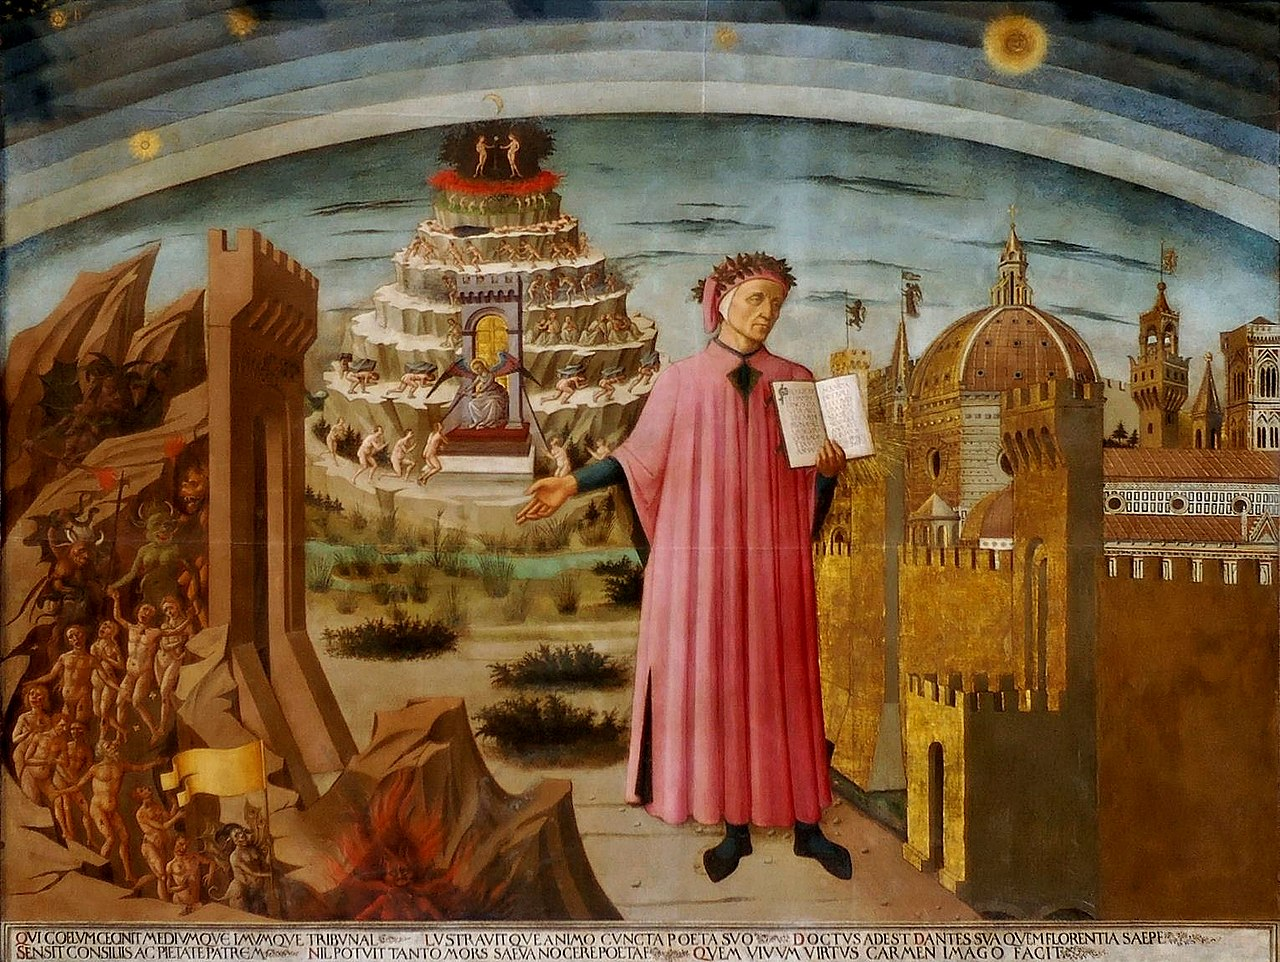

In [53]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.cluster import DBSCAN, MeanShift
import math
from itertools import combinations
from skimage.morphology import skeletonize
from scipy.stats import mode 
import copy
import random

In [2]:
!nvidia-smi

Sun Dec 22 15:42:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060        On  | 00000000:02:00.0 Off |                  N/A |
|  0%   44C    P8              16W / 170W |     21MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [221]:
import zipfile
with zipfile.ZipFile('pred_mask_raw_mixed.zip', 'r') as zip_ref:
    zip_ref.extractall('pred_mask_raw_mixed')
with zipfile.ZipFile('pred_mask_raw_vaga.zip', 'r') as zip_ref:
    zip_ref.extractall('pred_mask_raw_vaga')

In [285]:
with zipfile.ZipFile('true_mask_mixed.zip', 'r') as zip_ref:
    zip_ref.extractall('true_mask_mixed')

# to do ngayf mai

tinhs goc giua cac line, tinhs khoang cachs tu center

In [3]:
def plot_images(image1, image2, title1="Image 1", title2="Image 2"):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image1, cmap='gray')
    plt.axis('on')

    plt.subplot(1, 2, 2)
    plt.imshow(image2, cmap='gray')
    plt.axis('on')

    plt.show()

def plot_images1(image1,  title1="Image 1"):
    plt.figure(figsize=(12, 6))
    

    plt.imshow(image1, cmap='gray')
    plt.axis('on')



    plt.show()

In [77]:
class Line:
    def __init__(self, x1, y1, x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.AB = (self.x2 - self.x1, self.y2 - self.y1)
        self.length = self.length()
        self.orientation = self.set_orientation()
        self.list_dis = self.dis_from_ref(384, 384)

        
    def length(self):
        AB = (self.x2 - self.x1, self.y2 - self.y1)
        return np.sqrt(AB[0]**2 + AB[1]**2)
    
    def set_orientation(self):
        angle = self.calculate_angle()
        if angle > 180: 
            angle = angle - 180
        
        if angle > 90: 
            angle = 180 - angle

        if angle >= 45:
            return "vertical"
        else:
            return "horizontal"
     
        
    def calculate_angle(self):
        ox = (1,0)
        A = (self.x1, self.y1)
        B = (self.x2, self.y2)
        AB = (self.x2 - self.x1, self.y2 - self.y1)
        mag_AB = np.sqrt(AB[0]**2 + AB[1]**2)
        dot_prod = np.dot(AB, ox)
        mag_prod = mag_AB * 1
        angle = math.acos(dot_prod / mag_prod)  
        
        return math.degrees(angle) % 360

    
    
    def calculate_angle_of_range_plusminus_90(self):
        ox = (1,0)
        A = (self.x1, self.y1)
        B = (self.x2, self.y2)
        AB = (self.x2 - self.x1, self.y2 - self.y1)
        mag_AB = np.sqrt(AB[0]**2 + AB[1]**2)
        dot_prod = np.dot(AB, ox)
        mag_prod = mag_AB * 1
        angle = math.acos(dot_prod / mag_prod)  
        
        angle_correct = math.degrees(angle) % 360
        if  angle_correct > 90 and angle < 270:
            angle_correct -= 180
        if  angle_correct >= 270:
            angle_correct -= 360
        return angle_correct
    
    
    
    def cross_angle(self,other_line):
        
        A = (self.x1, self.y1)
        B = (self.x2, self.y2)
        AB = (self.x2 - self.x1, self.y2 - self.y1)
        
        C = (other_line.x1, other_line.y1)
        D = (other_line.x2, other_line.y2)
        CD = (other_line.x2 - other_line.x1, other_line.y2 - other_line.y1)        
        
        mag_AB = np.sqrt(round(AB[0]**2 + AB[1]**2,15))
        mag_CD = np.sqrt(round(CD[0]**2 + CD[1]**2,15))
        
        dot_prod = round(np.dot(AB, CD),15)
        mag_prod = round(mag_AB * mag_CD,15)
#         print(dot_prod)
#         print(mag_prod)
        angle = math.acos(round(dot_prod / mag_prod))  
        return math.degrees(angle) % 360
        
        
        
    def dis_from_ref(self,width, length):

        
        point1 = (width* (5/7),length* 0.5)
        point2 = (width /6,length *(6/7))        
        point3 = (width* (3.5/9),length * (1/3))        
#         point4 = (240,240)
        
        
        def dis_point_line(X00,Y00):
            tu = abs((self.y2  - self.y1)* X00 - (self.x2  - self.x1)* Y00 + self.x2 * self.y1 - self.x1 * self.y2)
            AB = (self.x2 - self.x1, self.y2 - self.y1)
            mau = np.sqrt(AB[0]**2 + AB[1]**2)
            return tu/mau
        
        
        dis1 = dis_point_line(*point1)
        dis2 = dis_point_line(*point2)
        dis3 = dis_point_line(*point3)
#         dis4 = dis_point_line(*point4)
        
        return [dis1,dis2,dis3]
            
            
        

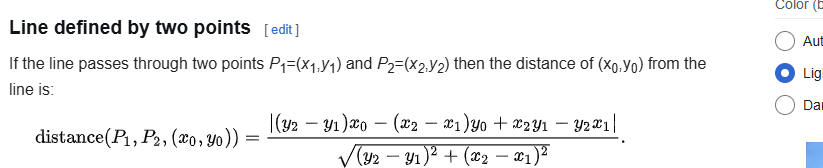

In [5]:
def classify_line(lines):
    vertical_lines = []
    horizontal_lines = []

    if lines is None: 
        return [], []

    for l in lines:
        line = Line(l[0][0], l[0][1], l[0][2], l[0][3])

        if line.orientation == 'vertical':
            vertical_lines.append(line)

        if line.orientation == 'horizontal':
            horizontal_lines.append(line)

    return vertical_lines, horizontal_lines

In [6]:
def smooth_edges(mask):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,15))  # chỉnh nếu cần #old 15,15
    closed_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)   #old open
    # closed_mask = cv2.morphologyEx(closed_mask, cv2.MORPH_OPEN, kernel)

    return closed_mask

In [7]:
def morphing(image):
    # gaussian_ksize = (7, 7) 
    erosion_kernel_1 = np.ones((5, 5), np.uint8)
    dilation_kernel_1 = np.ones((5, 5), np.uint8)
    erosion_kernel_2 = np.ones((3,3), np.uint8)
    dilation_kernel_2 = np.ones((5, 5), np.uint8)

    #blurred_mask = cv2.GaussianBlur(binary_mask, gaussian_ksize, 0)
   # eroded_image = cv2.erode(image, erosion_kernel_1, iterations=1)
    dilated_image = cv2.dilate(image, dilation_kernel_1, iterations=2)
    eroded_image_2 = cv2.erode(dilated_image, erosion_kernel_1, iterations=1)
    #dilated_image_2 = cv2.dilate(eroded_image_2, dilation_kernel_2, iterations=1)
    processed_image = cv2.erode(eroded_image_2, erosion_kernel_2, iterations=1)
    
    return processed_image

In [8]:
# def remove_black_noise_with_contours(image, area_threshold=100, min_width=10, min_height=10):
#     inverted = (image == 0).astype(np.uint8)
#     contours, _ = cv2.findContours(inverted, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     output_mask = np.zeros_like(image, dtype=np.uint8)

#     for contour in contours:
#         x, y, w, h = cv2.boundingRect(contour)
#         if cv2.contourArea(contour) > area_threshold and w > min_width and h > min_height:
            
#             cv2.drawContours(output_mask, [contour], -1, 0, thickness=cv2.FILLED)
#         else:
            
#             cv2.drawContours(output_mask, [contour], -1, 255, thickness=cv2.FILLED)

    
#     output_image = np.maximum(image, output_mask)

#     return output_image

In [9]:
def create_image_with_hough_lines(image, lines, is_binary):
    height, width = image.shape

    if (is_binary):
        line_image = np.zeros((height, width, 3))
        color = (0,255, 247)

    else: 
        line_image = np.copy(image) * 0
        color = (255,0,0)


    if lines is not None:
        for line in lines:
#             x1, y1, x2, y2 = line[0]
            cv2.line(line_image, (int(line.x1), int(line.y1)), (int(line.x2), int(line.y2)), color, 2)
            
    # combined_image = cv2.addWeighted(image, 0.8, line_image, 1, 0)

    return line_image   

In [10]:
def create_image_with_classified_lines(image, vertical_lines, horizontal_lines,is_binary=True):
    height, width = image.shape

    if (is_binary):
        line_image = np.zeros((height, width, 3))


    for line in horizontal_lines: 
        cv2.line(line_image, (int(line.x1), int(line.y1)), (int(line.x2), int(line.y2)), (255,0,0), 2)

    for line in vertical_lines:
        cv2.line(line_image, (int(line.x1), int(line.y1)), (int(line.x2), int(line.y2)), (0,0,255), 2)

        
    return line_image 

In [11]:
def calculate_intersection(line1, line2):
    x1, y1, x2, y2 = line1.x1, line1.y1, line1.x2, line1.y2
    x3, y3, x4, y4 = line2.x1, line2.y1, line2.x2, line2.y2

    
    denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denominator == 0:  
        return None # Parallel lines
    
    px = ((x1*y2 - y1*x2) * (x3 - x4) - (x1 - x2) * (x3*y4 - y3*x4)) / denominator
    py = ((x1*y2 - y1*x2) * (y3 - y4) - (y1 - y2) * (x3*y4 - y3*x4)) / denominator
    return int(px), int(py)

In [12]:
def get_border_lines(image_shape):
    height, width = image_shape[:2]

    border_lines = [
        Line(0, 0, width - 1, 0),         # Top 
        Line(0, height - 1, width - 1, height - 1),  # Bottom 
        Line(0, 0, 0, height - 1),        # Left 
        Line(width - 1, 0, width - 1, height - 1)    # Right 
    ]

    return border_lines

In [13]:
def find_intersection(vertical_lines, horizontal_lines) -> None:
    point_list = []
    for vline in vertical_lines: 
        for hline in horizontal_lines:
            points = calculate_intersection(vline, hline)
            point_list.append(points)

    return point_list

In [14]:
def is_point_on_line(point, line, tolerance=0.1):
    x, y = point
    x1, y1, x2, y2 = line.x1, line.y1, line.x2, line.y2

    distance = abs((y2 - y1) * x - (x2 - x1) * y + x2 * y1 - y2 * x1) / (
        ((y2 - y1) ** 2 + (x2 - x1) ** 2) ** 0.5
    )
    return distance <= tolerance
def filter_intersections(intersections, vertical_lines, horizontal_lines, tolerance = 0.1):
    valid_intersections = []

    for point in intersections:
        on_vertical = any(is_point_on_line(point, vline, tolerance) for vline in vertical_lines)
        on_horizontal = any(is_point_on_line(point, hline, tolerance) for hline in horizontal_lines)

        if on_vertical and on_horizontal:
            valid_intersections.append(point)

    return valid_intersections

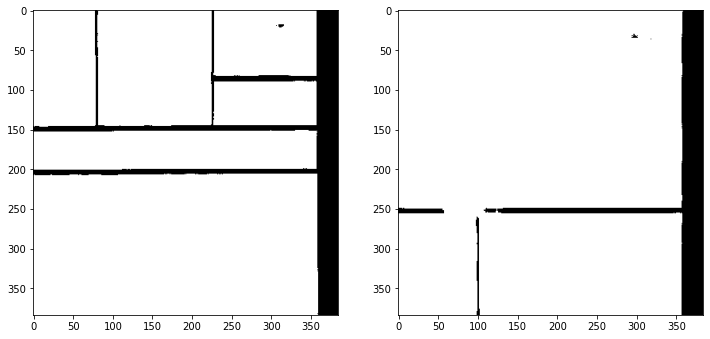

In [15]:
# image_path_1 = 'pred_mask_raw/pred_mask_raw_18-Copy1.png'
image_path_1 = 'pred_mask_raw/pred_mask_raw_36-Copy1.png'  #62,34

image_path_2 = 'pred_mask_raw/pred_mask_raw_53-Copy1.png'
image1, image2 = cv2.imread(image_path_1, cv2.IMREAD_GRAYSCALE), cv2.imread(image_path_2, cv2.IMREAD_GRAYSCALE)
# image1 = np.array(image1)
# image2 = np.array(image2)
image1 = np.array(image1)
image2 = np.array(image2)

plot_images(image1, image2)

In [16]:
#     def inverte(imagem):
#         imagem = (255-imagem)
#         return imagem

#     # remove irrelevant chunks
#     inv_smo1 = inverte(image1)
#     smoothed_1 = test_func(inv_smo1)
#     smoothed_1 = inverte(smoothed_1)
#     smoothed_1 = np.uint8(smoothed_1)
#     smoothed_1 = smooth_edges(smoothed_1)

In [17]:
# smoothed_1 = smooth_edges(image1)
# smoothed_2 = smooth_edges(image2)
# plot_images(smoothed_1,smoothed_2)

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
def inverte(imagem):
    imagem = (255-imagem)
    return imagem



# inv_smo1 = inverte(smoothed_1)
# print(inv_smo1)
# plt.imshow(inv_smo1)
def separate_black_blocks(image): 
    '''to remove separated irrelevant parts'''
    num_labels, labels = cv2.connectedComponents(image)
    
    output_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    
    # Random colors for each block (for visualization)
    colors = np.random.randint(0, 255, size=(num_labels, 3), dtype=np.uint8)
    
    # Visualize the separated blocks
    for label in range(1, num_labels):  # Skip label 0, which is the background
        output_image[labels == label] = colors[label]  # Color the connected blocks
    
    return output_image, labels,num_labels


inv_smo1 = inverte(image1)

In [19]:
# output_image, labels ,num_labels= separate_black_blocks(inv_smo1)

In [20]:
# plot_images1(output_image)

In [21]:
# for i in range(1,num_labels):
#         array_copy = np.copy(labels)
#         array_copy[array_copy != i] = 0
#         array_copy = np.uint8(array_copy)
#         contours, _ = cv2.findContours(array_copy
#                                        , cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         plt.figure()
#         plt.imshow(array_copy)
#         for contour in contours:
#             area = cv2.contourArea(contour)
#             length = cv2.arcLength(contour, True)
#         plt.title(f'{area} and {length}')

In [74]:

def test_func(inv_smo1):
    keep_list = []

    output_image, labels ,num_labels= separate_black_blocks(inv_smo1)
    for i in range(1,num_labels):
        array_copy = np.copy(labels)
        array_copy[array_copy != i] = 0
        



        array_copy = np.uint8(array_copy)
        contours, _ = cv2.findContours(array_copy
                                       , cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Set your area threshold
        ####### 
        ######## adjust here
        ########
        area_threshold = 120 # old 120
        length_threshold = 120 #old 120
        
        ###### no more adjustment from here
        
        
        
        # Create a blank mask to draw filtered contours
        filtered_img = np.zeros_like(inv_smo1)
        for contour in contours:
            area = cv2.contourArea(contour)
            length = cv2.arcLength(contour, True)
            if area > area_threshold and length > length_threshold:
                keep_list.append(i)
                
                
                
    result = np.isin(labels, keep_list).astype(int)
    result[result == 1] = 255
    return result

# print(inv_smo1)
# plt.imshow(inv_smo1)

# siuuu = test_func(inv_smo1)
# siuuu = 255 - siuuu
# plt.figure(figsize  = (30,30))
# plt.imshow(siuuu)

In [23]:
# from skimage.feature import canny
# edges_1 = cv2.Canny(np.uint8(siuuu), threshold1=50, threshold2=100)
# edges_2 = cv2.Canny(smoothed_2, threshold1=50, threshold2=100)

# plot_images(edges_1, edges_2)

In [24]:
# testing_1 = morphing(edges_1)
# testing_2 = morphing(edges_2)
# plot_images(testing_1, testing_2)

In [25]:
# lines1 = cv2.HoughLinesP(testing_1, 2, np.pi/180, threshold=25, 
#                             minLineLength=10, maxLineGap=30) #old minlength 10, gap 30
# lines2 = cv2.HoughLinesP(testing_2, 2, np.pi/180, threshold=25, 
#                             minLineLength=10, maxLineGap=30)

NameError: name 'testing_1' is not defined

In [ ]:
# hough_1 = create_image_with_hough_lines(testing_1, lines1, is_binary=False)
# hough_2 = create_image_with_hough_lines(testing_2, lines2, is_binary=False)
# plot_images(hough_1, hough_2)

In [ ]:
# hough_1_straight = cv2.morphologyEx(hough_1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)))
# plot_images(hough_1_straight, hough_2)

In [ ]:
# border_lines = get_border_lines(hough_2.shape)

In [ ]:
# vertical_lines1, horizontal_lines1 = classify_line(lines1)
# vertical_lines2, horizontal_lines2 = classify_line(lines2)
# hough_classified1 = create_image_with_classified_lines(image1, vertical_lines1, horizontal_lines1)
# hough_classified2 = create_image_with_classified_lines(image2, vertical_lines2, horizontal_lines2)
# plot_images1(hough_classified1)

In [ ]:
# print(len(vertical_lines1))
# len(horizontal_lines1)

In [ ]:
# for j in range( 1, len(vertical_lines1)):  
#     print('pair')
#     print(f'angle: {vertical_lines1[0].cross_angle(vertical_lines1[j])}' )
#     print(f'angle: {vertical_lines1[j].cross_angle(vertical_lines1[0])}' )
#     print(f'dis  : {vertical_lines1[0].list_dis}' )
#     print(f'dis  : {vertical_lines1[j].list_dis}' )
#     print(f'dis diff  : {np.array(vertical_lines1[0].list_dis) - np.array(vertical_lines1[j].list_dis)}' )
    
    

In [ ]:
# for j in range( 1, len(horizontal_lines1)):  
#     print('pair')
#     print(f'angle: {horizontal_lines1[0].cross_angle(horizontal_lines1[j])}' )
#     print(f'angle: {horizontal_lines1[j].cross_angle(horizontal_lines1[0])}' )
#     print(f'dis  : {horizontal_lines1[0].list_dis}' )
#     print(f'dis  : {horizontal_lines1[j].list_dis}' )
#     print(f'dis diff  : {np.array(horizontal_lines1[0].list_dis) - np.array(horizontal_lines1[j].list_dis)}' )
    
    

In [78]:
def group_line_and_outlier(horizontal_lines1):
    
    line_groups = []

    for i in range(len(horizontal_lines1)):
        
        group = [horizontal_lines1[i]] 
#         group = [i] 
        
        for j in range(i + 1, len(horizontal_lines1)):  
            diff_angle = horizontal_lines1[i].cross_angle(horizontal_lines1[j])
    #         print(f'angle: {horizontal_lines1[j].cross_angle(horizontal_lines1[0])}' )
    #         print(f'dis  : {horizontal_lines1[0].list_dis}' )
    #         print(f'dis  : {horizontal_lines1[j].list_dis}' )
            diff_dis = np.array(horizontal_lines1[i].list_dis) - np.array(horizontal_lines1[j].list_dis)
            
            
            
            #####################
            result_angle = (diff_angle < 3) or (diff_angle > 177)
            result_dis = np.all(np.abs(diff_dis) < 10) #old 8
            
            
            
            ###########
            if result_angle and result_dis:
                group.append(horizontal_lines1[j])
#                 group.append(j)
                
            
        if len(group) >= 1:
            line_groups.append(group)
            
#     print(line_groups)
    return line_groups

In [ ]:
# output_test_hor  = group_line_and_outlier(horizontal_lines1)
# output_test_ver  = group_line_and_outlier(vertical_lines1)

In [27]:
import numpy as np

def rotate_line_around_center(point_a, point_b, desired_angle_degrees):
    # Convert points to numpy arrays
    point_a = np.array(point_a)
    point_b = np.array(point_b)
    
    # Find the midpoint of the line
    midpoint = (point_a + point_b) / 2
    
    # Translate points A and B to the origin (midpoint is at the origin)
    point_a_translated = point_a - midpoint
    point_b_translated = point_b - midpoint
    
    # Convert desired angle to radians
    angle_radians = np.radians(desired_angle_degrees)
    
    # Rotation matrix
    cos_theta, sin_theta = np.cos(angle_radians), np.sin(angle_radians)
    rotation_matrix = np.array([
        [cos_theta, -sin_theta],
        [sin_theta, cos_theta]
    ])
    
    # Apply rotation to the translated points
    point_a_rotated = np.dot(rotation_matrix, point_a_translated)
    point_b_rotated = np.dot(rotation_matrix, point_b_translated)
    
    # Translate the points back by adding the midpoint
    point_a_rotated += midpoint
    point_b_rotated += midpoint
    
    return point_a_rotated, point_b_rotated

# Example usage
point_a = (1, 2)
point_b = (4, 5)
new_a, new_b = rotate_line_around_center(point_a, point_b, 20)
print("New Point A:", new_a)
print("New Point B:", new_b)


New Point A: [1.60349128 1.57743085]
New Point B: [3.39650872 5.42256915]


In [66]:
def rotate_line_around_center(line_obj, desired_angle_degrees):  ## lấy desired angle là góc hiện tại trừ take[0] 
    # Convert points to numpy arrays
    
    point_a = np.array([line_obj.x1, line_obj.y1])
    point_b = np.array([line_obj.x2, line_obj.y2])
    
    # Find the midpoint of the line
    midpoint = (point_a + point_b) / 2
    
    # Translate points A and B to the origin (midpoint is at the origin)
    point_a_translated = point_a - midpoint
    point_b_translated = point_b - midpoint
    
    # Convert desired angle to radians
    angle_radians = np.radians(desired_angle_degrees)
    
    # Rotation matrix
    cos_theta, sin_theta = np.cos(angle_radians), np.sin(angle_radians)
    rotation_matrix = np.array([
        [cos_theta, -sin_theta],
        [sin_theta, cos_theta]
    ])
    
    # Apply rotation to the translated points
    point_a_rotated = np.dot(rotation_matrix, point_a_translated)
    point_b_rotated = np.dot(rotation_matrix, point_b_translated)
    
    # Translate the points back by adding the midpoint
    point_a_rotated += midpoint
    point_b_rotated += midpoint
#     print('here')
#     print(point_a_rotated)
#     print('here')
    
#     print(point_b_rotated)
    
    line_obj.x1 = point_a_rotated[0]
    line_obj.y1 = point_a_rotated[1]
    line_obj.x2 = point_b_rotated[0]
    line_obj.y2 = point_b_rotated[1]
    return line_obj


# cos thể lỗi ở 180 độ

def merge_lists_with_common_line(list_of_lists1):
    merged = []
    list_of_lists = list_of_lists1.copy()
    while list_of_lists:
        current_list = list_of_lists.pop(0)
        
        i = 0
        while i < len(list_of_lists):
            # Check if any lines in current_list appear in any of the remaining lists
            common_line_found = False
            for line in current_list:
                if line in list_of_lists[i]:
                    common_line_found = True
                    break
            
            # If there is a common line, merge the lists
            if common_line_found:
                current_list.extend(list_of_lists.pop(i))
            else:
                i += 1
        
        # Add the merged list to the result list (ensuring no duplicates)
        merged.append(list(set(current_list)))
#     print(merged)
    
    
    # remove part
    final_merged = []
    for listnay in merged:
        dict = {}
        for i in listnay:
            dict[i] = i.calculate_angle()
            
#         print(list(dict.values()))
#         print(dict)
        take = mode(list(dict.values()))
        if take[1] >= 2:
            get_the_list = [k for k, v in dict.items() if v == take[0]]
            not_the_list = [k for k, v in dict.items() if v != take[0]]
            synthetic_list = get_the_list[:] 
            for line_obj in not_the_list:
                new_line_obj = rotate_line_around_center(line_obj, take[0] - line_obj.calculate_angle_of_range_plusminus_90() )
#                 print(f'old {new_line_obj.x2}')
#                 print(new_line_obj.y2)
# #                 line_obj.x2 = newx2
# #                 line_obj.y2 = newy2
#                 print(f'new {new_line_obj.x2}')
#                 print(new_line_obj.y2) 
                synthetic_list.append(new_line_obj)
                            
            
            
            final_merged.extend(synthetic_list)

        else:

            
            values = list(dict.values())  
            sorted_values = sorted(values)  
            n = len(sorted_values)
            median_value = sorted_values[n // 2]

            # Find the keys that correspond to the median value
            get_object = [k for k, v in dict.items() if v == median_value]
            not_the_list = [k for k, v in dict.items() if v == median_value]
            
            
            synthetic_list = get_object[:] 
            for line_obj in not_the_list:
                new_line_obj = rotate_line_around_center(line_obj,take[0] - line_obj.calculate_angle_of_range_plusminus_90() )
#                 print(f'old {new_line_obj.x2}')
#                 print(new_line_obj.y2)
#                 line_obj.x2 = newx2
#                 line_obj.y2 = newy2
#                 print(f'new {new_line_obj.x2}')
#                 print(new_line_obj.y2) 
                synthetic_list.append(new_line_obj)
                
            
            final_merged.extend(synthetic_list)

            
    
    
    return final_merged





# def merge_lists_with_common_line(list_of_lists1):
#     merged = []
#     list_of_lists = list_of_lists1.copy()
#     while list_of_lists:
#         current_list = list_of_lists.pop(0)
        
#         i = 0
#         while i < len(list_of_lists):
#             # Check if any lines in current_list appear in any of the remaining lists
#             common_line_found = False
#             for line in current_list:
#                 if line in list_of_lists[i]:
#                     common_line_found = True
#                     break
            
#             # If there is a common line, merge the lists
#             if common_line_found:
#                 current_list.extend(list_of_lists.pop(i))
#             else:
#                 i += 1
        
#         # Add the merged list to the result list (ensuring no duplicates)
#         merged.append(list(set(current_list)))
# #     print(merged)
    
    
#     # remove part
#     final_merged = []
#     for listnay in merged:
#         dict = {}
#         for i in listnay:
#             dict[i] = i.calculate_angle()
            
# #         print(list(dict.values()))
# #         print(dict)
#         take = mode(list(dict.values()))
#         if take[1] >= 2:
#             get_the_list = [k for k, v in dict.items() if v == take[0]]
#             not_the_list = [k for k, v in dict.items() if v != take[0]]
#             synthetic_list = get_the_list[:] 
            
            
            
#             final_merged.extend(synthetic_list)

#         else:

            
#             values = list(dict.values())  
#             sorted_values = sorted(values)  
#             n = len(sorted_values)
#             median_value = sorted_values[n // 2]

#             # Find the keys that correspond to the median value
#             get_object = [k for k, v in dict.items() if v == median_value]
#             synthetic_list = get_object[:] 

            
#             final_merged.extend(synthetic_list)

            
    
    
#     return final_merged
# final_merged_list_hor = merge_lists_with_common_line(output_test_hor)
# print('\n')
# final_merged_list_ver = merge_lists_with_common_line(output_test_ver)

In [ ]:
#     hough_classified1 = create_image_with_classified_lines(testing_1,final_merged_list_ver, final_merged_list_hor)


In [ ]:
# intersections1 = find_intersection(final_merged_list_ver, final_merged_list_hor)
# vertical_border1 = [point for point in find_intersection(final_merged_list_ver, border_lines) if point is not None and all(0 <= coord <= 400 for coord in point)]
# horizontal_border1 = [point for point in find_intersection(final_merged_list_hor, border_lines) if point is not None and all(0 <= coord <= 400 for coord in point)]

# # intersections2 = find_intersection(vertical_lines2, horizontal_lines2)
# # vertical_border2 = [point for point in find_intersection(vertical_lines2, border_lines) if point is not None and all(0 <= coord <= 400 for coord in point)]
# # horizontal_border2 = [point for point in find_intersection(horizontal_lines2, border_lines) if point is not None and all(0 <= coord <= 400 for coord in point)]

# # for point in intersections1: 
# #         temp_1 = cv2.circle(hough_classified1, (point[0], point[1]), 2, (0,255,0), -1)
# # for point in intersections2: 
# #         temp_2 =cv2.circle(hough_classified2, (point[0], point[1]), 2, (0,255,0), -1)
# # plot_images(hough_classified1, hough_classified2)

In [ ]:
# intersections_full1 = np.array(intersections1 + vertical_border1 + horizontal_border1)
# # intersections_full2 = np.array(intersections2 + vertical_border2 + horizontal_border2)
# border_inter1 = np.array( vertical_border1 + horizontal_border1)
# # border_inter2 = np.array( vertical_border2 + horizontal_border2)
# # 
# intersections1 = np.array(intersections1)
# # intersections2 = np.array(intersections2)



In [ ]:
# # mean_shift_inner = MeanShift(bandwidth=25)  
# # labels = mean_shift_inner.fit_predict(intersections_full1)
# # centroids = mean_shift_inner.cluster_centers_
# if len(intersections1) > 0:
#     mean_shift_inner = MeanShift(bandwidth=15)  
#     labels_inner = mean_shift_inner.fit_predict(intersections1)
#     centroids_inner = mean_shift_inner.cluster_centers_
# else: 
#     centroids_inner = np.array([])
#     centroids_inner = centroids_inner.reshape(0, 2)
#     labels_inner = np.array([])

# mean_shift_border = MeanShift(bandwidth=10)  
# labels_border = mean_shift_border.fit_predict(border_inter1)
# centroids_border = mean_shift_border.cluster_centers_

# labels = np.concatenate([labels_inner,labels_border + 200])
# centroids = np.concatenate([centroids_inner, centroids_border],axis = 0)
# plt.figure(figsize=(8, 8))
# unique_clusters = set(labels)

# plt.imshow(hough_classified1)

# for cluster in unique_clusters:
#     if cluster == -1: 
#         continue
#     mask = labels == cluster
#     cluster_points = intersections_full1[mask]  
#     color = np.random.rand(3,)  
#     plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[color], label=f"Cluster {cluster}")


# plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=100, label='Centroids')

# plt.gca().invert_yaxis()
# plt.title("Mean Shift Clustering with Centroids")
# plt.show()


In [ ]:
# for centroid in centroids:
#     x, y = int(centroid[0]), int(centroid[1])
#     intersections1_clustered = cv2.drawMarker(
#         hough_classified1,
#         (x, y),
#         color=(255, 255, 255),  
#         markerType=cv2.MARKER_CROSS, 
#         markerSize=7, 
#         thickness=2
#     )
# plt.figure(figsize=(8, 8))
# plt.axis('off')
# plt.imshow(intersections1_clustered)

----
### Cook phần nối điểm

In [29]:
def bresenham(x1, y1, x2, y2):
    points = []
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x2 > x1 else -1
    sy = 1 if y2 > y1 else -1
    err = dx - dy

    while True:
        points.append((x1, y1))
        if x1 == x2 and y1 == y2:
            break
        e2 = err * 2
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy

    return points

In [238]:
def is_connection_valid(image, x1, y1, x2, y2, threshold=0.79): #old 75 ,81 khá ổn
    line_points = bresenham(x1, y1, x2, y2)
    colored_count = 0

    for x, y in line_points:
        if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:  
            if np.any(image[y, x] > 20):  
                colored_count += 1

    return (colored_count / len(line_points)) >= threshold

In [ ]:
# image1copy = close(hough_classified1)

# plt.imshow(image1copy)

In [87]:
def close(image):
    # gaussian_ksize = (7, 7) 
    
    dilation_kernel_1 = np.ones((3, 3), np.uint8)
    erosion_kernel_1 = np.ones((5, 1), np.uint8) #old (5,1) 23/12 4:49 pm
    dilated_image = cv2.dilate(image, dilation_kernel_1, iterations=1)
    eroded_image_2 = cv2.erode(dilated_image, erosion_kernel_1, iterations=1)
    #dilated_image_2 = cv2.dilate(eroded_image_2, dilation_kernel_2, iterations=1)
#     processed_image = cv2.erode(eroded_image_2, erosion_kernel_2, iterations=1)
    
    return eroded_image_2

In [84]:
def overfit_close(image):
    dilation_kernel_1 = np.ones((3, 3), np.uint8)
    erosion_kernel_1 = np.ones((3, 3), np.uint8) #old (5,1) 23/12 4:49 pm
    
    eroded_image_2 = cv2.erode(image, erosion_kernel_1, iterations=2)
    dilated_image = cv2.dilate(eroded_image_2, dilation_kernel_1, iterations=2)
    return dilated_image
    

In [ ]:
# centroids

In [286]:
# def draw_centroid_connection(hough_classified1,centroids):
#     image1copy = close(hough_classified1)

#     for i, point1 in enumerate(centroids):
#         for j, point2 in enumerate(centroids):
#             if i != j:  
#                 x1, y1 = int(point1[0]), int(point1[1])
#                 x2, y2 = int(point2[0]), int(point2[1])

#                 if is_connection_valid(image1copy, x1, y1, x2, y2):
#                     cv2.line(
#                         image1copy,
#                         (x1, y1),
#                         (x2, y2),
#                         color=(0, 255, 0), 
#                         thickness=2
#                     )
                    
                    
                    
                

#     plt.figure(figsize=(8, 8))
#     plt.axis('off')
#     plt.imshow(image1copy,cmap = 'gray') 
#     plt.show()


def draw_centroid_connection(hough_classified1,image1,centroids,connection_threshold):
#     image1copy = close(hough_classified1)
    image1copy = hough_classified1
    valid_connections = []
    ve_len = image1
    for i, point1 in enumerate(centroids):
        for j, point2 in enumerate(centroids):
            if i != j:  
                x1, y1 = int(point1[0]), int(point1[1])
                x2, y2 = int(point2[0]), int(point2[1])
            
                if is_connection_valid(image1copy, x1, y1, x2, y2,connection_threshold):
                    if np.sqrt((x1-x2)**2 + (y1-y2)**2) > 40:
                        cv2.line(ve_len, (x1, y1), (x2, y2), (0), 2) 
                  
    ve_len = overfit_close(ve_len)
#     plt.figure(figsize=(8, 8))
#     plt.title('on binary mask')
#     plt.axis('off')
#     plt.imshow(ve_len,cmap = 'gray') 
#     plt.show()
    return ve_len


In [ ]:
plt.imshow(image1)

In [ ]:
# hough_classified1.shape

laasy toạ độ
hạ threshold


In [ ]:
# for i, point1 in enumerate(centroids):
#     for j, point2 in enumerate(centroids):
#         if i != j:  
#             cv2.line(
#                 intersections1_clustered,
#                 (int(point1[0]), int(point1[1])),
#                 (int(point2[0]), int(point2[1])),
#                 color=(0, 255, 0),  
#                 thickness=1
#             )
# plt.figure(figsize=(8, 8))
# plt.axis('off')
# plt.imshow(intersections1_clustered) 
# plt.show()

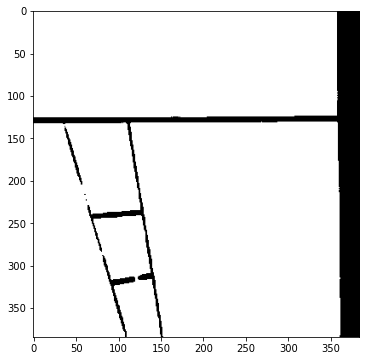

<Figure size 576x576 with 0 Axes>

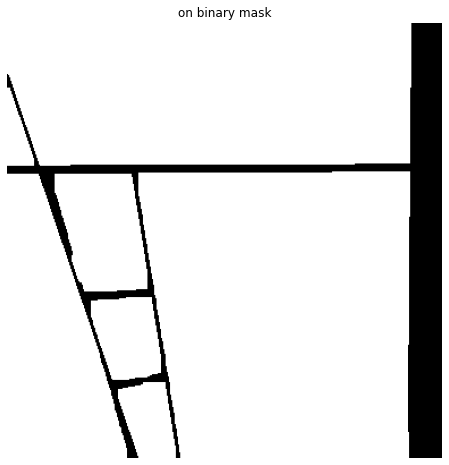

In [188]:
   
    image_path_1 = 'pred_mask_raw/pred_mask_raw_19-Copy1.png'
    image1 = cv2.imread(image_path_1, cv2.IMREAD_GRAYSCALE)
    
    
    def inverte(imagem):
        imagem = (255-imagem)
        return imagem

#     remove irrelevant chunks
    inv_smo1 = inverte(image1)
    test_func_img = test_func(inv_smo1)
    test_func_img = inverte(test_func_img)
    test_func_img = np.uint8(test_func_img)
    test_func_img_copy = test_func_img.copy()
    test_func_img = smooth_edges(test_func_img)
    smoothed_1 = smooth_edges(image1)
    
    
    
    #get hough, get lines, get intersections
    edges_1 = cv2.Canny(smoothed_1, threshold1=50, threshold2=100)
    
    testing_1 = morphing(edges_1)
    lines1 = cv2.HoughLinesP(testing_1, 2, np.pi/180, threshold=25, 
                            minLineLength=10, maxLineGap=30) #old length 10
        # get all lines
    
    vertical_lines1, horizontal_lines1 = classify_line(lines1)
        # grouping lines that can be merged into 1
    output_test_hor  = group_line_and_outlier(horizontal_lines1)
    output_test_ver  = group_line_and_outlier(vertical_lines1)
#     print('for hor')
    final_merged_list_hor = merge_lists_with_common_line(output_test_hor)
#     print('for ver')
    final_merged_list_ver = merge_lists_with_common_line(output_test_ver)
    allies = final_merged_list_hor + final_merged_list_ver
    
    hough_1 = create_image_with_hough_lines(testing_1, allies, is_binary=False)
    hough_1_straight = cv2.morphologyEx(hough_1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)))
    hough_classified1 = create_image_with_classified_lines(testing_1, vertical_lines1, horizontal_lines1)
    

    border_lines = get_border_lines(hough_1.shape)

#     return final_merged_list_hor, final_merged_list_ver, border_lines

    #get all intersections
    intersections1 = find_intersection(final_merged_list_ver, final_merged_list_hor)
    vertical_border1 = [point for point in find_intersection(final_merged_list_ver, border_lines) if point is not None and all(0 <= coord <= 400 for coord in point)]
    horizontal_border1 = [point for point in find_intersection(final_merged_list_hor, border_lines) if point is not None and all(0 <= coord <= 400 for coord in point)]

    
    intersections_full1 = np.array(intersections1 + vertical_border1 + horizontal_border1)
    border_inter1 = np.array( vertical_border1 + horizontal_border1)
    intersections1 = np.array(intersections1)


    
    plot_images1(image1)
#     plot_images1(testing_1)
#     plot_images1(hough_1)
#     plot_images1(hough_1_straight)
#     plot_images1(hough_classified1)
    
    
    #get centroids
    if len(intersections1) > 0:
        mean_shift_inner = MeanShift(bandwidth=13)  
        labels_inner = mean_shift_inner.fit_predict(intersections1)
        centroids_inner = mean_shift_inner.cluster_centers_
    else: 
        centroids_inner = np.array([])
        centroids_inner = centroids_inner.reshape(0, 2)
        labels_inner = np.array([])

    mean_shift_border = MeanShift(bandwidth=10)  
    labels_border = mean_shift_border.fit_predict(border_inter1)
    centroids_border = mean_shift_border.cluster_centers_

    labels = np.concatenate((labels_inner,labels_border + 200))
    centroids = np.concatenate((centroids_inner, centroids_border))
    
    
    plt.figure(figsize=(8, 8))
    unique_clusters = set(labels)
    
#     plot_images1(hough_classified1)

    for cluster in unique_clusters:
        if cluster == -1: 
            continue
        mask = labels == cluster
        cluster_points = intersections_full1[mask]  
        color = np.random.rand(3,)  
#         plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[color], label=f"Cluster {cluster}")


#     plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=100, label='Centroids')

#     plt.gca().invert_yaxis()
#     plt.title(f"Mean Shift Clustering with Centroids of {image_path_1}")
#     plt.show()

    
    
    for centroid in centroids:
        x, y = int(centroid[0]), int(centroid[1])
        intersections1_clustered = cv2.drawMarker(
            hough_classified1,
            (x, y),
            color=(255, 255, 255),  
            markerType=cv2.MARKER_CROSS, 
            markerSize=7, 
            thickness=2
            )
#     plt.figure(figsize=(8, 8))
#     plt.axis('off')
#     plt.title(f"hough with Centroids of {image_path_1}")
    
#     plt.imshow(intersections1_clustered)
    
    
    ve_len  = draw_centroid_connection(hough_classified1,test_func_img,centroids)
    
    
#     print(result)

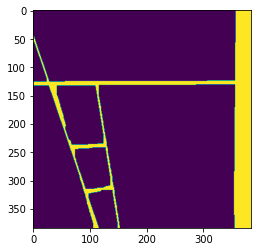

In [189]:
ve_len_inv = inverte(ve_len)
bruh,labels,num_labels = separate_black_blocks(ve_len)
plt.imshow(ve_len_inv)

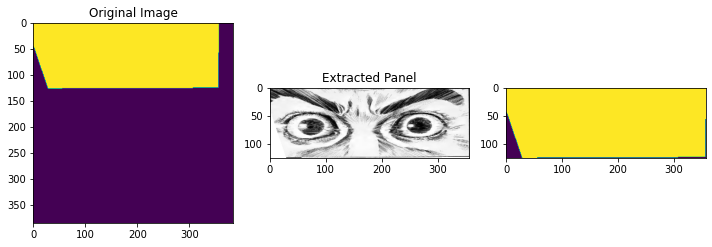

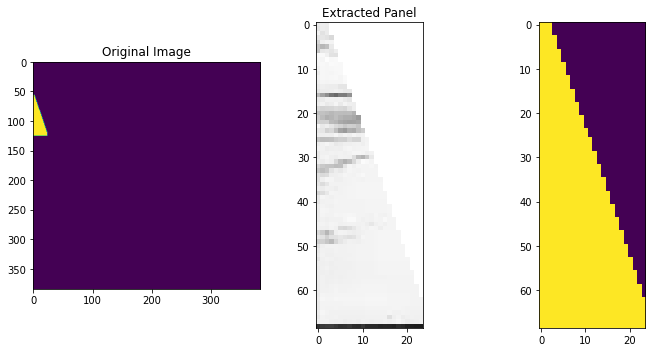

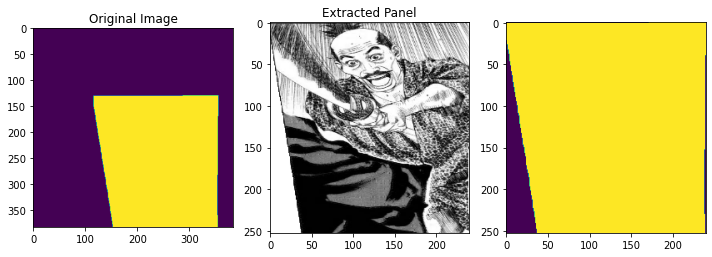

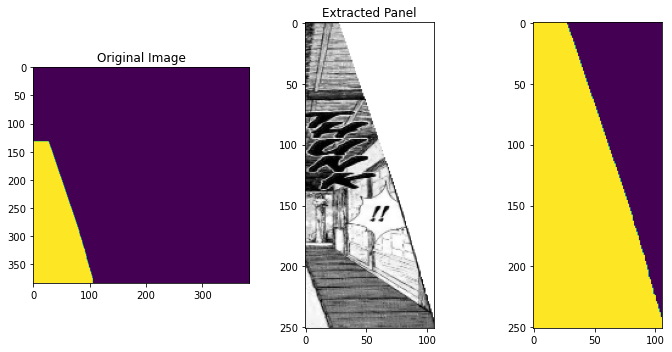

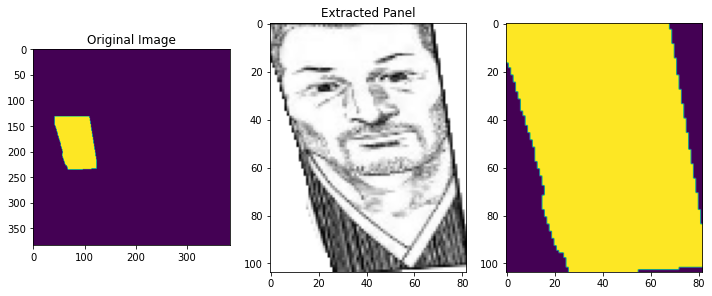

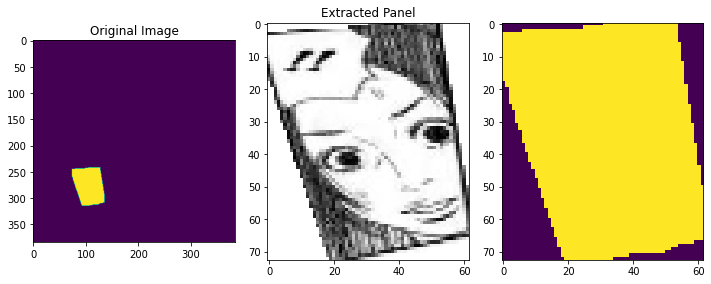

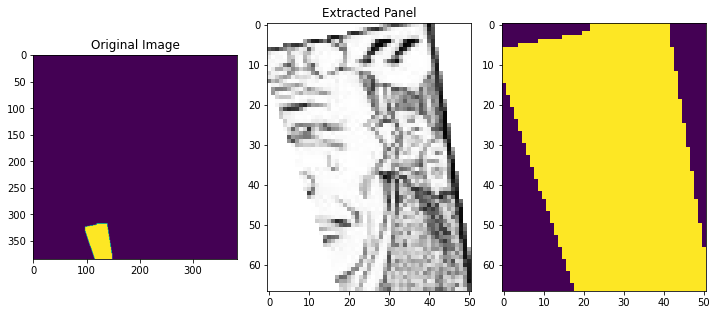

In [220]:
for i in range(1,num_labels):
        array_copy = np.copy(labels)
        array_copy[array_copy != i] = 0
        array_copy = np.uint8(array_copy)
#         print('aray copy')
#         print(array_copy)
        fig, axes = plt.subplots(1, 3, figsize=(10, 5))

        # First subplot: display array_copy
        axes[0].imshow(array_copy)
        axes[0].set_title('Original Image')

        # Second subplot: display the result from extract_each_panel
        hehehe,mask = extract_each_panel('img/img_19.png', array_copy)
        axes[1].imshow(hehehe)
        axes[1].set_title('Extracted Panel')
    
    
        axes[2].imshow(mask)
        # Show the plots
        plt.tight_layout()
        plt.show()
        


In [211]:
for row,bruh in enumerate(hehehe):
    for col,bruhee in enumerate(i):
        if mask[row,col] == 0:
            hehehe[row,col] = 0

In [219]:
def extract_each_panel(image_path,mask):
    image = cv2.imread(image_path)  
    image = np.uint8(image)
    mf, binary_mask = cv2.threshold(mask, 0.9, 255, cv2.THRESH_BINARY)

#     print(binary_mask)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Assuming there's only one contour, use the largest one
    largest_contour = max(contours, key=cv2.contourArea)

    # Create a blank mask to draw the polygon
    polygon_mask = np.zeros_like(binary_mask)

    # Fill the polygon in the mask
    cv2.fillPoly(polygon_mask, [largest_contour], color=255)

    result = cv2.bitwise_and(image, image, mask=polygon_mask)
    ######
    #####
    x, y, w, h = cv2.boundingRect(polygon_mask)  
#     print(x,y,w,h)
    cropped_result = image[y:y+h, x:x+w]
    mask_segment = polygon_mask[y:y+h, x:x+w]
    for row,bruh in enumerate(cropped_result):
        for col,bruhee in enumerate(bruh):
            if mask_segment[row,col] == 0:
                cropped_result[row,col] = 255
#     print(cropped_result)
#     print(cropped_result.shape)
    
    return cropped_result,mask_segment


In [ ]:
extract_each_panel('img/img_35.png',array_copy)

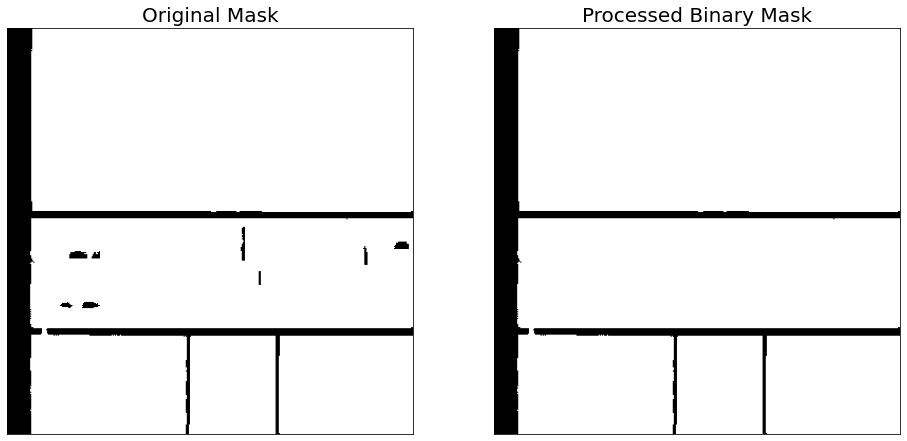

In [185]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))


axes[0].imshow(image1, cmap='gray')
axes[0].set_title('Original Mask', fontsize=20)
axes[0].set_xticks([]) 
axes[0].set_yticks([])  

axes[1].imshow(test_func_img_copy, cmap='gray')
axes[1].set_title('Processed Binary Mask', fontsize=20)
axes[1].set_xticks([])  # Remove x-axis ticks for the second subplot
axes[1].set_yticks([])  # Remove y-axis ticks for the second subplot



plt.show()

In [ ]:
plt.imshow(smoothed_1)

In [296]:
from skimage.feature import canny
def full_cock(image_path_1,save_folder_name,connection_threshold):
    # get smoothed image
    image1 = cv2.imread(image_path_1, cv2.IMREAD_GRAYSCALE)
    
    
    def inverte(imagem):
        imagem = (255-imagem)
        return imagem

#     remove irrelevant chunks
    inv_smo1 = inverte(image1)
    test_func_img = test_func(inv_smo1)
    test_func_img = inverte(test_func_img)
    test_func_img = np.uint8(test_func_img)
    test_func_img = smooth_edges(test_func_img)
    smoothed_1 = smooth_edges(image1)
    
    
    
    #get hough, get lines, get intersections
    edges_1 = cv2.Canny(smoothed_1, threshold1=50, threshold2=100)
    
    testing_1 = morphing(edges_1)
    lines1 = cv2.HoughLinesP(testing_1, 2, np.pi/180, threshold=25, 
                            minLineLength=10, maxLineGap=30) #old length 10
        # get all lines
    
    vertical_lines1, horizontal_lines1 = classify_line(lines1)
        # grouping lines that can be merged into 1
    output_test_hor  = group_line_and_outlier(horizontal_lines1)
    output_test_ver  = group_line_and_outlier(vertical_lines1)
#     print('for hor')
    final_merged_list_hor = merge_lists_with_common_line(output_test_hor)
#     print('for ver')
    final_merged_list_ver = merge_lists_with_common_line(output_test_ver)
    allies = final_merged_list_hor + final_merged_list_ver
    
    hough_1 = create_image_with_hough_lines(testing_1, allies, is_binary=False)
    hough_1_straight = cv2.morphologyEx(hough_1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)))
    hough_classified1 = create_image_with_classified_lines(testing_1, vertical_lines1, horizontal_lines1)
    

    border_lines = get_border_lines(hough_1.shape)

#     return final_merged_list_hor, final_merged_list_ver, border_lines

    #get all intersections
    intersections1 = find_intersection(final_merged_list_ver, final_merged_list_hor)
    vertical_border1 = [point for point in find_intersection(final_merged_list_ver, border_lines) if point is not None and all(0 <= coord <= 400 for coord in point)]
    horizontal_border1 = [point for point in find_intersection(final_merged_list_hor, border_lines) if point is not None and all(0 <= coord <= 400 for coord in point)]

    
    intersections_full1 = np.array(intersections1 + vertical_border1 + horizontal_border1)
    border_inter1 = np.array( vertical_border1 + horizontal_border1)
    intersections1 = np.array(intersections1)


    
#     plot_images1(image1)
#     plot_images1(testing_1)
#     plot_images1(hough_1)
#     plot_images1(hough_1_straight)
#     plot_images1(hough_classified1)
    
    
    #get centroids
    if len(intersections1) > 0:
        mean_shift_inner = MeanShift(bandwidth=11) #old 13 zx  
        labels_inner = mean_shift_inner.fit_predict(intersections1)
        centroids_inner = mean_shift_inner.cluster_centers_
    else: 
        centroids_inner = np.array([])
        centroids_inner = centroids_inner.reshape(0, 2)
        labels_inner = np.array([])

    mean_shift_border = MeanShift(bandwidth=10)  
    labels_border = mean_shift_border.fit_predict(border_inter1)
    centroids_border = mean_shift_border.cluster_centers_

    labels = np.concatenate((labels_inner,labels_border + 200))
    centroids = np.concatenate((centroids_inner, centroids_border))
    
    
    plt.figure(figsize=(8, 8))
    unique_clusters = set(labels)
    
#     plot_images1(hough_classified1)

    for cluster in unique_clusters:
        if cluster == -1: 
            continue
        mask = labels == cluster
        cluster_points = intersections_full1[mask]  
        color = np.random.rand(3,)  
#         plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[color], label=f"Cluster {cluster}")


#     plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=100, label='Centroids')

#     plt.gca().invert_yaxis()
#     plt.title(f"Mean Shift Clustering with Centroids of {image_path_1}")
#     plt.show()

    
    
    for centroid in centroids:
        x, y = int(centroid[0]), int(centroid[1])
        intersections1_clustered = cv2.drawMarker(
            hough_classified1,
            (x, y),
            color=(255, 255, 255),  
            markerType=cv2.MARKER_CROSS, 
            markerSize=7, 
            thickness=2
            )
#     plt.figure(figsize=(8, 8))
#     plt.axis('off')
#     plt.title(f"hough with Centroids of {image_path_1}")
    
#     plt.imshow(intersections1_clustered)
    
    
    ve_len  = draw_centroid_connection(hough_classified1,test_func_img,centroids,connection_threshold)
    
    if not os.path.exists(save_folder_name):
        os.makedirs(save_folder_name)

    # Path to save the image
    save_path = os.path.join(save_folder_name, image_path_1.split('/')[-1])
    

    if ve_len is not None:
        # Save the image to the specified folder
        cv2.imwrite(save_path, ve_len)
        print(f"Image saved to {save_path}")
    else:
        print(f"dcm code lỗi r ở ảnh {image_path_1}")
    
 
    
    
#     for centroid in centroids:
#         x, y = int(centroid[0]), int(centroid[1])
#         intersections1_clustered = cv2.drawMarker(
#             hough_1_straight,
#             (x, y),
#             color=(255, 0, 255),  
#             markerType=cv2.MARKER_CROSS, 
#             markerSize=7, 
#             thickness=2
#             )
#     plt.figure(figsize=(8, 8))
#     plt.axis('off')
#     plt.imshow(intersections1_clustered)
#     return centroids, intersections1_clustered

# list1 = {}
# dir = 'pred_mask_raw'
# for file in os.listdir('pred_mask_raw'):
#     path = f'{dir}/{file}'
#     list1[file]  = full_cock(path)
    
# print(len(list1))

    
    

1 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_20.png


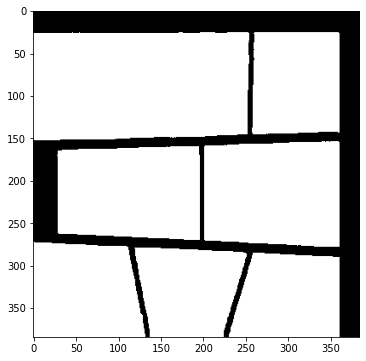

<Figure size 576x576 with 0 Axes>

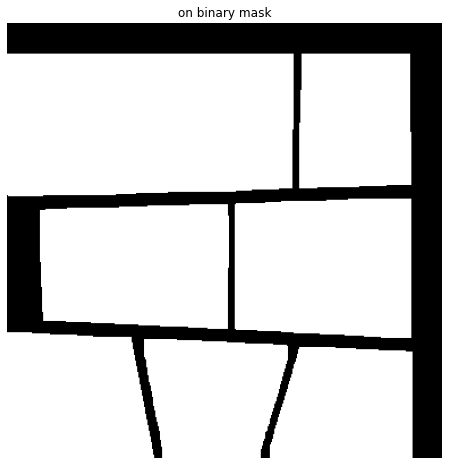

Image saved to post_process_mixed/pred_mask_raw_20.png
2 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_50.png


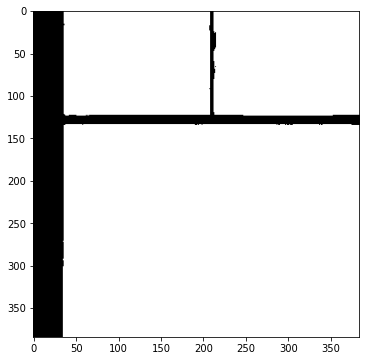

<Figure size 576x576 with 0 Axes>

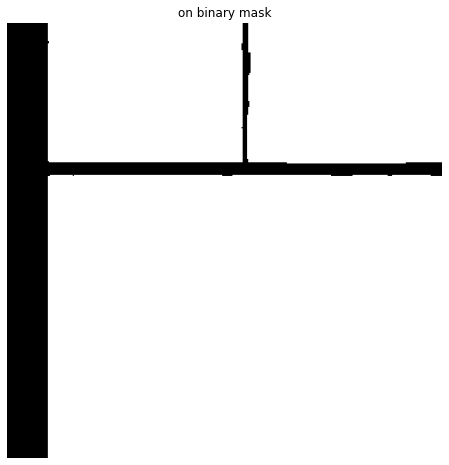

Image saved to post_process_mixed/pred_mask_raw_50.png
3 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_23.png


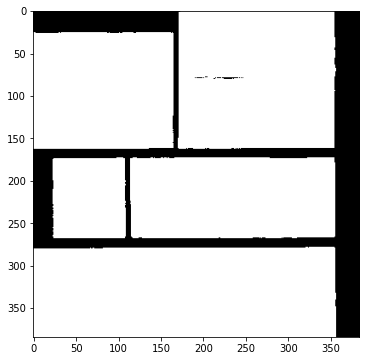

<Figure size 576x576 with 0 Axes>

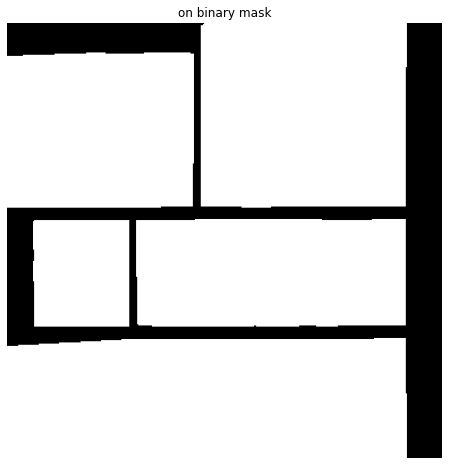

Image saved to post_process_mixed/pred_mask_raw_23.png
4 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_15.png


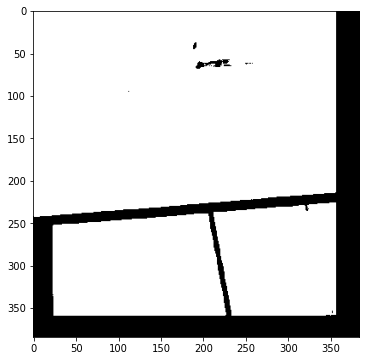

<Figure size 576x576 with 0 Axes>

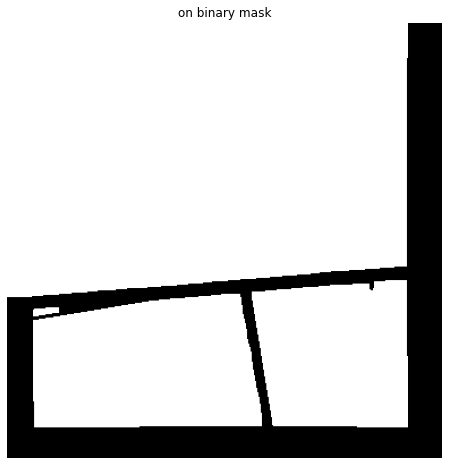

Image saved to post_process_mixed/pred_mask_raw_15.png
5 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_40.png


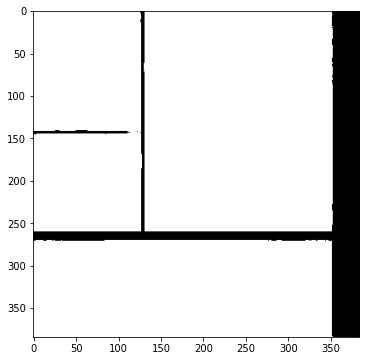

<Figure size 576x576 with 0 Axes>

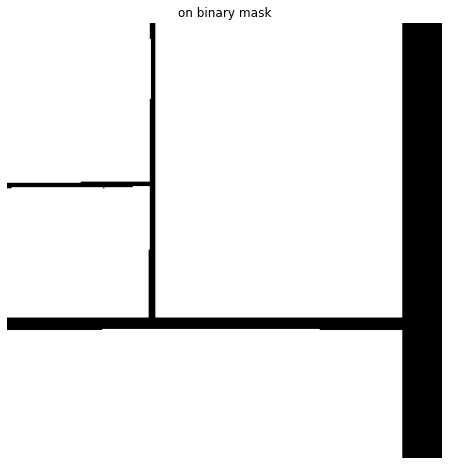

Image saved to post_process_mixed/pred_mask_raw_40.png
6 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_7.png


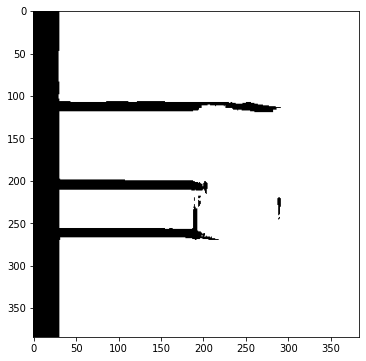

<Figure size 576x576 with 0 Axes>

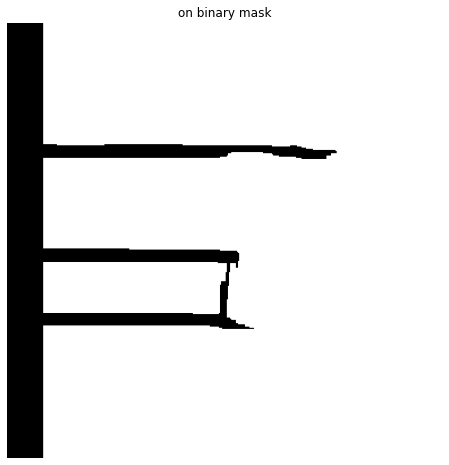

Image saved to post_process_mixed/pred_mask_raw_7.png
7 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_36.png


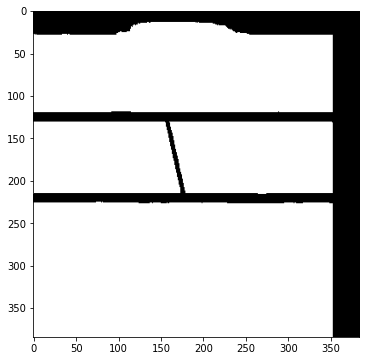

<Figure size 576x576 with 0 Axes>

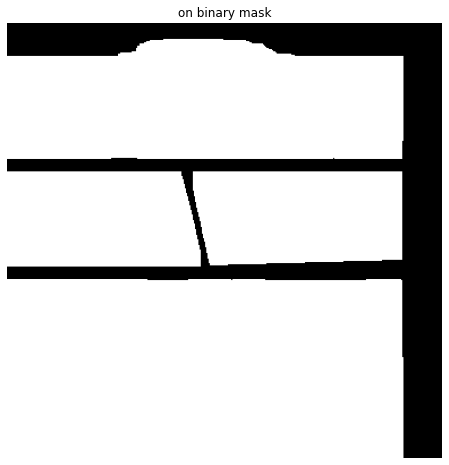

Image saved to post_process_mixed/pred_mask_raw_36.png
8 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_5.png


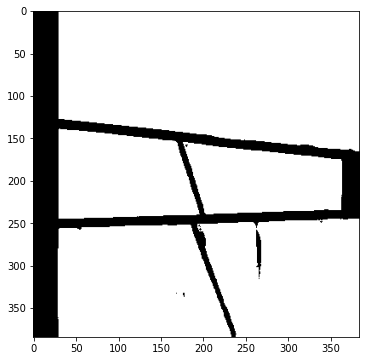

<Figure size 576x576 with 0 Axes>

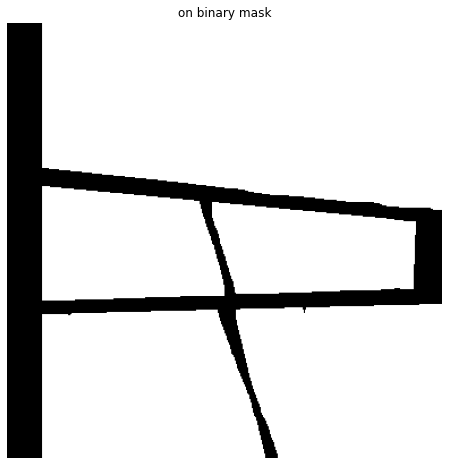

Image saved to post_process_mixed/pred_mask_raw_5.png
9 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_12.png


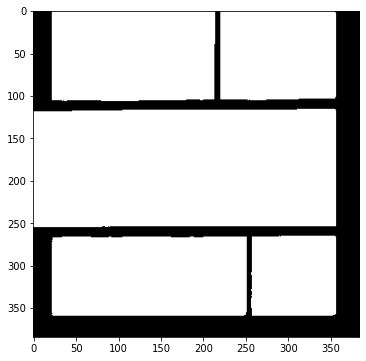

<Figure size 576x576 with 0 Axes>

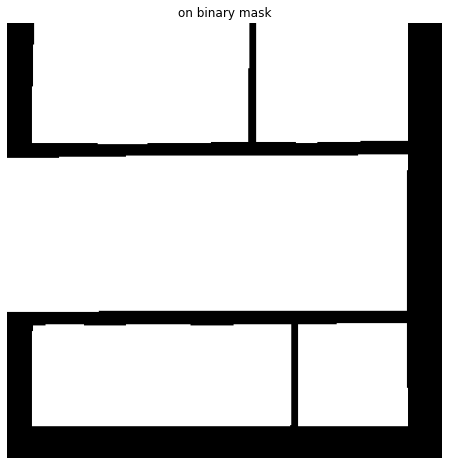

Image saved to post_process_mixed/pred_mask_raw_12.png
10 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_42.png


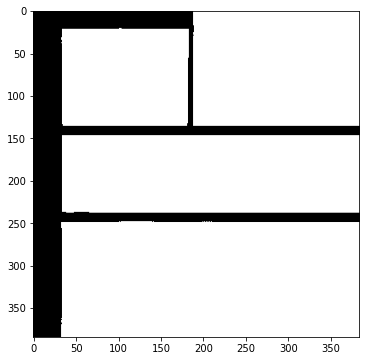

<Figure size 576x576 with 0 Axes>

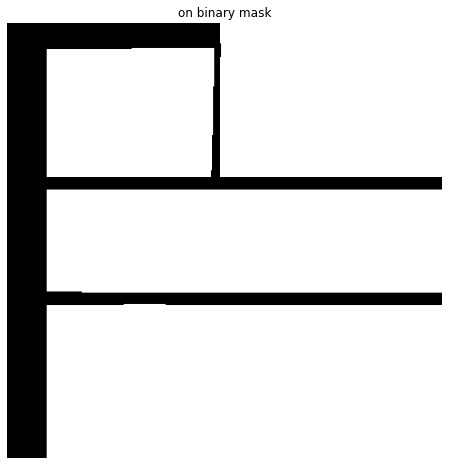

Image saved to post_process_mixed/pred_mask_raw_42.png
11 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_4.png


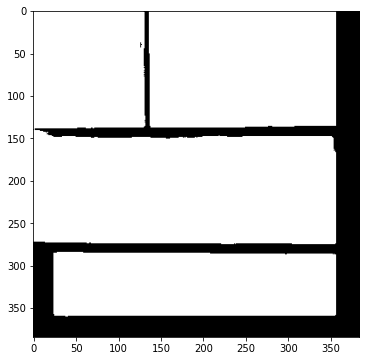

<Figure size 576x576 with 0 Axes>

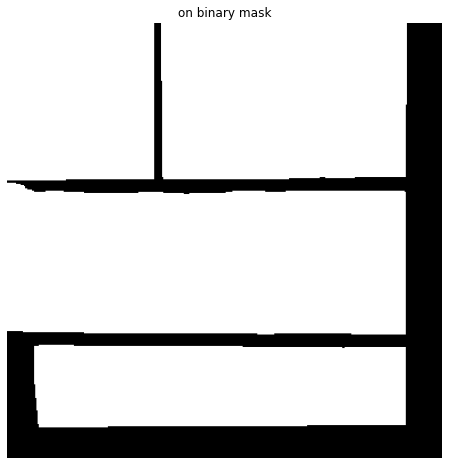

Image saved to post_process_mixed/pred_mask_raw_4.png
12 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_41.png


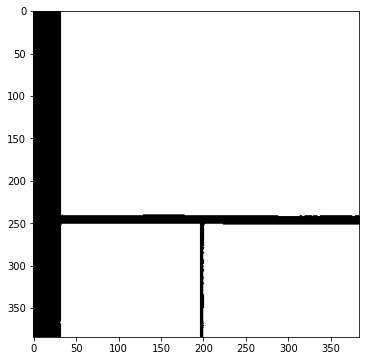

<Figure size 576x576 with 0 Axes>

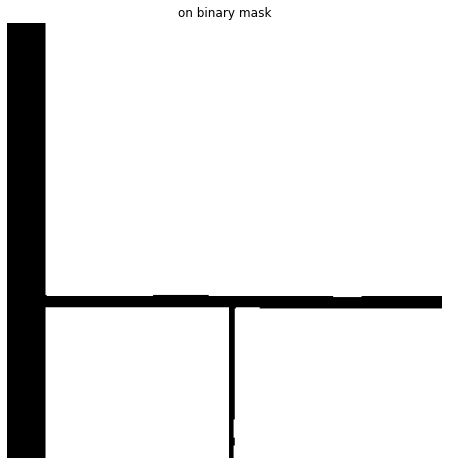

Image saved to post_process_mixed/pred_mask_raw_41.png
13 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_25.png


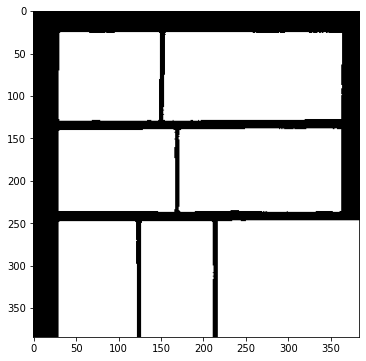

<Figure size 576x576 with 0 Axes>

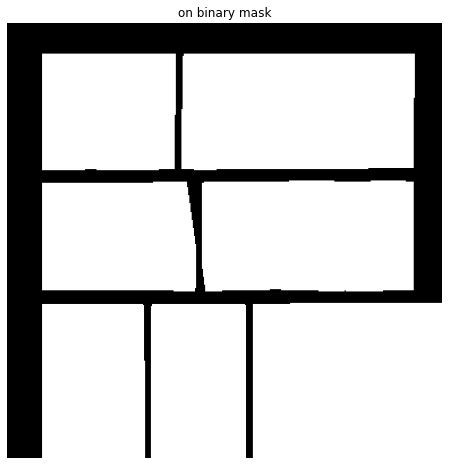

Image saved to post_process_mixed/pred_mask_raw_25.png
14 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_46.png


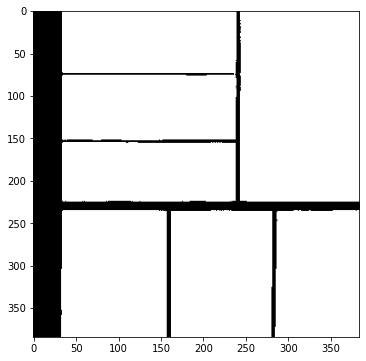

<Figure size 576x576 with 0 Axes>

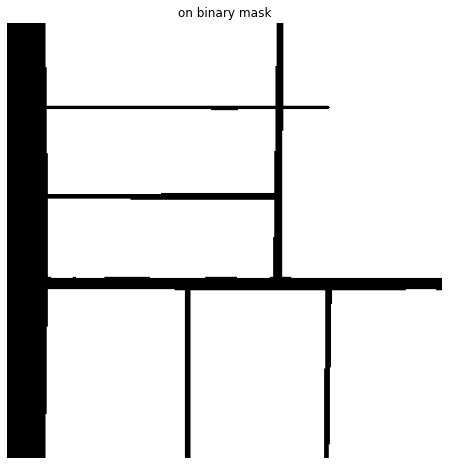

Image saved to post_process_mixed/pred_mask_raw_46.png
15 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_45.png


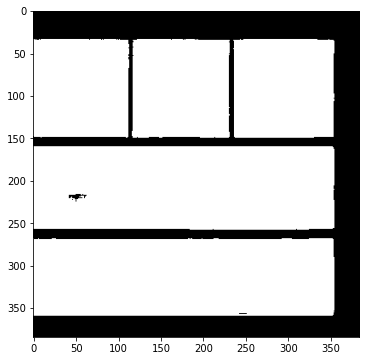

<Figure size 576x576 with 0 Axes>

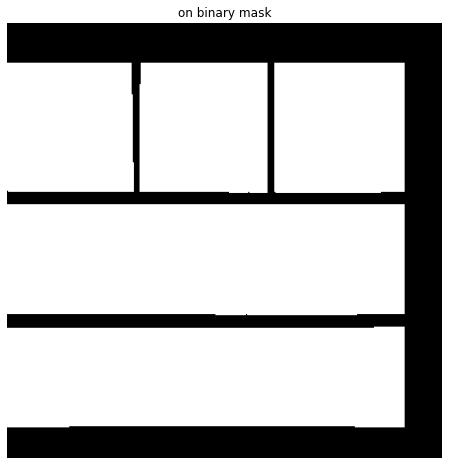

Image saved to post_process_mixed/pred_mask_raw_45.png
16 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_19.png


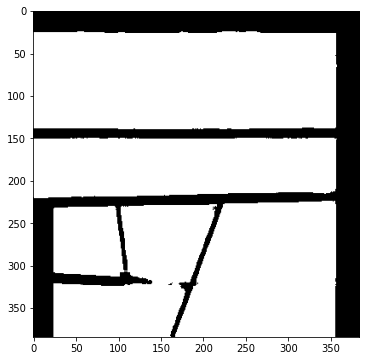

<Figure size 576x576 with 0 Axes>

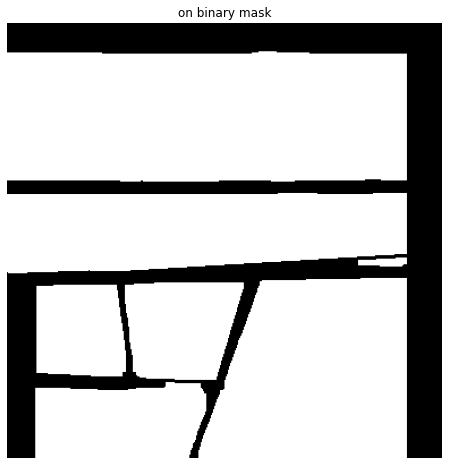

Image saved to post_process_mixed/pred_mask_raw_19.png
17 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_30.png


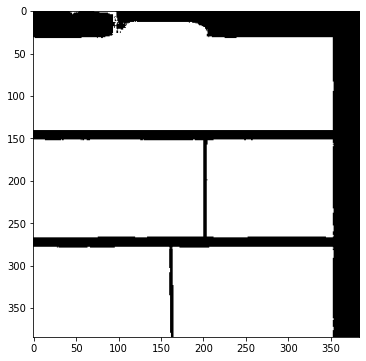

<Figure size 576x576 with 0 Axes>

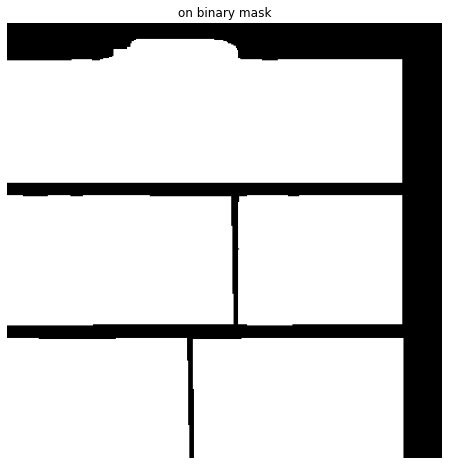

Image saved to post_process_mixed/pred_mask_raw_30.png
18 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_35.png


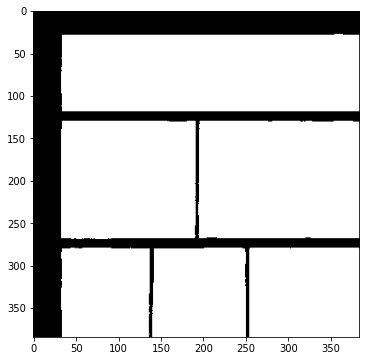

<Figure size 576x576 with 0 Axes>

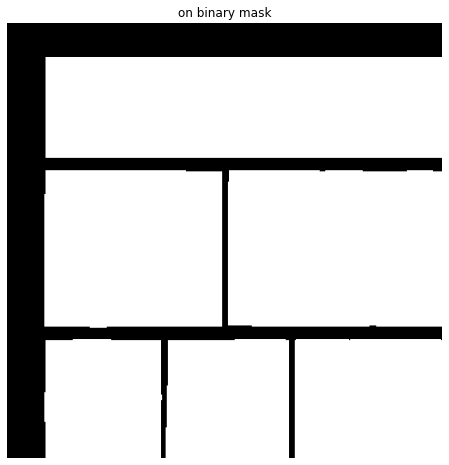

Image saved to post_process_mixed/pred_mask_raw_35.png
19 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_8.png


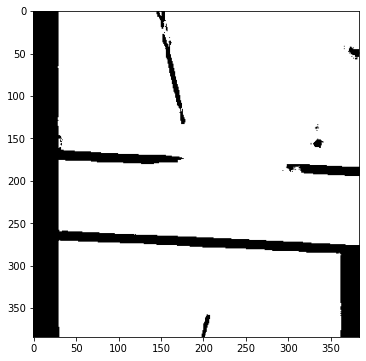

<Figure size 576x576 with 0 Axes>

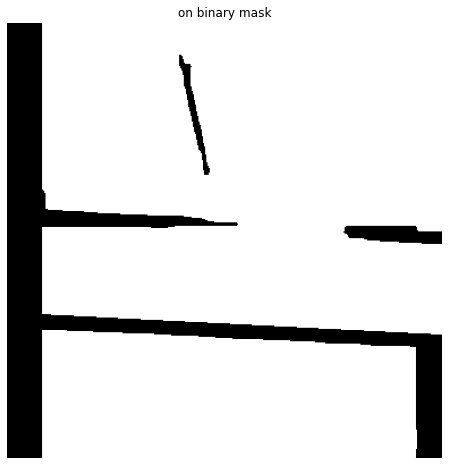

Image saved to post_process_mixed/pred_mask_raw_8.png
20 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_6.png


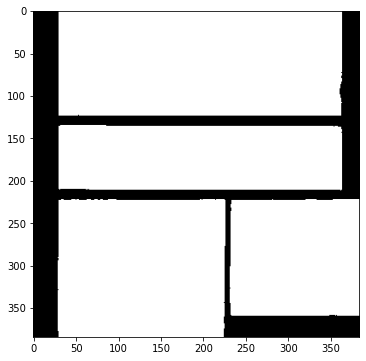

<Figure size 576x576 with 0 Axes>

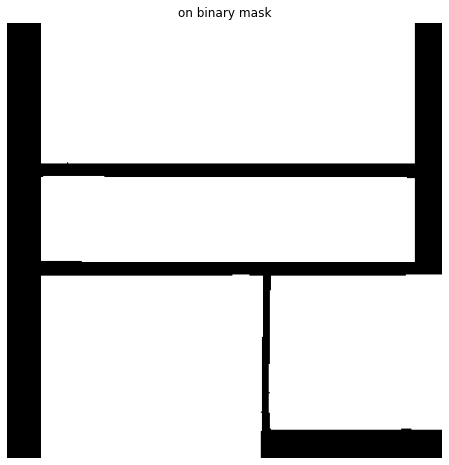

Image saved to post_process_mixed/pred_mask_raw_6.png
21 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_48.png


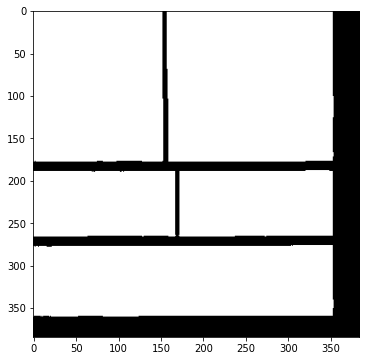

<Figure size 576x576 with 0 Axes>

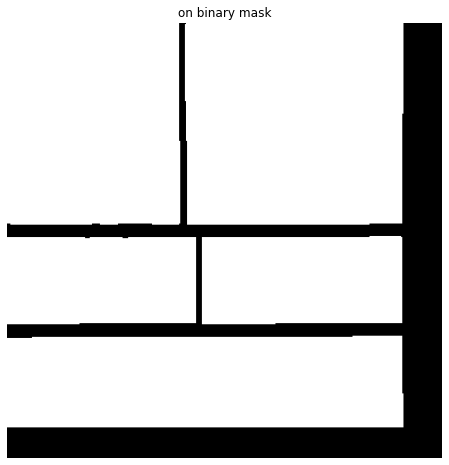

Image saved to post_process_mixed/pred_mask_raw_48.png
22 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_16.png


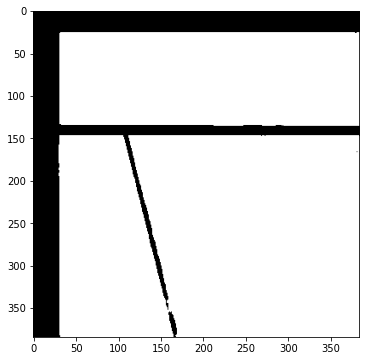

<Figure size 576x576 with 0 Axes>

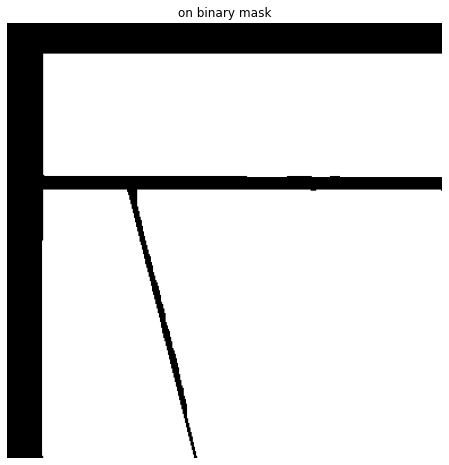

Image saved to post_process_mixed/pred_mask_raw_16.png
23 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_34.png


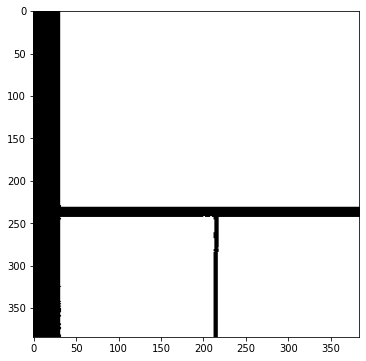

<Figure size 576x576 with 0 Axes>

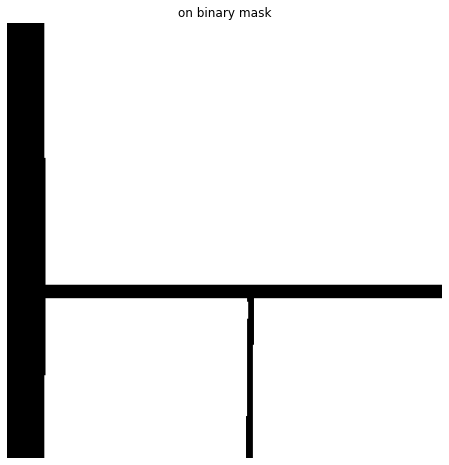

Image saved to post_process_mixed/pred_mask_raw_34.png
24 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_14.png


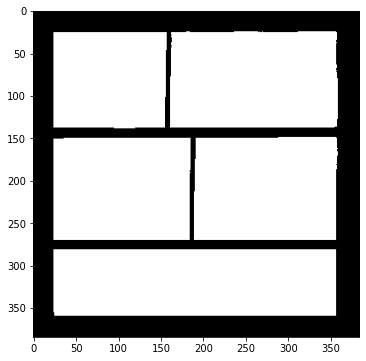

<Figure size 576x576 with 0 Axes>

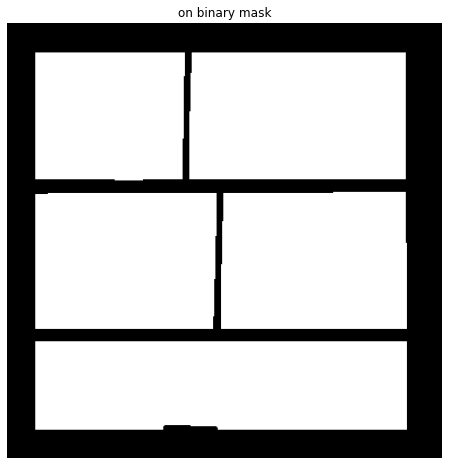

Image saved to post_process_mixed/pred_mask_raw_14.png
25 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_47.png


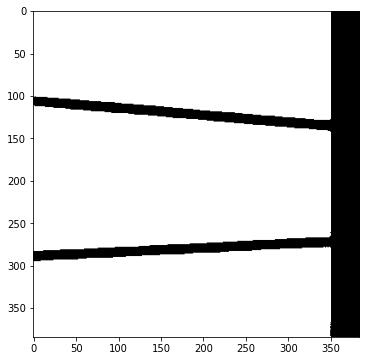

<Figure size 576x576 with 0 Axes>

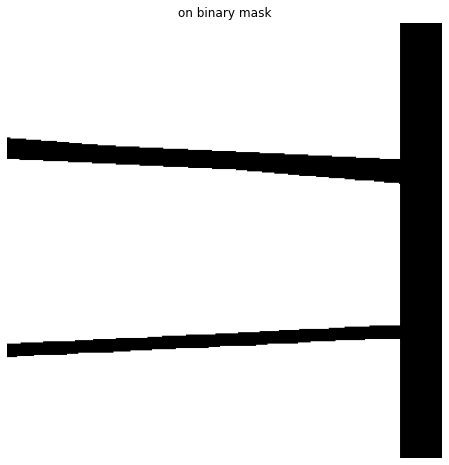

Image saved to post_process_mixed/pred_mask_raw_47.png
26 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_29.png


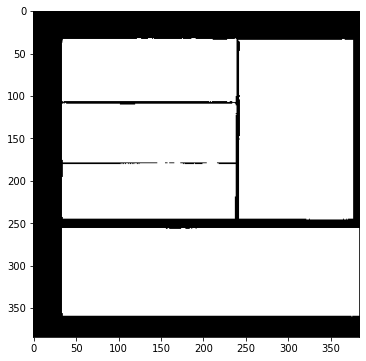

<Figure size 576x576 with 0 Axes>

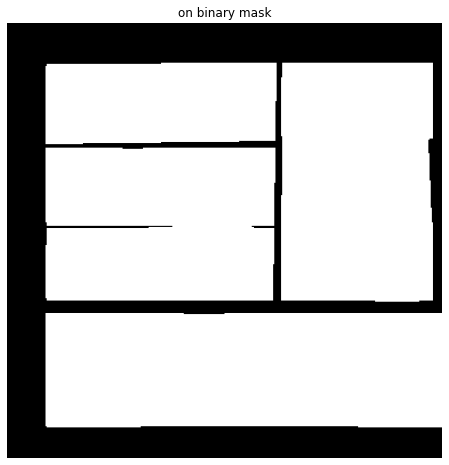

Image saved to post_process_mixed/pred_mask_raw_29.png
27 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_27.png


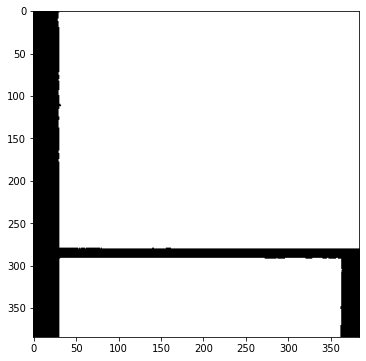

<Figure size 576x576 with 0 Axes>

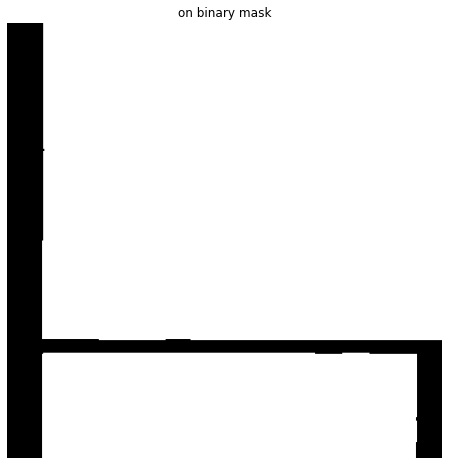

Image saved to post_process_mixed/pred_mask_raw_27.png
28 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_37.png


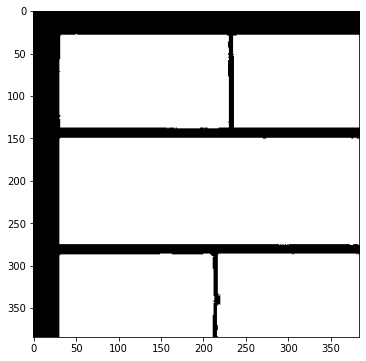

<Figure size 576x576 with 0 Axes>

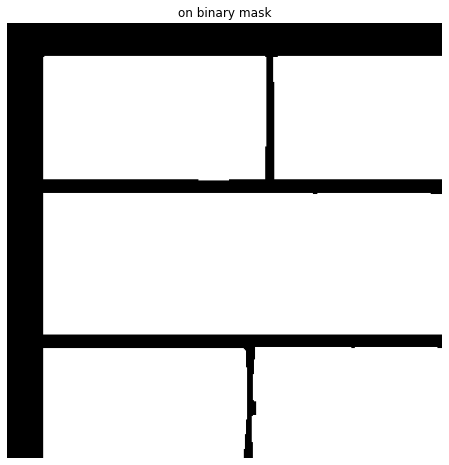

Image saved to post_process_mixed/pred_mask_raw_37.png
29 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_1.png


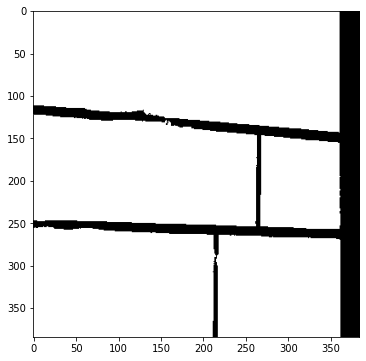

<Figure size 576x576 with 0 Axes>

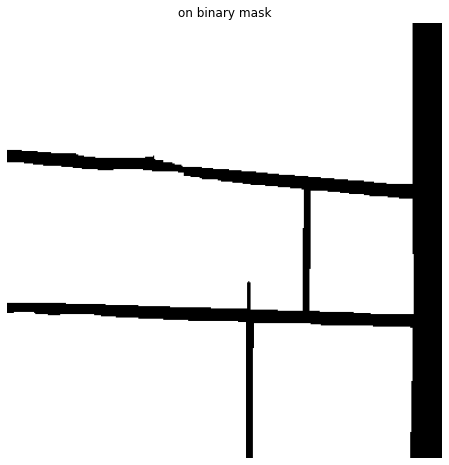

Image saved to post_process_mixed/pred_mask_raw_1.png
30 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_31.png


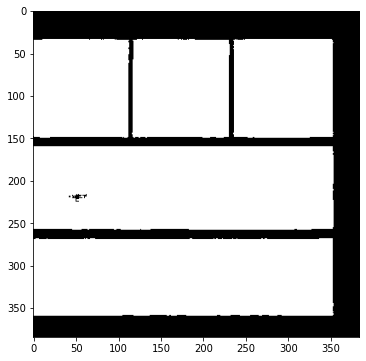

<Figure size 576x576 with 0 Axes>

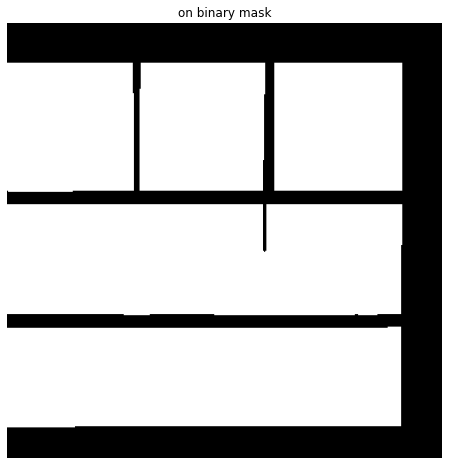

Image saved to post_process_mixed/pred_mask_raw_31.png
31 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_9.png


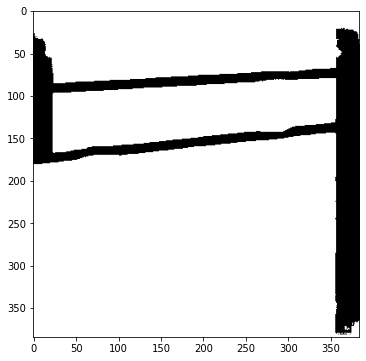

<Figure size 576x576 with 0 Axes>

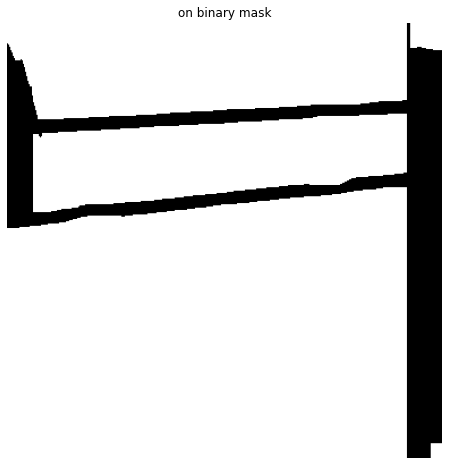

Image saved to post_process_mixed/pred_mask_raw_9.png
32 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_3.png


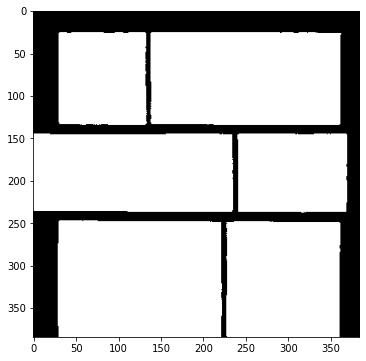

<Figure size 576x576 with 0 Axes>

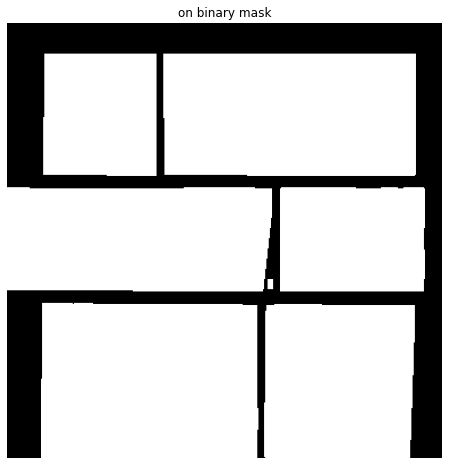

Image saved to post_process_mixed/pred_mask_raw_3.png
33 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_32.png


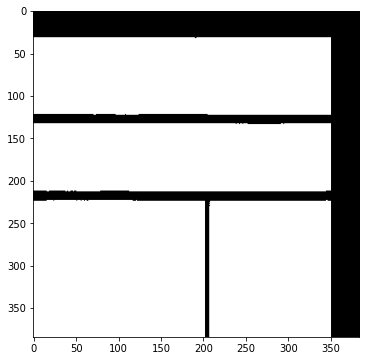

<Figure size 576x576 with 0 Axes>

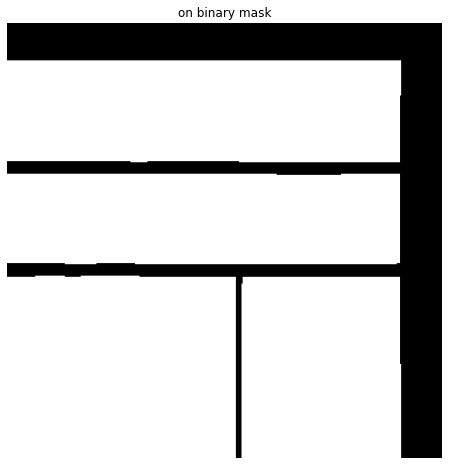

Image saved to post_process_mixed/pred_mask_raw_32.png
34 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_11.png


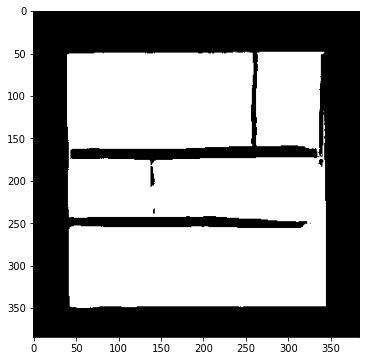

<Figure size 576x576 with 0 Axes>

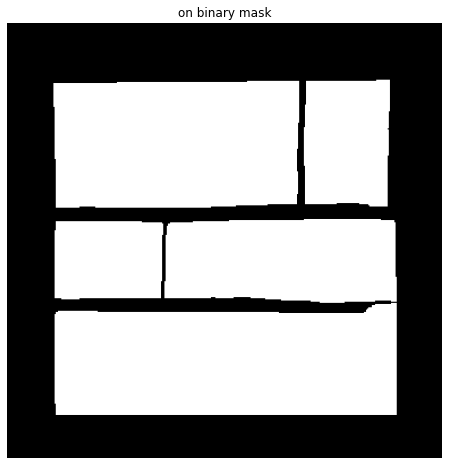

Image saved to post_process_mixed/pred_mask_raw_11.png
35 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_2.png


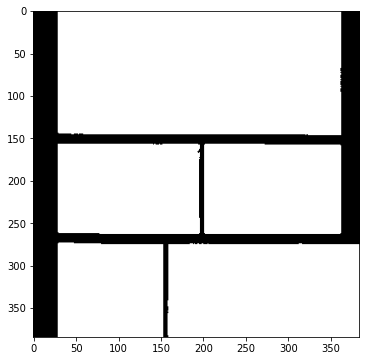

<Figure size 576x576 with 0 Axes>

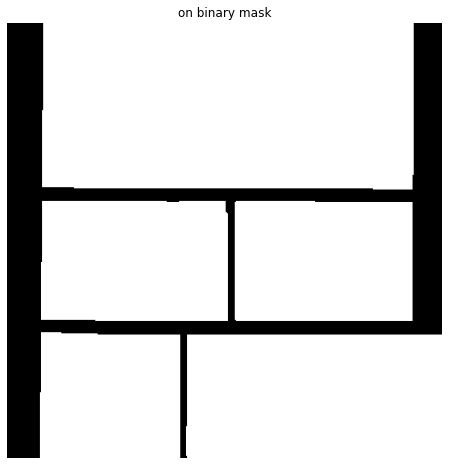

Image saved to post_process_mixed/pred_mask_raw_2.png
36 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_43.png


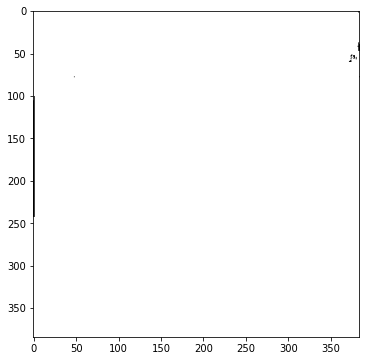

<Figure size 576x576 with 0 Axes>

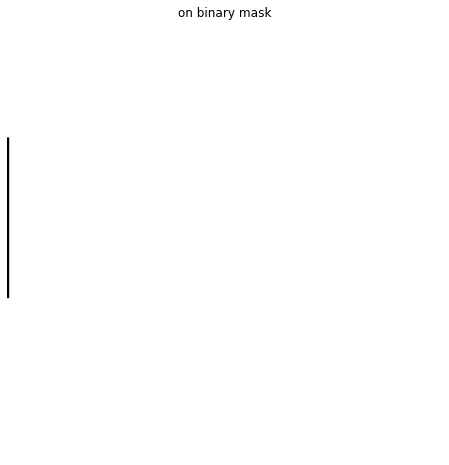

Image saved to post_process_mixed/pred_mask_raw_43.png
37 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_26.png


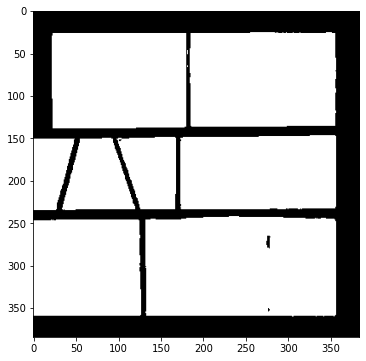

<Figure size 576x576 with 0 Axes>

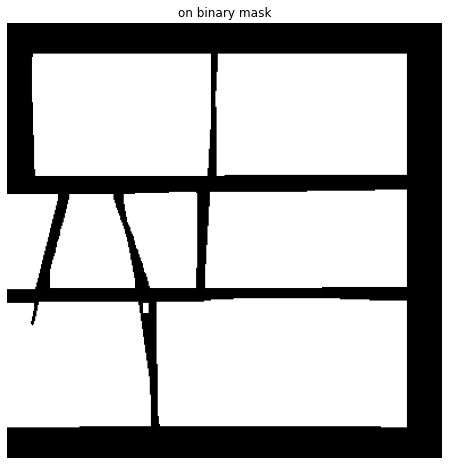

Image saved to post_process_mixed/pred_mask_raw_26.png
38 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_13.png


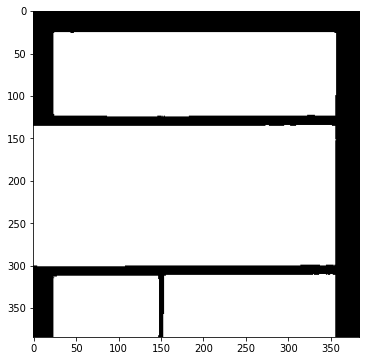

<Figure size 576x576 with 0 Axes>

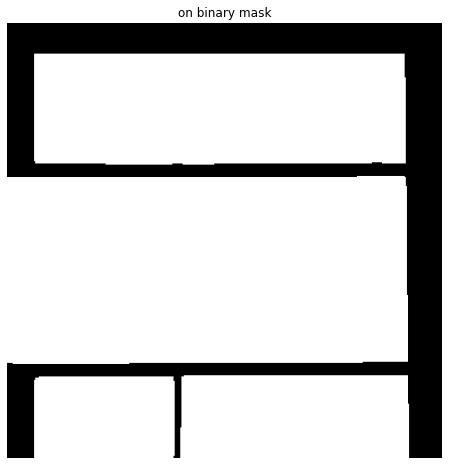

Image saved to post_process_mixed/pred_mask_raw_13.png
39 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_21.png


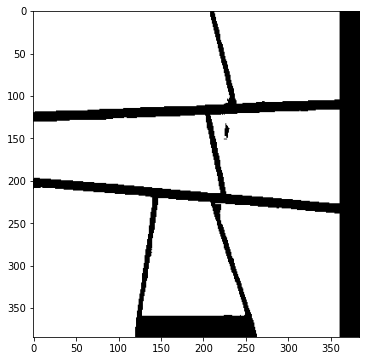

<Figure size 576x576 with 0 Axes>

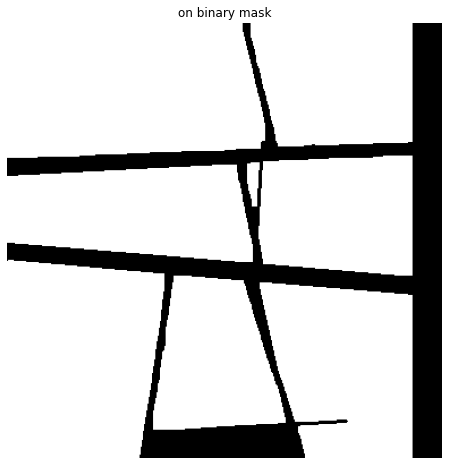

Image saved to post_process_mixed/pred_mask_raw_21.png
40 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_44.png


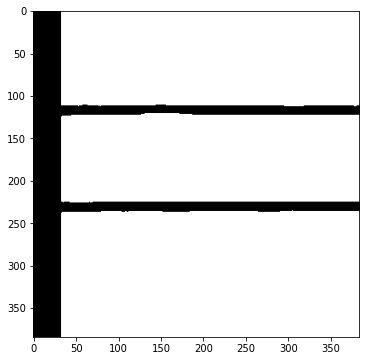

<Figure size 576x576 with 0 Axes>

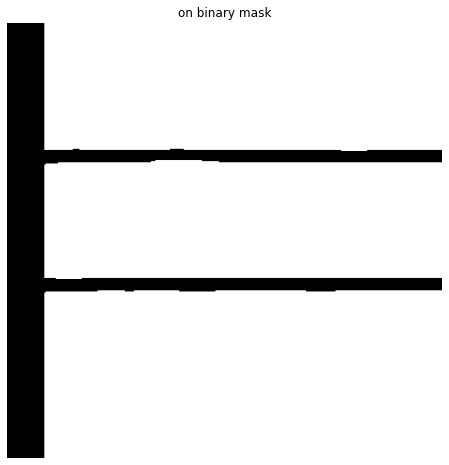

Image saved to post_process_mixed/pred_mask_raw_44.png
41 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_22.png


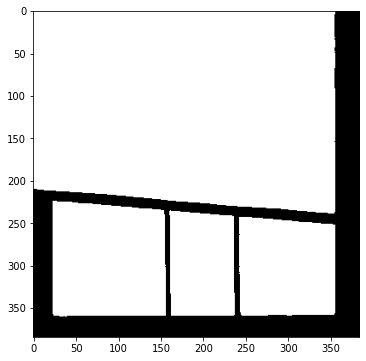

<Figure size 576x576 with 0 Axes>

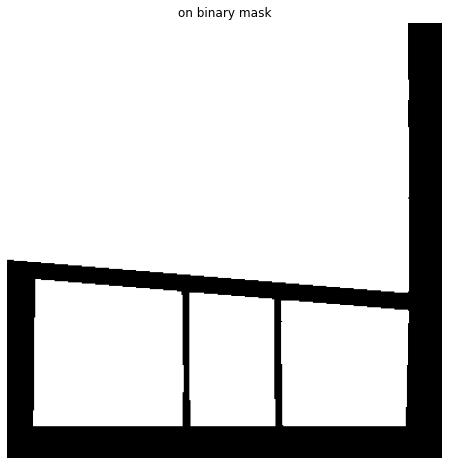

Image saved to post_process_mixed/pred_mask_raw_22.png
42 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_10.png


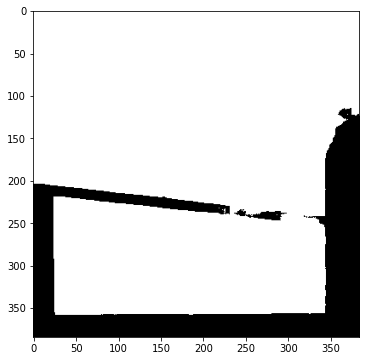

<Figure size 576x576 with 0 Axes>

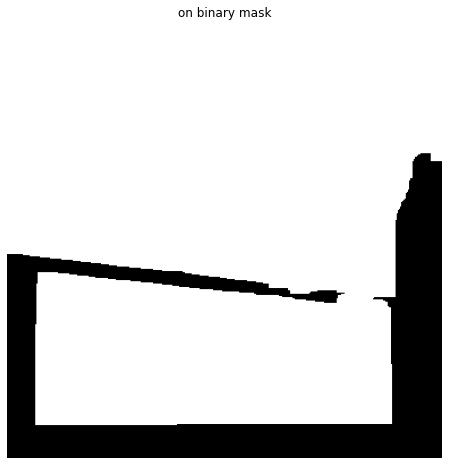

Image saved to post_process_mixed/pred_mask_raw_10.png
43 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_28.png


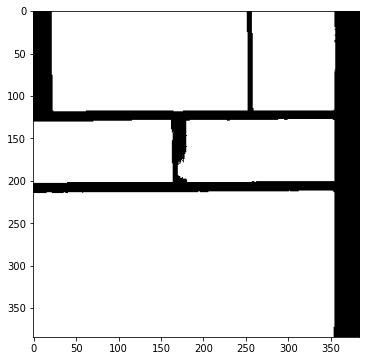

<Figure size 576x576 with 0 Axes>

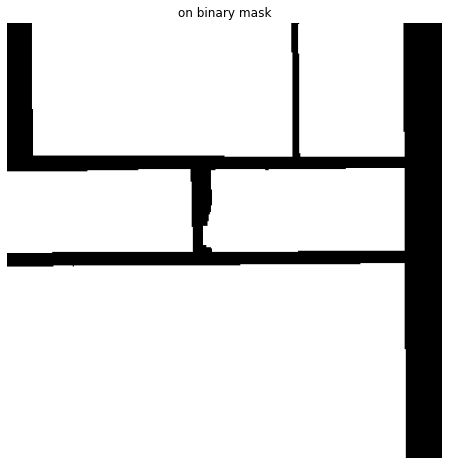

Image saved to post_process_mixed/pred_mask_raw_28.png
44 pred_mask_raw_mixed/pred_mask_raw/pred_mask_raw_38.png


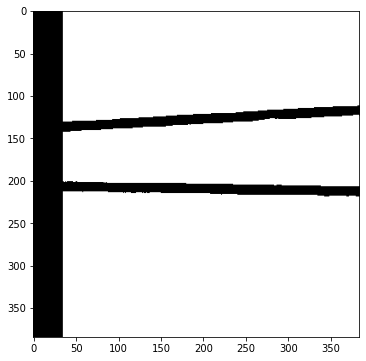

<Figure size 576x576 with 0 Axes>

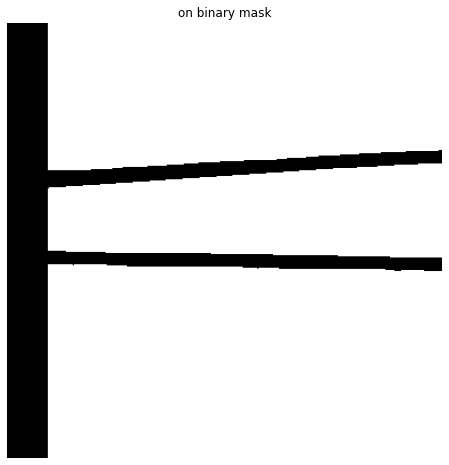

Image saved to post_process_mixed/pred_mask_raw_38.png


In [251]:
dir = 'pred_mask_raw_mixed/pred_mask_raw'
count = 1
# Iterate over all files in the directory
for file in os.listdir(dir):
    path = os.path.join(dir, file)  # Construct full path using os.path.join
    print(count,path)
    
    # Skip the specific file
#     if path == os.path.join(dir, 'pred_mask_raw_54-Copy1.png'):
#         continue  # Skip this iteration
        
    if '.ipynb_checkpoints' in path:
        continue
    
    # Process other files
    full_cock(path,'post_process_mixed')
    count +=1

1 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_20.png


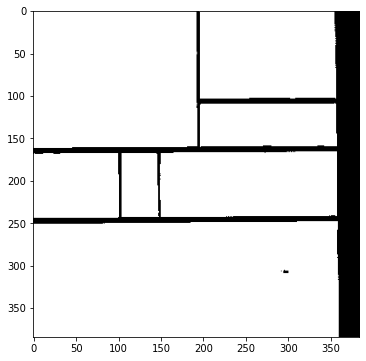

<Figure size 576x576 with 0 Axes>

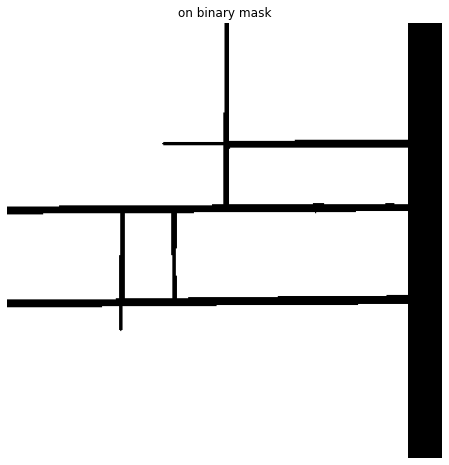

Image saved to post_process_vaga/pred_mask_raw_20.png
2 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_49.png


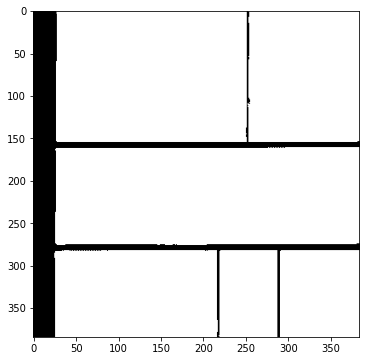

<Figure size 576x576 with 0 Axes>

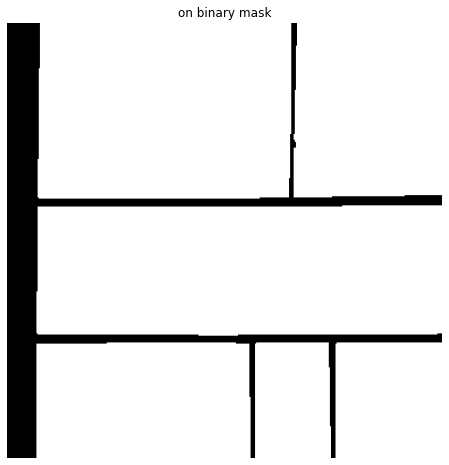

Image saved to post_process_vaga/pred_mask_raw_49.png
3 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_50.png


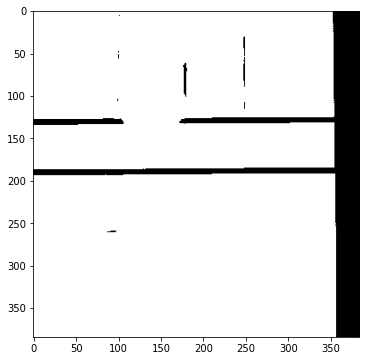

<Figure size 576x576 with 0 Axes>

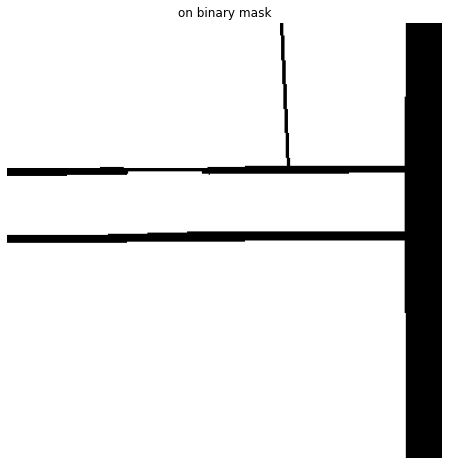

Image saved to post_process_vaga/pred_mask_raw_50.png
4 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_74.png


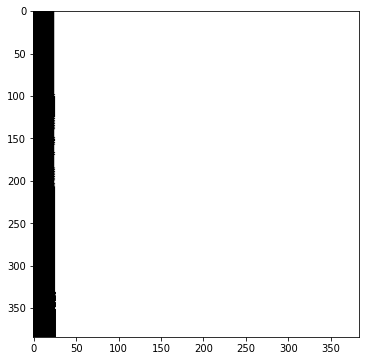

<Figure size 576x576 with 0 Axes>

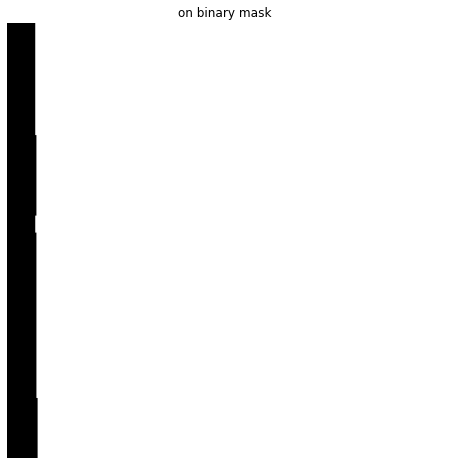

Image saved to post_process_vaga/pred_mask_raw_74.png
5 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_64.png


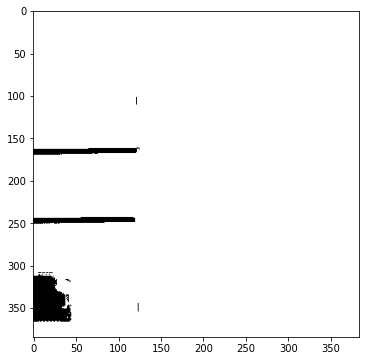

<Figure size 576x576 with 0 Axes>

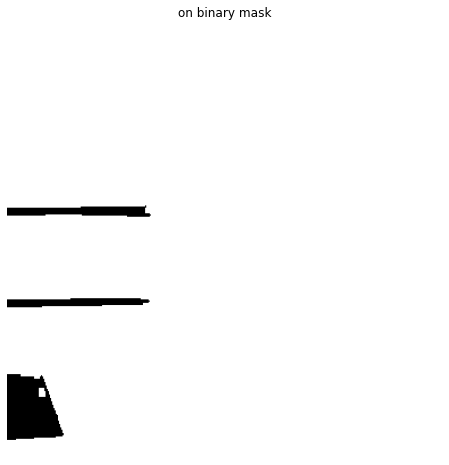

Image saved to post_process_vaga/pred_mask_raw_64.png
6 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_23.png


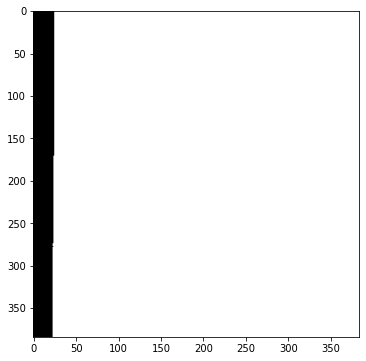

<Figure size 576x576 with 0 Axes>

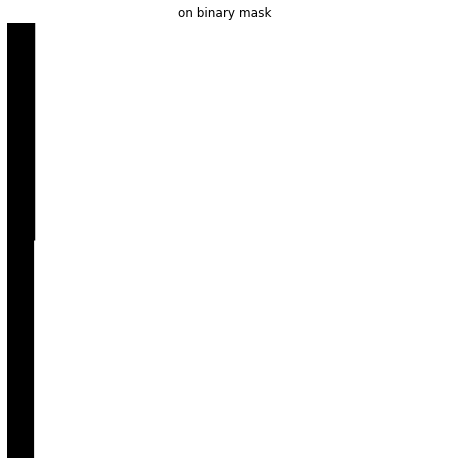

Image saved to post_process_vaga/pred_mask_raw_23.png
7 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_15.png


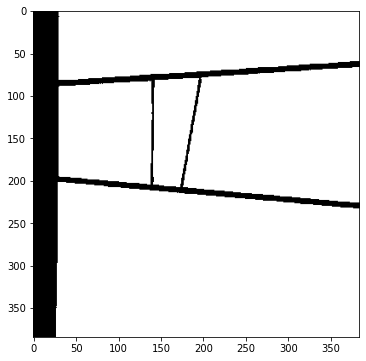

<Figure size 576x576 with 0 Axes>

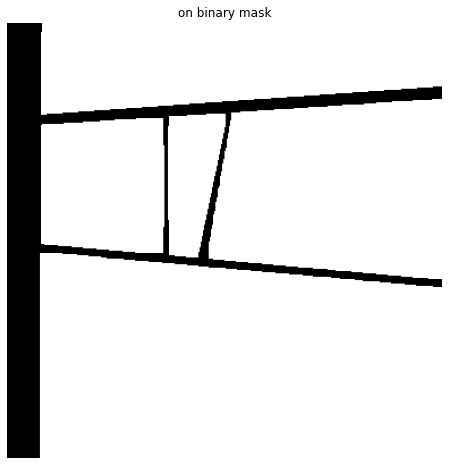

Image saved to post_process_vaga/pred_mask_raw_15.png
8 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_40.png


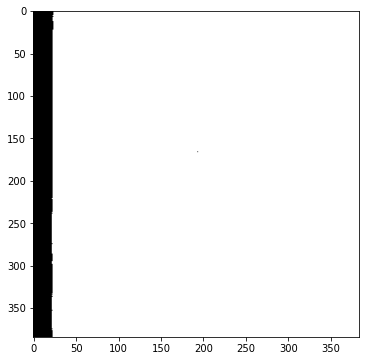

<Figure size 576x576 with 0 Axes>

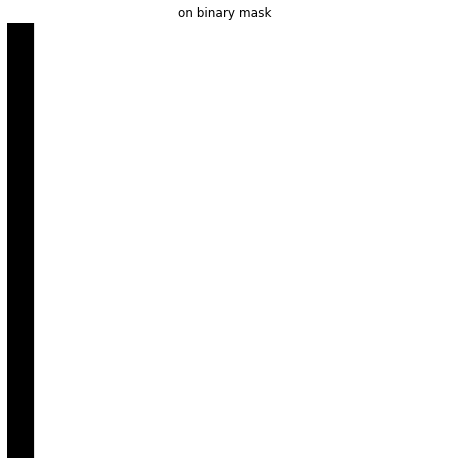

Image saved to post_process_vaga/pred_mask_raw_40.png
9 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_7.png


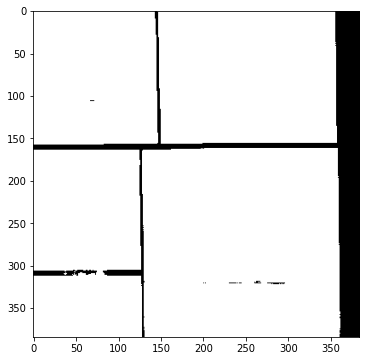

<Figure size 576x576 with 0 Axes>

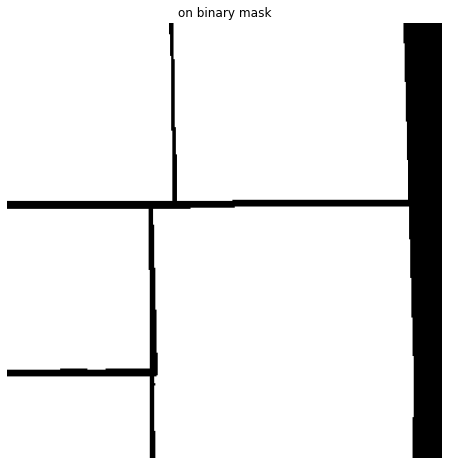

Image saved to post_process_vaga/pred_mask_raw_7.png
10 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_61.png


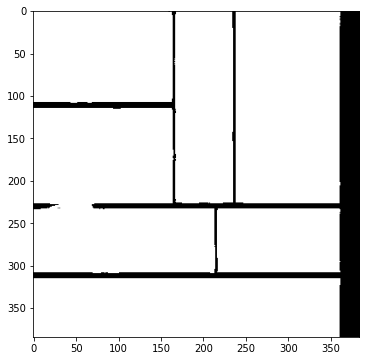

<Figure size 576x576 with 0 Axes>

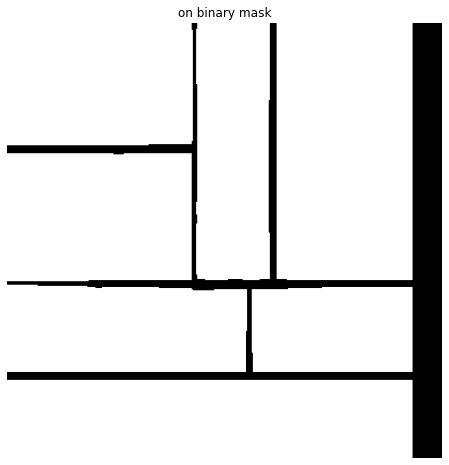

Image saved to post_process_vaga/pred_mask_raw_61.png
11 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_33.png


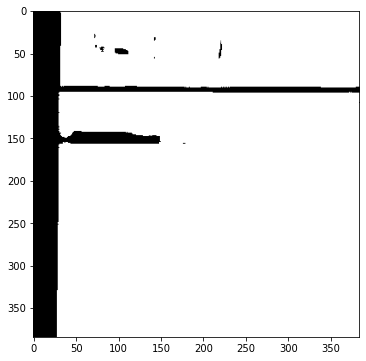

<Figure size 576x576 with 0 Axes>

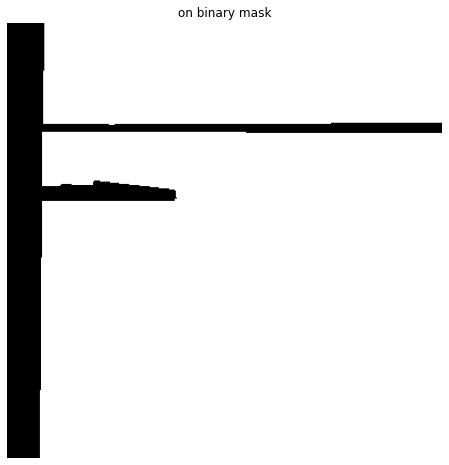

Image saved to post_process_vaga/pred_mask_raw_33.png
12 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_36.png


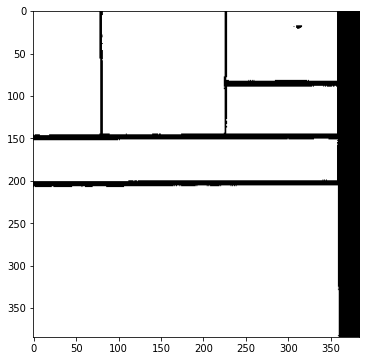

<Figure size 576x576 with 0 Axes>

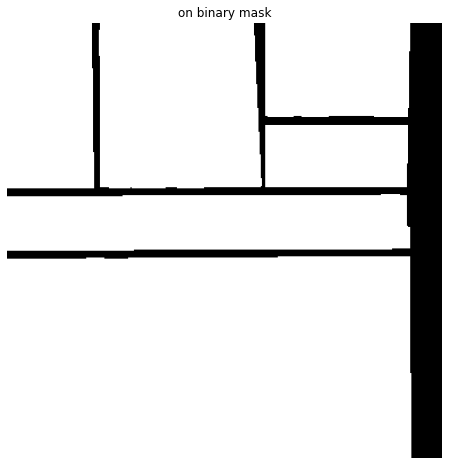

Image saved to post_process_vaga/pred_mask_raw_36.png
13 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_73.png


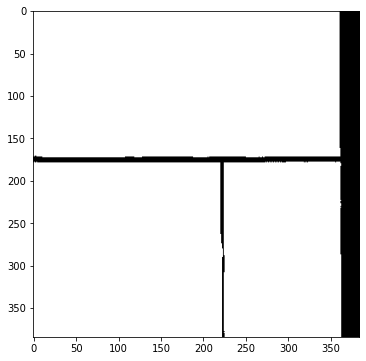

<Figure size 576x576 with 0 Axes>

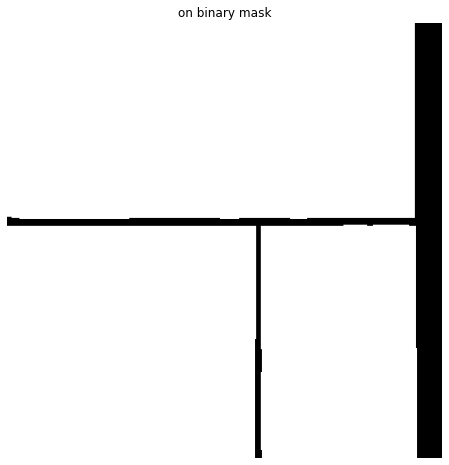

Image saved to post_process_vaga/pred_mask_raw_73.png
14 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_24.png


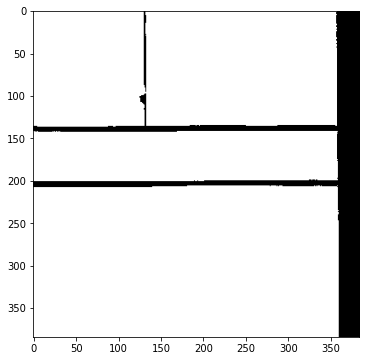

<Figure size 576x576 with 0 Axes>

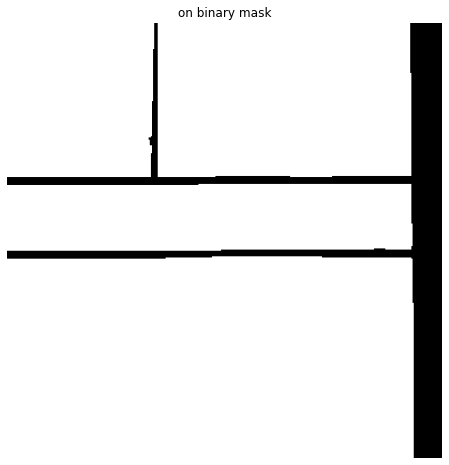

Image saved to post_process_vaga/pred_mask_raw_24.png
15 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_5.png


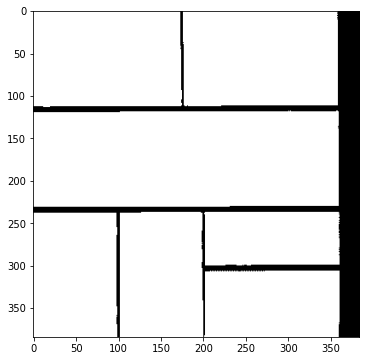

<Figure size 576x576 with 0 Axes>

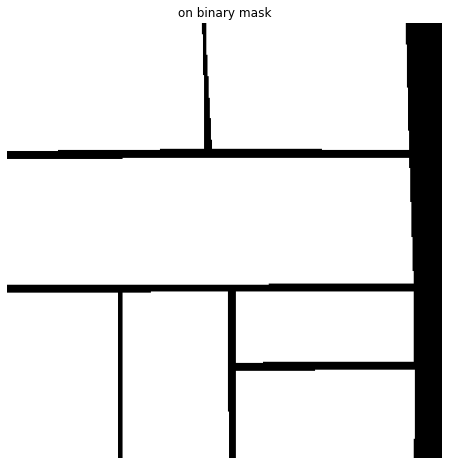

Image saved to post_process_vaga/pred_mask_raw_5.png
16 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_12.png


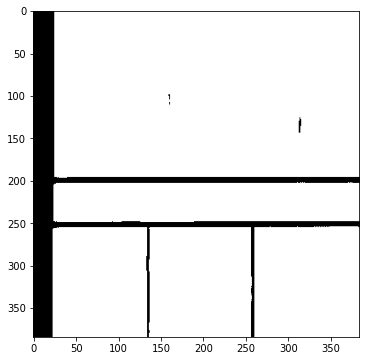

<Figure size 576x576 with 0 Axes>

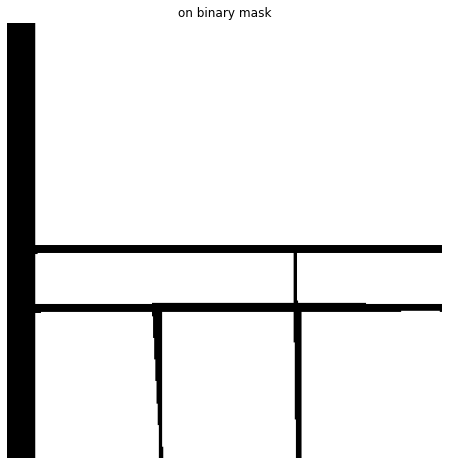

Image saved to post_process_vaga/pred_mask_raw_12.png
17 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_42.png


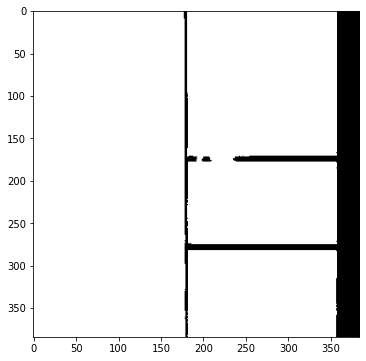

<Figure size 576x576 with 0 Axes>

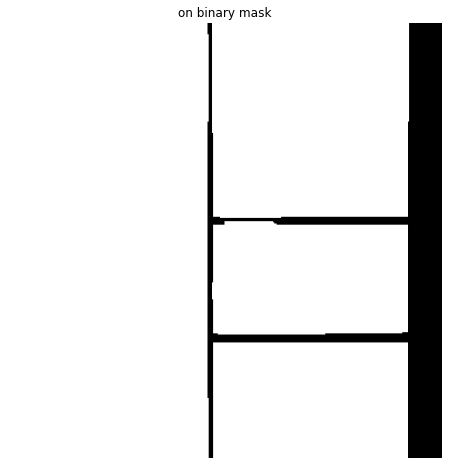

Image saved to post_process_vaga/pred_mask_raw_42.png
18 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_4.png


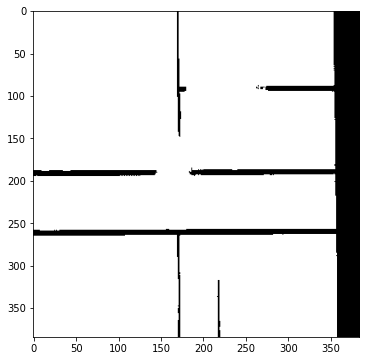

<Figure size 576x576 with 0 Axes>

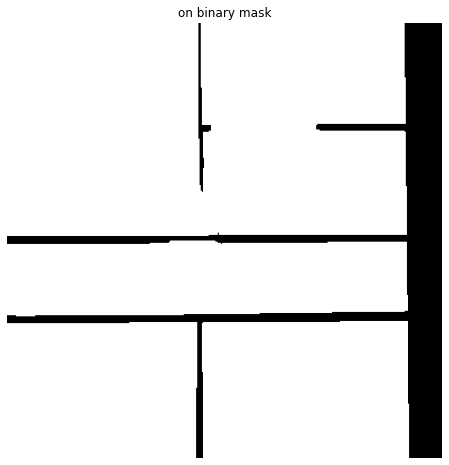

Image saved to post_process_vaga/pred_mask_raw_4.png
19 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_69.png


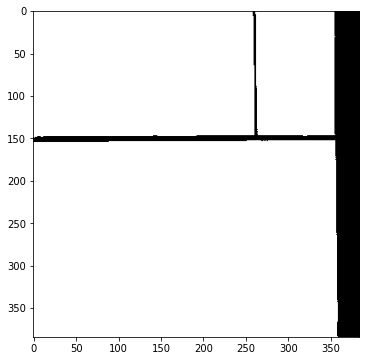

<Figure size 576x576 with 0 Axes>

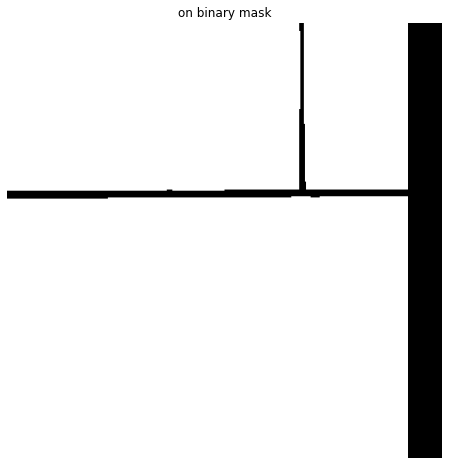

Image saved to post_process_vaga/pred_mask_raw_69.png
20 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_75.png


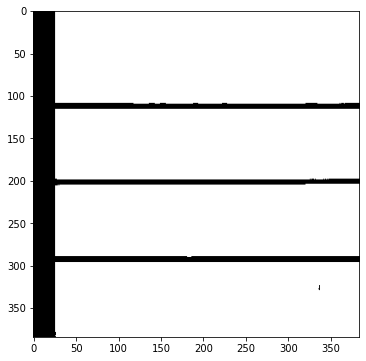

<Figure size 576x576 with 0 Axes>

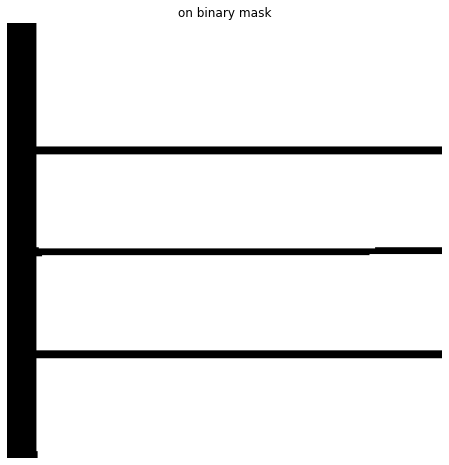

Image saved to post_process_vaga/pred_mask_raw_75.png
21 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_71.png


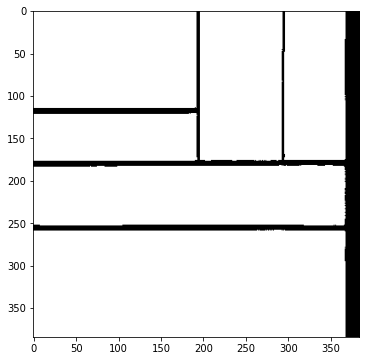

<Figure size 576x576 with 0 Axes>

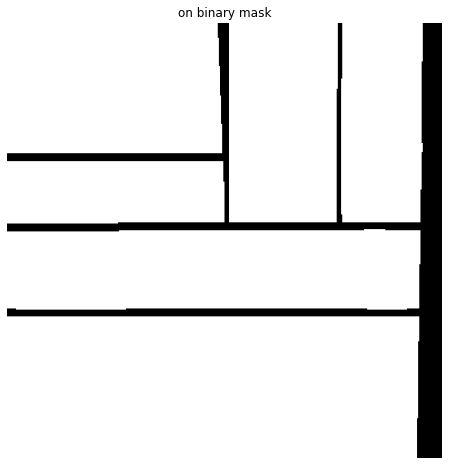

Image saved to post_process_vaga/pred_mask_raw_71.png
22 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_41.png


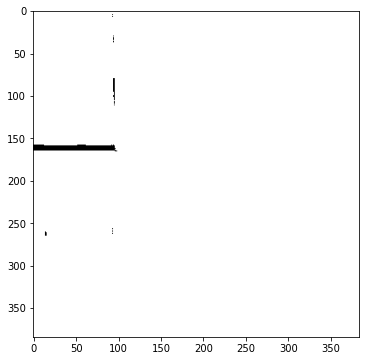

<Figure size 576x576 with 0 Axes>

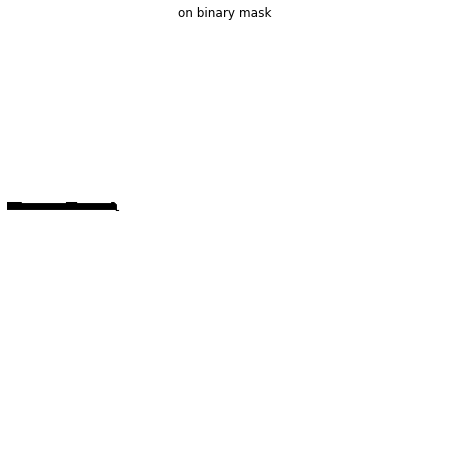

Image saved to post_process_vaga/pred_mask_raw_41.png
23 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_17.png


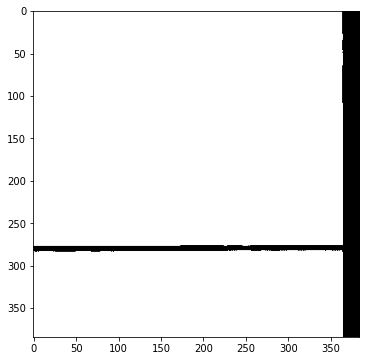

<Figure size 576x576 with 0 Axes>

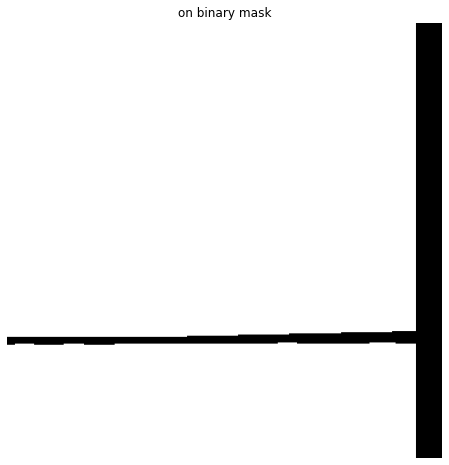

Image saved to post_process_vaga/pred_mask_raw_17.png
24 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_25.png


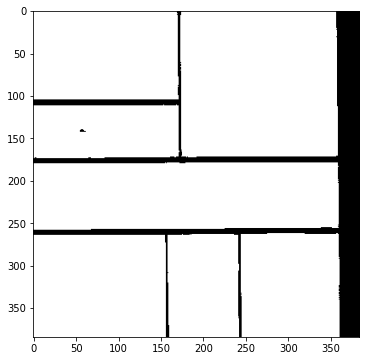

<Figure size 576x576 with 0 Axes>

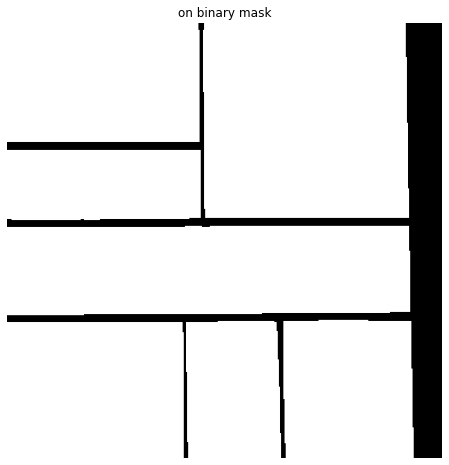

Image saved to post_process_vaga/pred_mask_raw_25.png
25 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_46.png


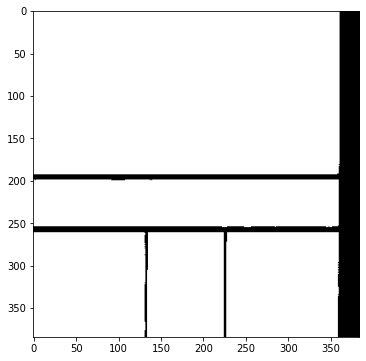

<Figure size 576x576 with 0 Axes>

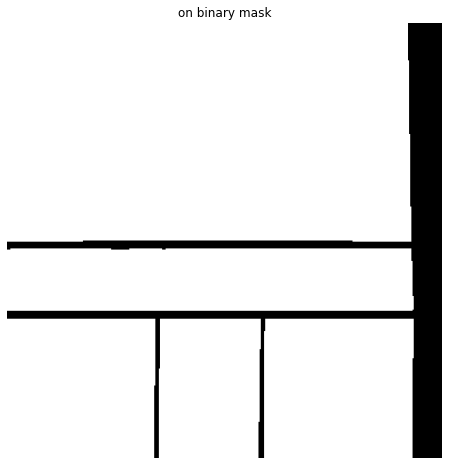

Image saved to post_process_vaga/pred_mask_raw_46.png
26 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_45.png


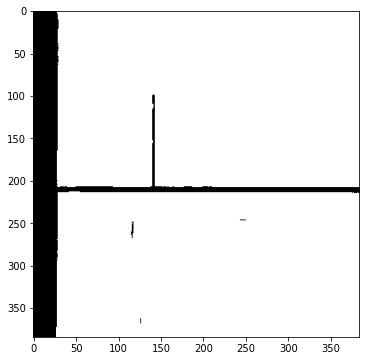

<Figure size 576x576 with 0 Axes>

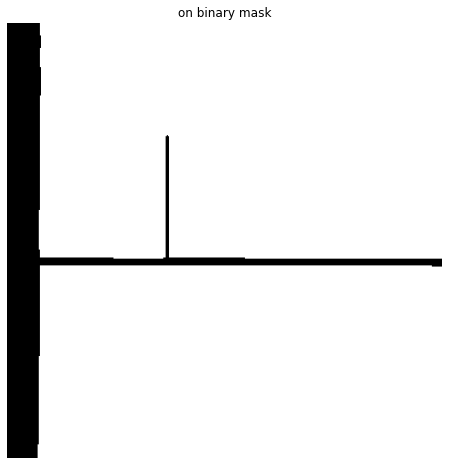

Image saved to post_process_vaga/pred_mask_raw_45.png
27 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_19.png


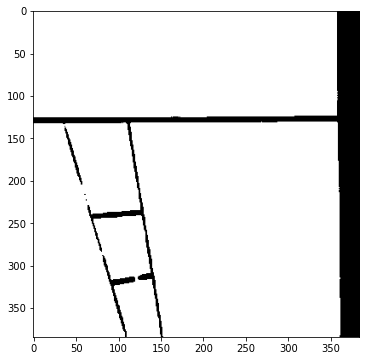

<Figure size 576x576 with 0 Axes>

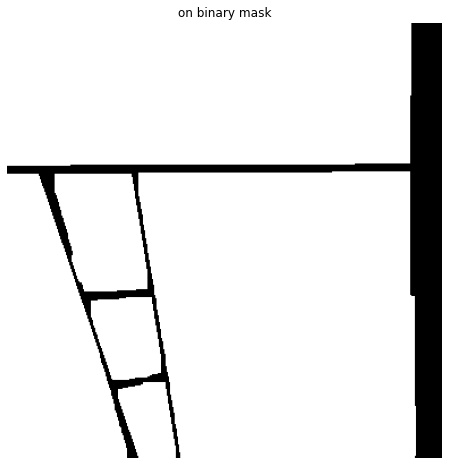

Image saved to post_process_vaga/pred_mask_raw_19.png
28 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_30.png


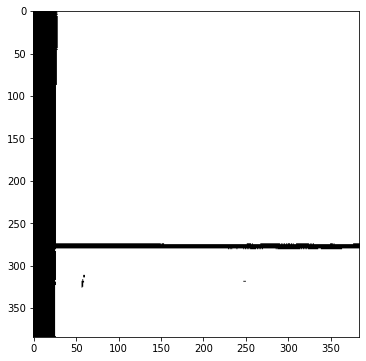

<Figure size 576x576 with 0 Axes>

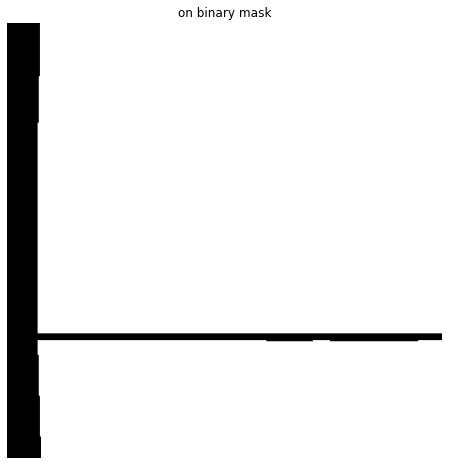

Image saved to post_process_vaga/pred_mask_raw_30.png
29 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_35.png


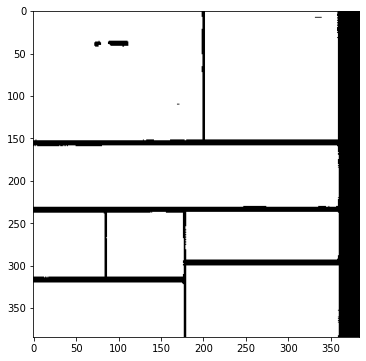

<Figure size 576x576 with 0 Axes>

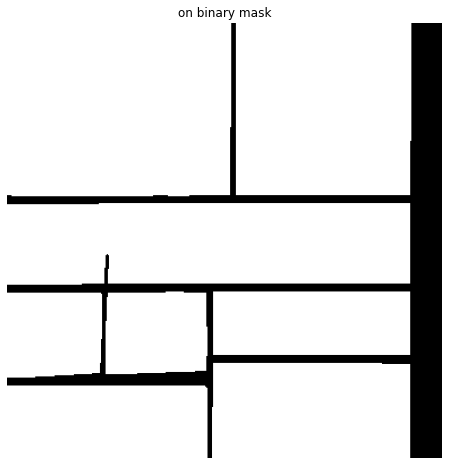

Image saved to post_process_vaga/pred_mask_raw_35.png
30 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_8.png


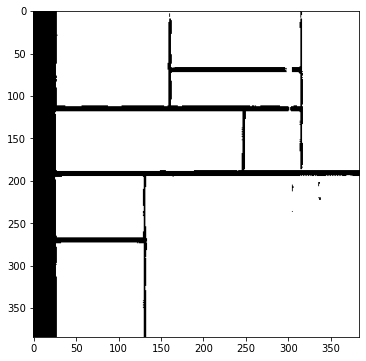

<Figure size 576x576 with 0 Axes>

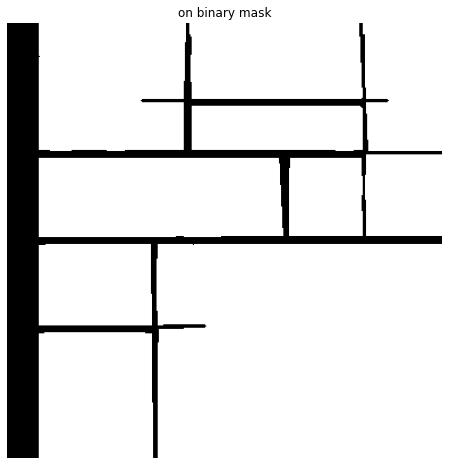

Image saved to post_process_vaga/pred_mask_raw_8.png
31 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_70.png


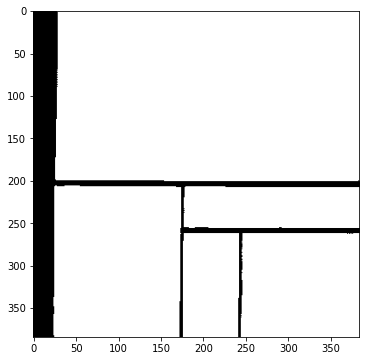

<Figure size 576x576 with 0 Axes>

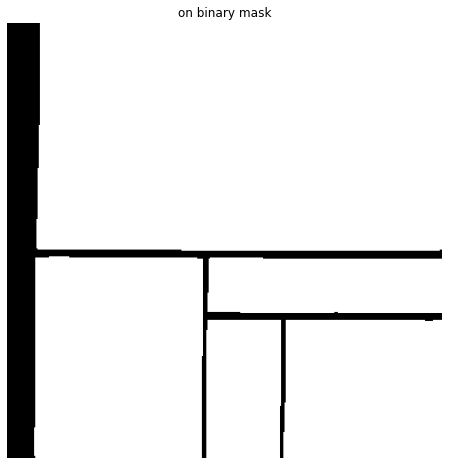

Image saved to post_process_vaga/pred_mask_raw_70.png
32 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_6.png


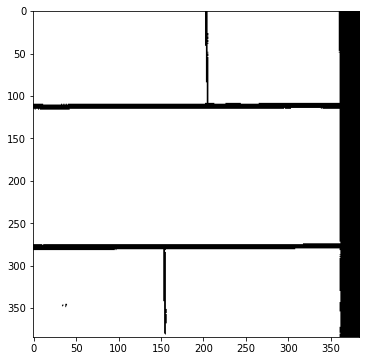

<Figure size 576x576 with 0 Axes>

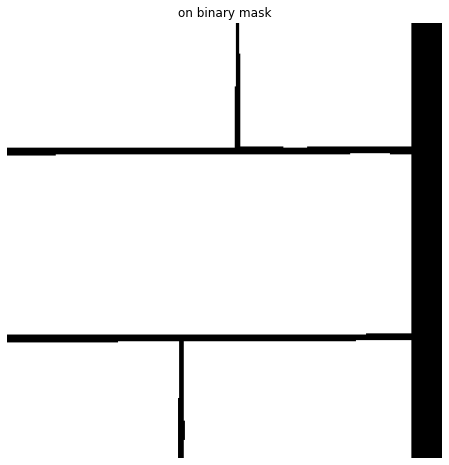

Image saved to post_process_vaga/pred_mask_raw_6.png
33 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_48.png


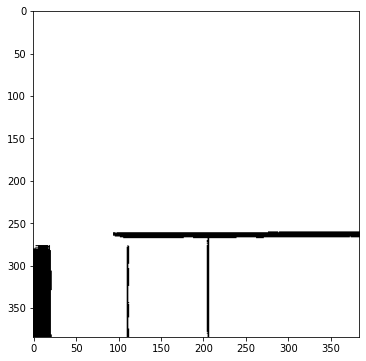

<Figure size 576x576 with 0 Axes>

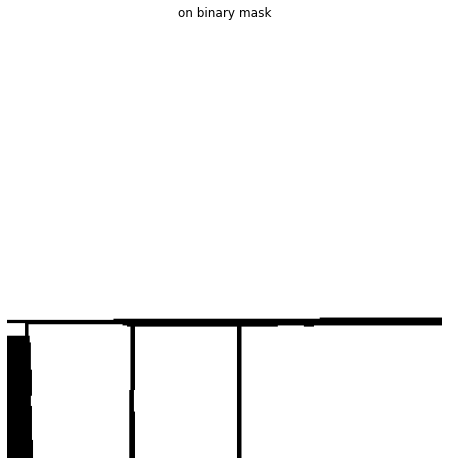

Image saved to post_process_vaga/pred_mask_raw_48.png
34 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_16.png


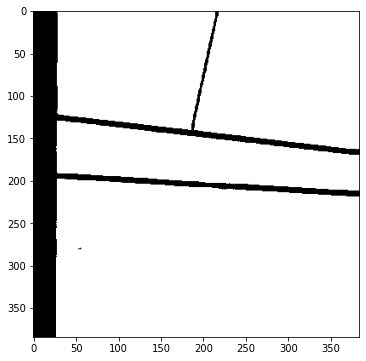

<Figure size 576x576 with 0 Axes>

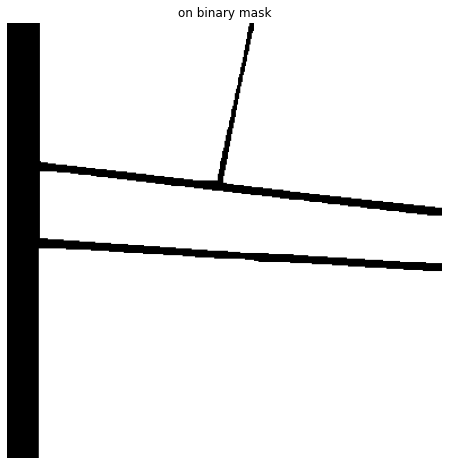

Image saved to post_process_vaga/pred_mask_raw_16.png
35 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_34.png


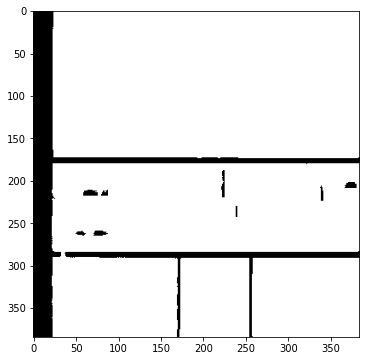

<Figure size 576x576 with 0 Axes>

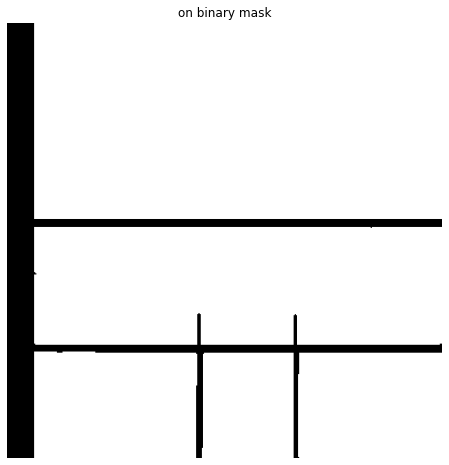

Image saved to post_process_vaga/pred_mask_raw_34.png
36 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_59.png


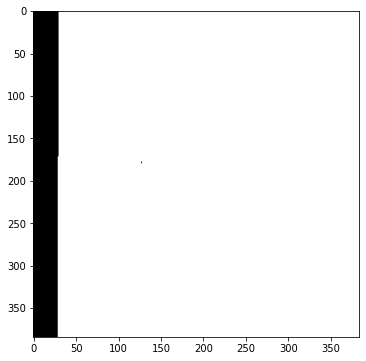

<Figure size 576x576 with 0 Axes>

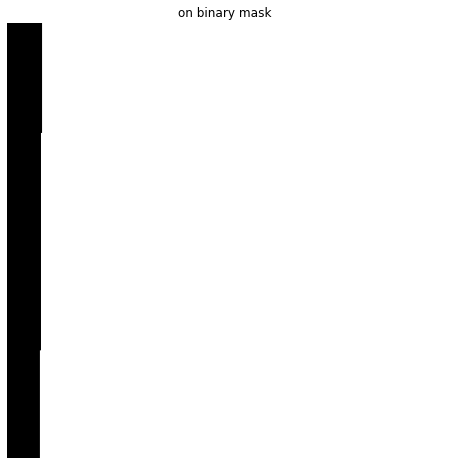

Image saved to post_process_vaga/pred_mask_raw_59.png
37 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_14.png


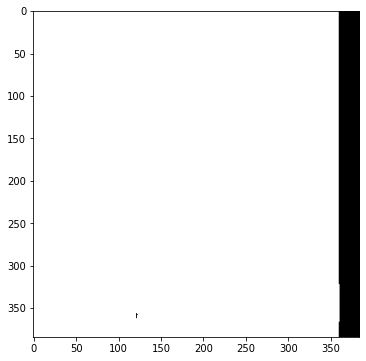

<Figure size 576x576 with 0 Axes>

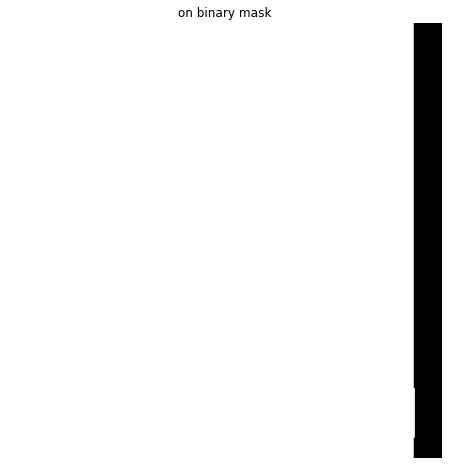

Image saved to post_process_vaga/pred_mask_raw_14.png
38 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_47.png


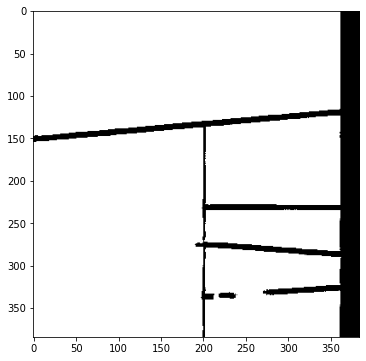

<Figure size 576x576 with 0 Axes>

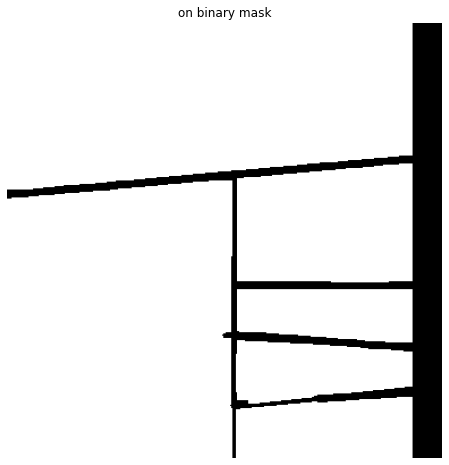

Image saved to post_process_vaga/pred_mask_raw_47.png
39 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_29.png


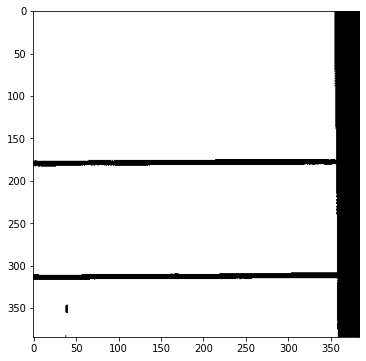

<Figure size 576x576 with 0 Axes>

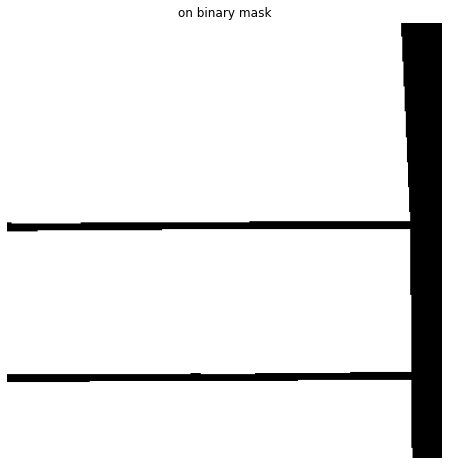

Image saved to post_process_vaga/pred_mask_raw_29.png
40 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_27.png


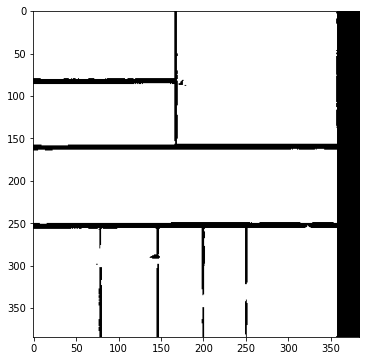

<Figure size 576x576 with 0 Axes>

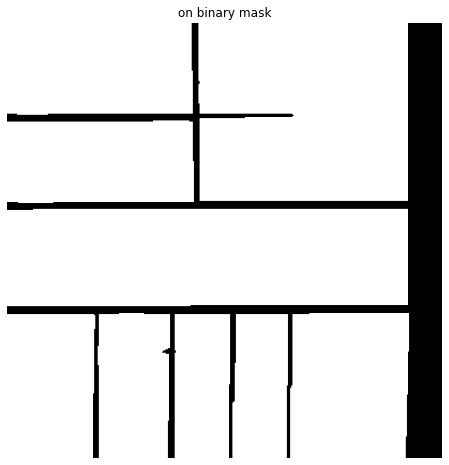

Image saved to post_process_vaga/pred_mask_raw_27.png
41 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_37.png


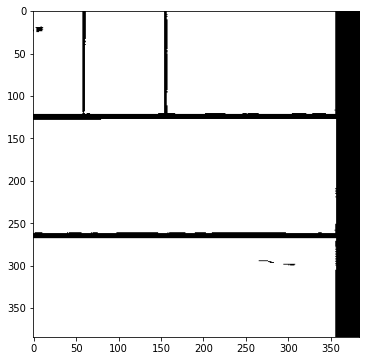

<Figure size 576x576 with 0 Axes>

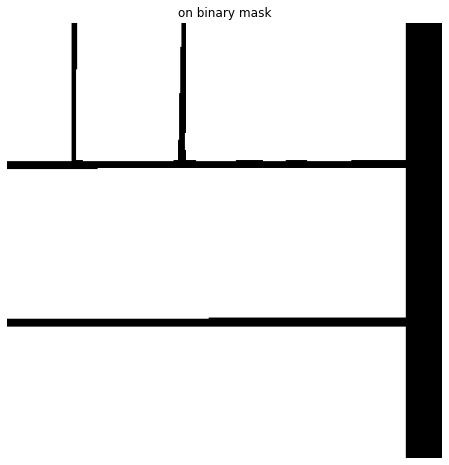

Image saved to post_process_vaga/pred_mask_raw_37.png
42 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_68.png


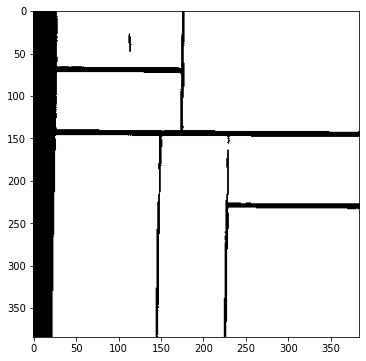

<Figure size 576x576 with 0 Axes>

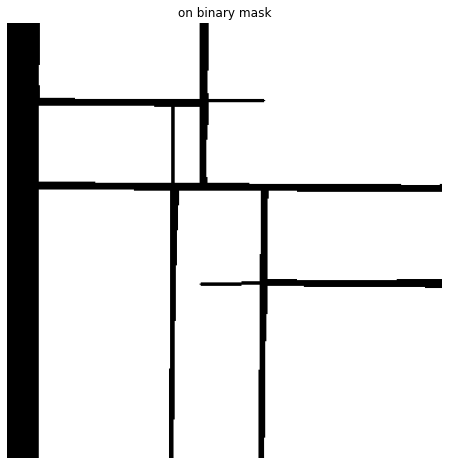

Image saved to post_process_vaga/pred_mask_raw_68.png
43 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_1.png


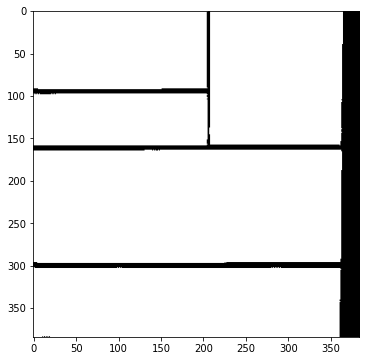

<Figure size 576x576 with 0 Axes>

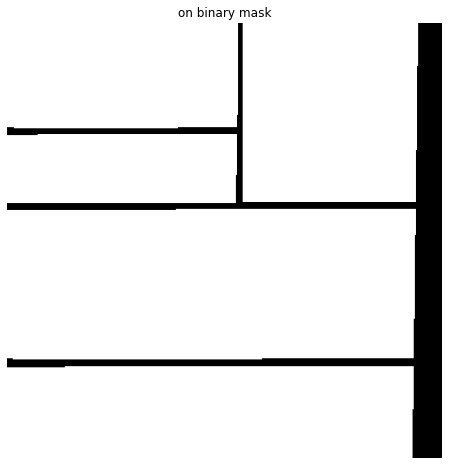

Image saved to post_process_vaga/pred_mask_raw_1.png
44 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_39.png


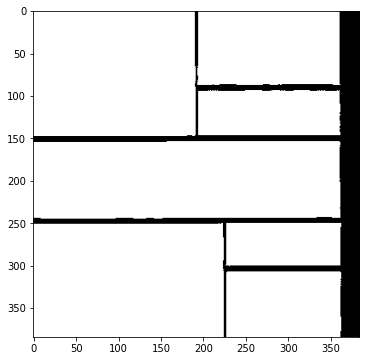

<Figure size 576x576 with 0 Axes>

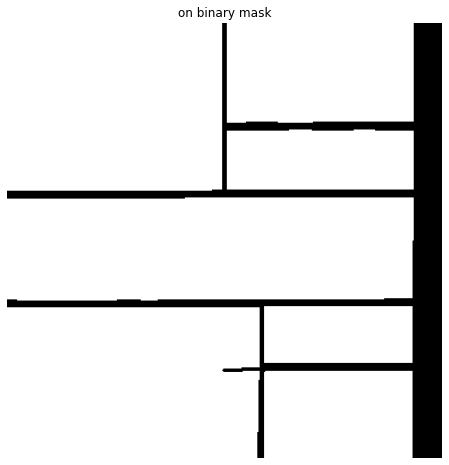

Image saved to post_process_vaga/pred_mask_raw_39.png
45 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_31.png


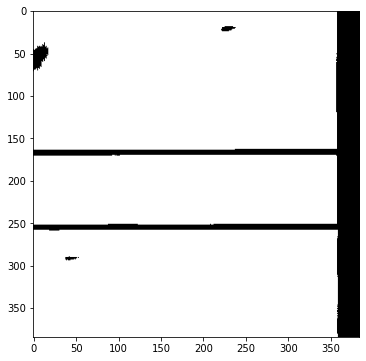

<Figure size 576x576 with 0 Axes>

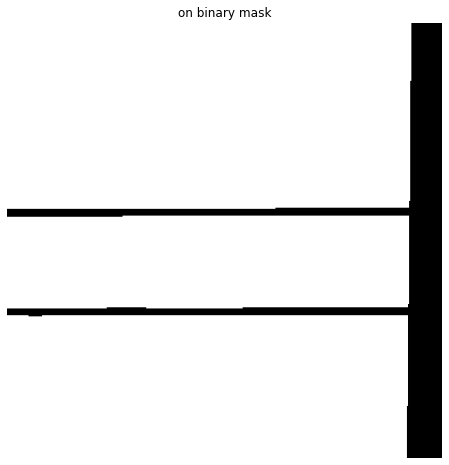

Image saved to post_process_vaga/pred_mask_raw_31.png
46 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_60.png


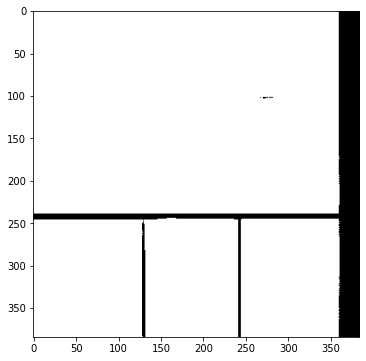

<Figure size 576x576 with 0 Axes>

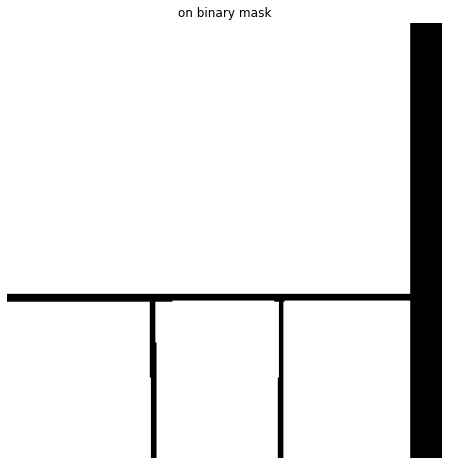

Image saved to post_process_vaga/pred_mask_raw_60.png
47 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_9.png


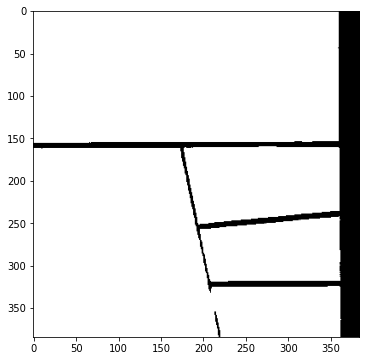

<Figure size 576x576 with 0 Axes>

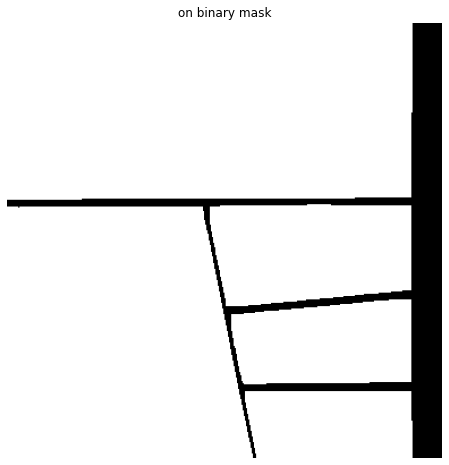

Image saved to post_process_vaga/pred_mask_raw_9.png
48 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_58.png


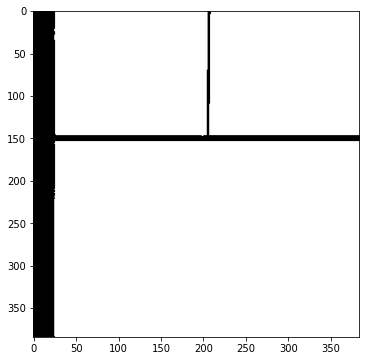

<Figure size 576x576 with 0 Axes>

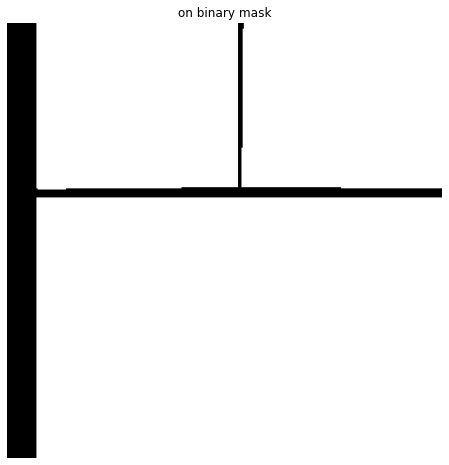

Image saved to post_process_vaga/pred_mask_raw_58.png
49 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_3.png


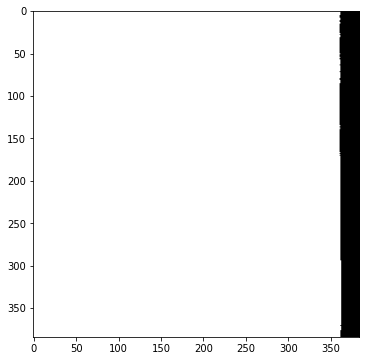

<Figure size 576x576 with 0 Axes>

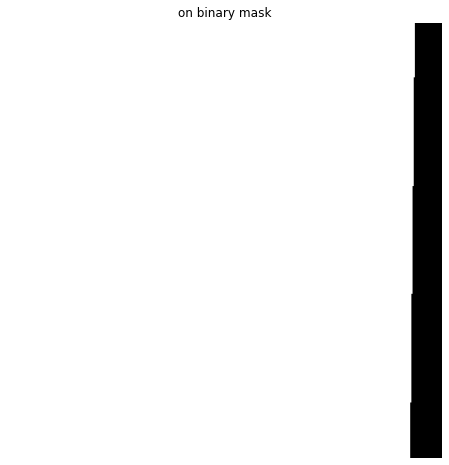

Image saved to post_process_vaga/pred_mask_raw_3.png
50 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_32.png


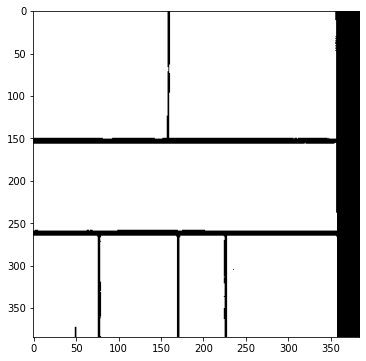

<Figure size 576x576 with 0 Axes>

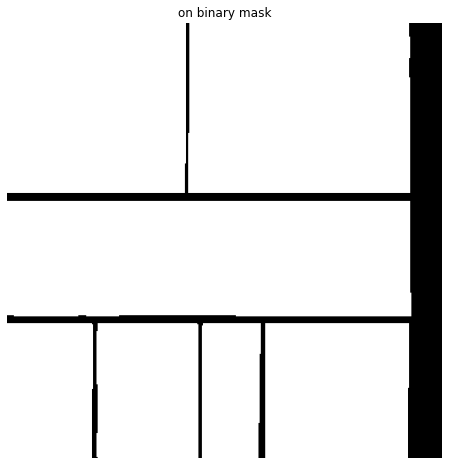

Image saved to post_process_vaga/pred_mask_raw_32.png
51 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_11.png


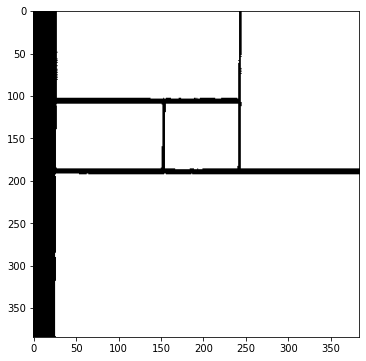

<Figure size 576x576 with 0 Axes>

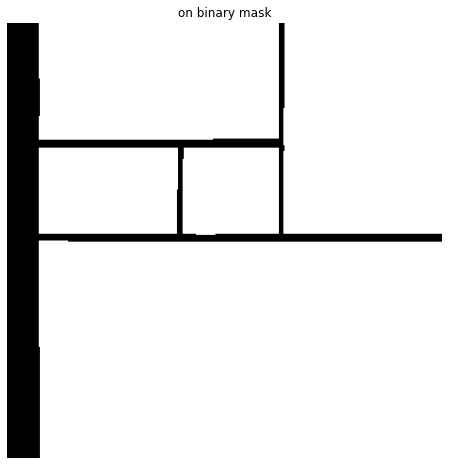

Image saved to post_process_vaga/pred_mask_raw_11.png
52 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_2.png


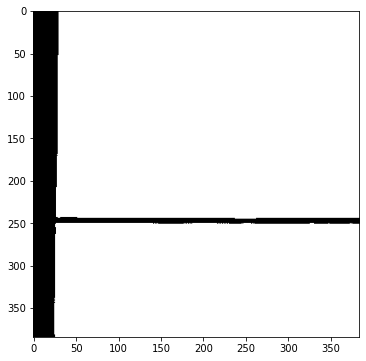

<Figure size 576x576 with 0 Axes>

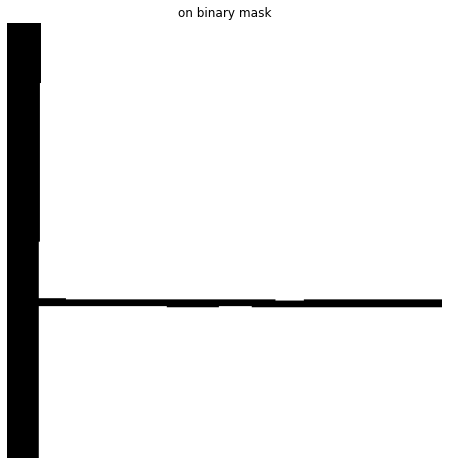

Image saved to post_process_vaga/pred_mask_raw_2.png
53 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_43.png


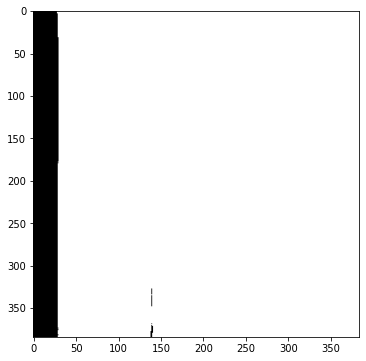

<Figure size 576x576 with 0 Axes>

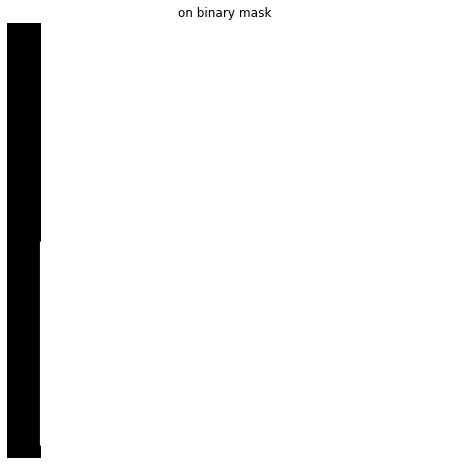

Image saved to post_process_vaga/pred_mask_raw_43.png
54 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_62.png


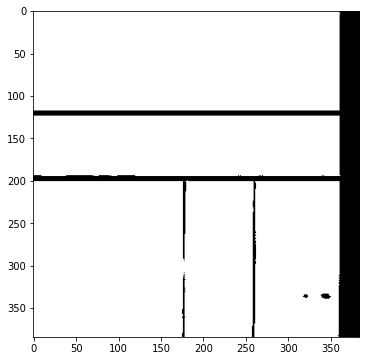

<Figure size 576x576 with 0 Axes>

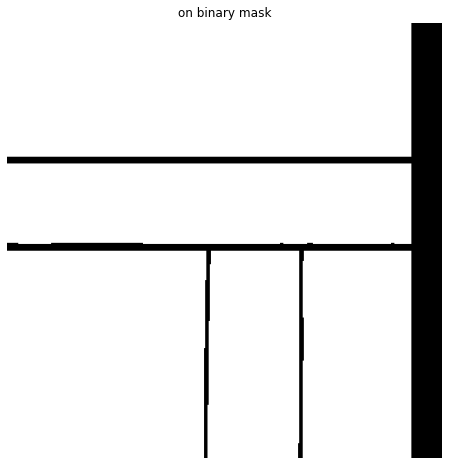

Image saved to post_process_vaga/pred_mask_raw_62.png
55 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_54.png


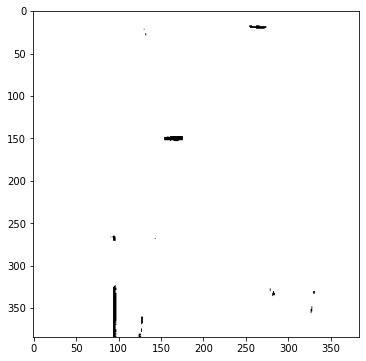

<Figure size 576x576 with 0 Axes>

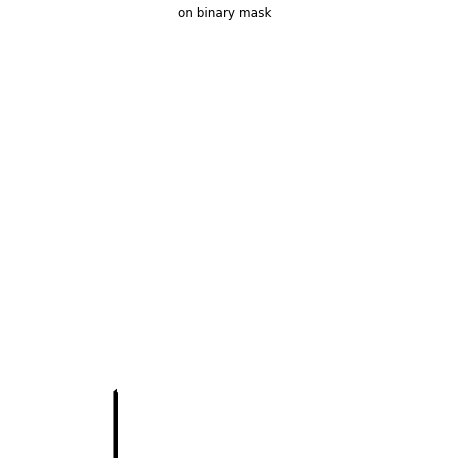

Image saved to post_process_vaga/pred_mask_raw_54.png
56 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_26.png


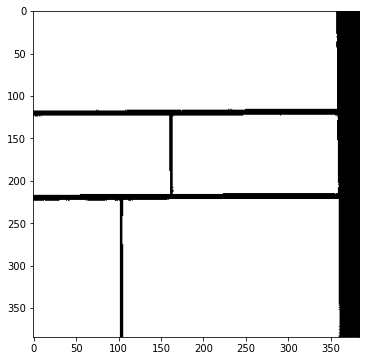

<Figure size 576x576 with 0 Axes>

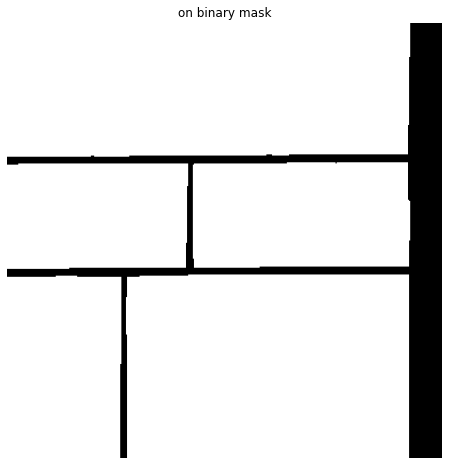

Image saved to post_process_vaga/pred_mask_raw_26.png
57 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_72.png


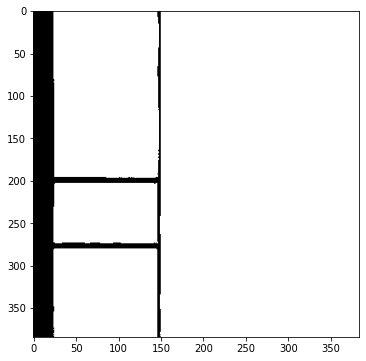

<Figure size 576x576 with 0 Axes>

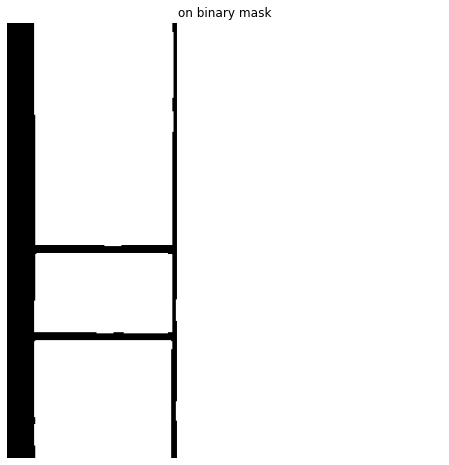

Image saved to post_process_vaga/pred_mask_raw_72.png
58 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_13.png


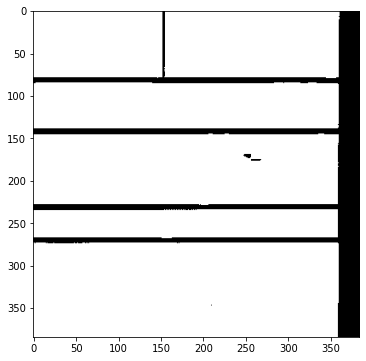

<Figure size 576x576 with 0 Axes>

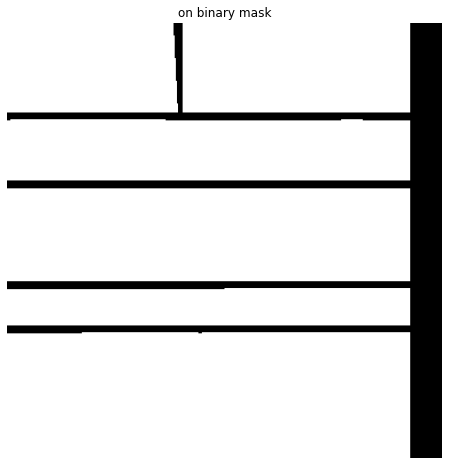

Image saved to post_process_vaga/pred_mask_raw_13.png
59 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_67.png


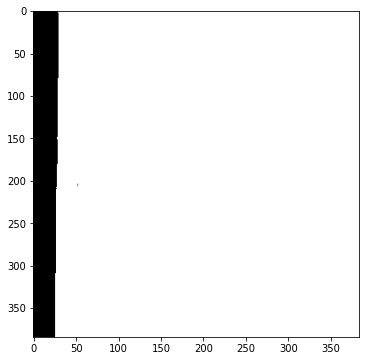

<Figure size 576x576 with 0 Axes>

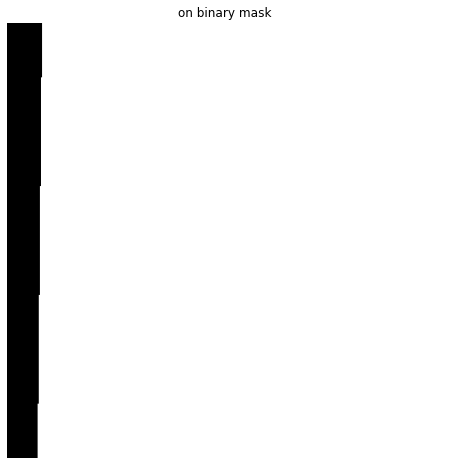

Image saved to post_process_vaga/pred_mask_raw_67.png
60 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_56.png


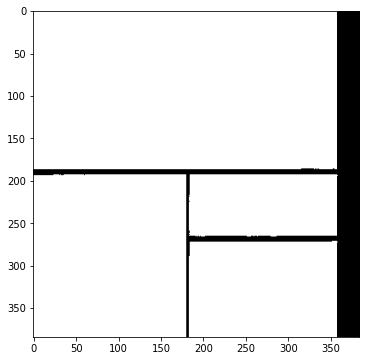

<Figure size 576x576 with 0 Axes>

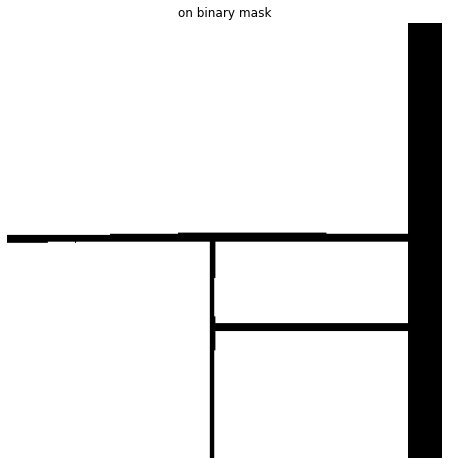

Image saved to post_process_vaga/pred_mask_raw_56.png
61 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_21.png


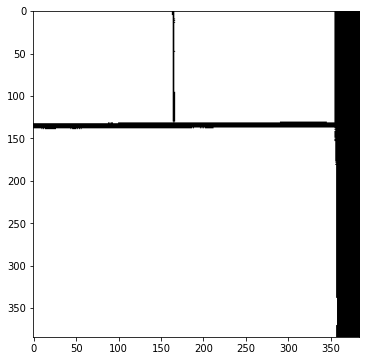

<Figure size 576x576 with 0 Axes>

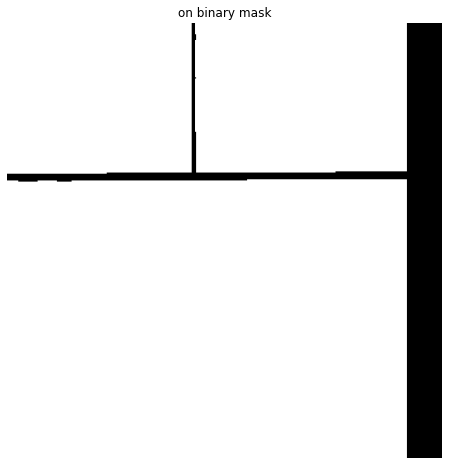

Image saved to post_process_vaga/pred_mask_raw_21.png
62 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_52.png


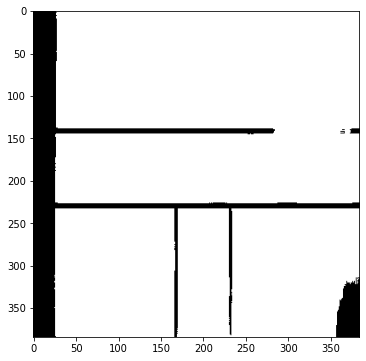

<Figure size 576x576 with 0 Axes>

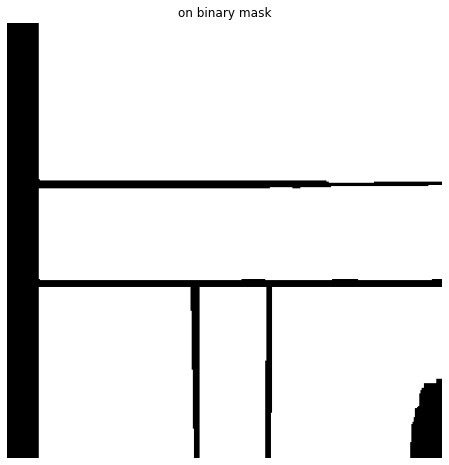

Image saved to post_process_vaga/pred_mask_raw_52.png
63 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_44.png


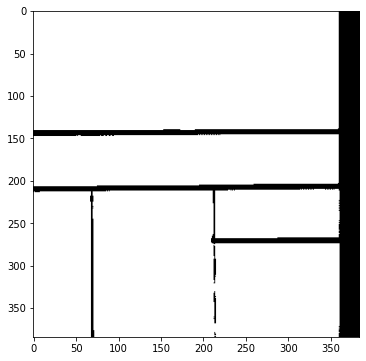

<Figure size 576x576 with 0 Axes>

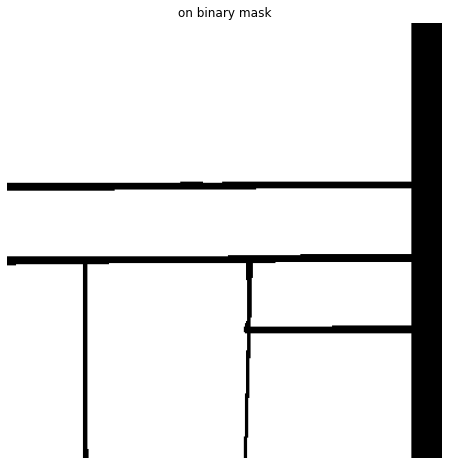

Image saved to post_process_vaga/pred_mask_raw_44.png
64 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_55.png


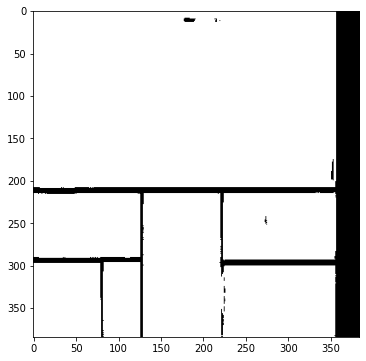

<Figure size 576x576 with 0 Axes>

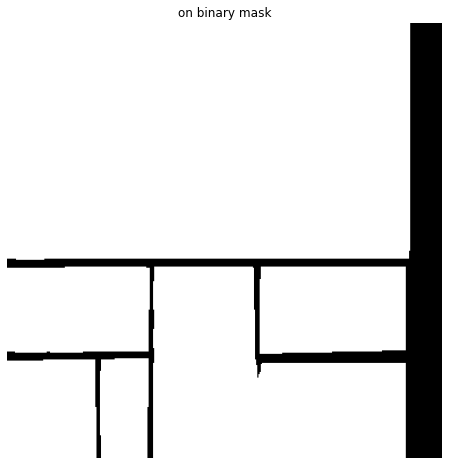

Image saved to post_process_vaga/pred_mask_raw_55.png
65 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_22.png


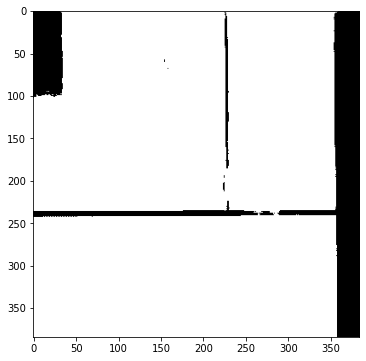

<Figure size 576x576 with 0 Axes>

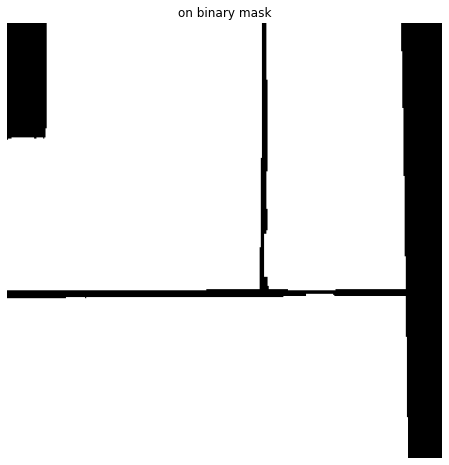

Image saved to post_process_vaga/pred_mask_raw_22.png
66 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_18.png


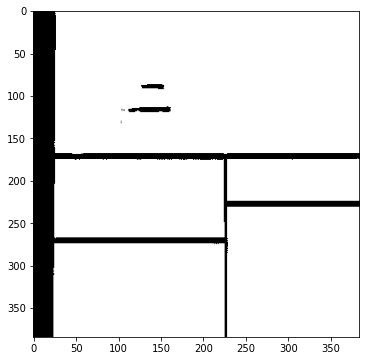

<Figure size 576x576 with 0 Axes>

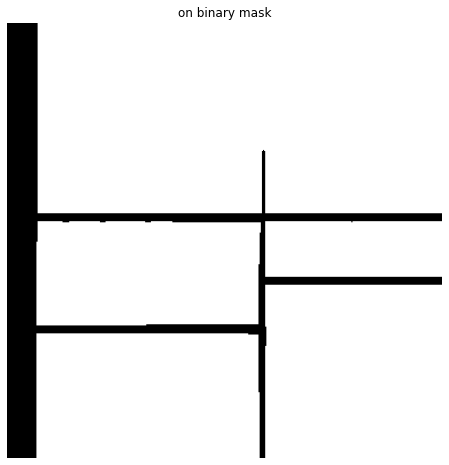

Image saved to post_process_vaga/pred_mask_raw_18.png
67 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_51.png


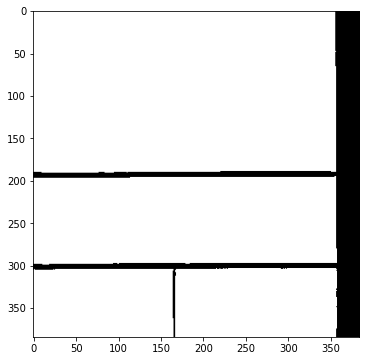

<Figure size 576x576 with 0 Axes>

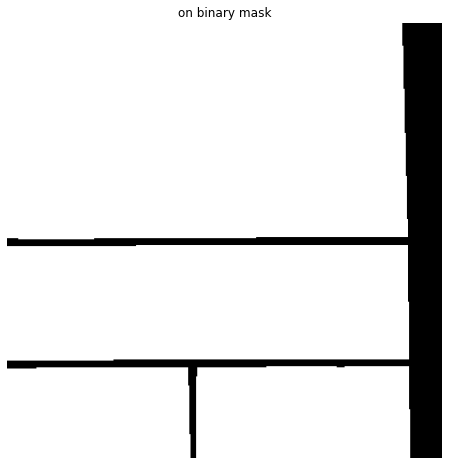

Image saved to post_process_vaga/pred_mask_raw_51.png
68 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_65.png


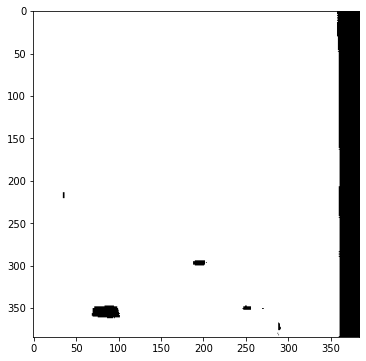

<Figure size 576x576 with 0 Axes>

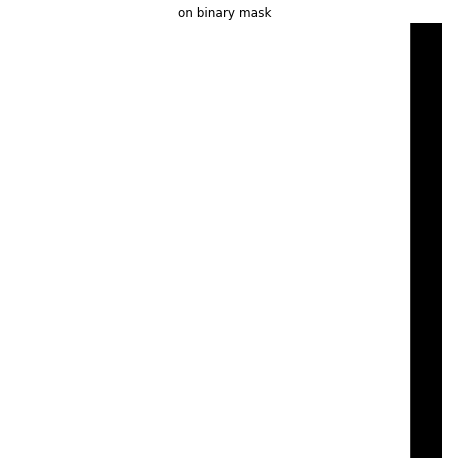

Image saved to post_process_vaga/pred_mask_raw_65.png
69 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_10.png


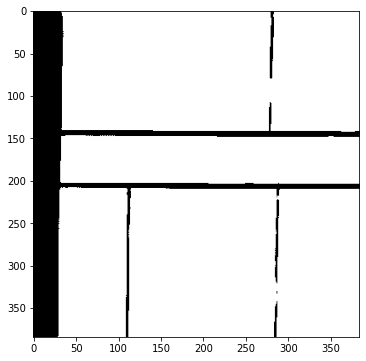

<Figure size 576x576 with 0 Axes>

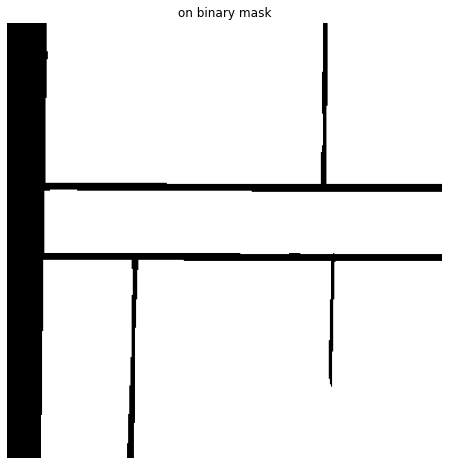

Image saved to post_process_vaga/pred_mask_raw_10.png
70 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_53.png


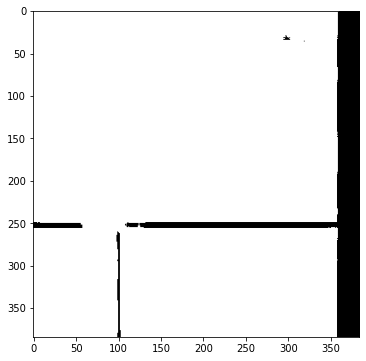

<Figure size 576x576 with 0 Axes>

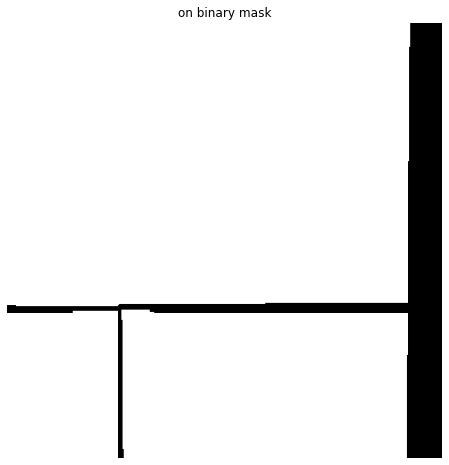

Image saved to post_process_vaga/pred_mask_raw_53.png
71 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_28.png


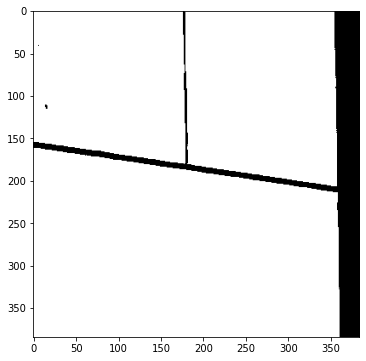

<Figure size 576x576 with 0 Axes>

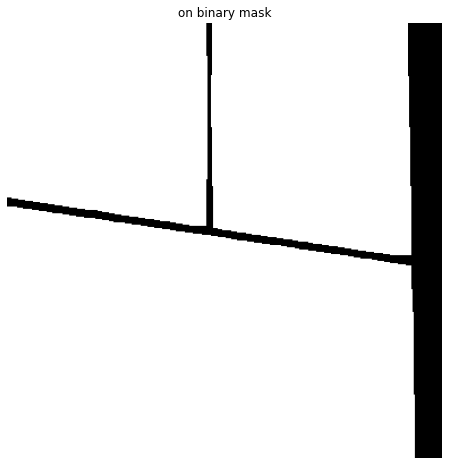

Image saved to post_process_vaga/pred_mask_raw_28.png
72 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_66.png


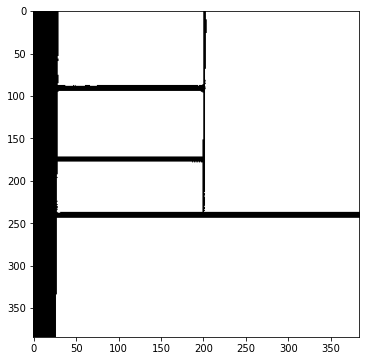

<Figure size 576x576 with 0 Axes>

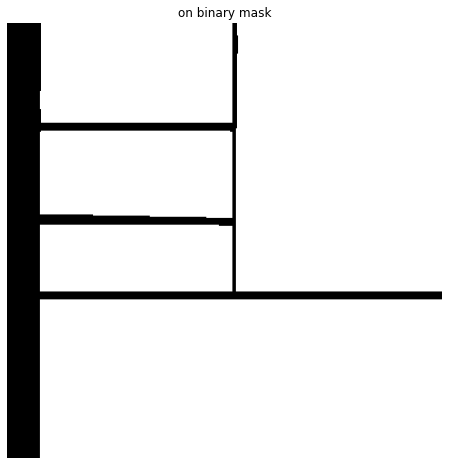

Image saved to post_process_vaga/pred_mask_raw_66.png
73 pred_mask_raw_vaga/pred_mask_raw/pred_mask_raw_38.png


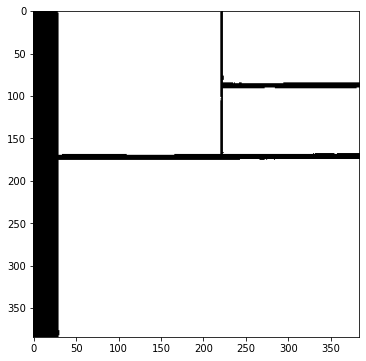

<Figure size 576x576 with 0 Axes>

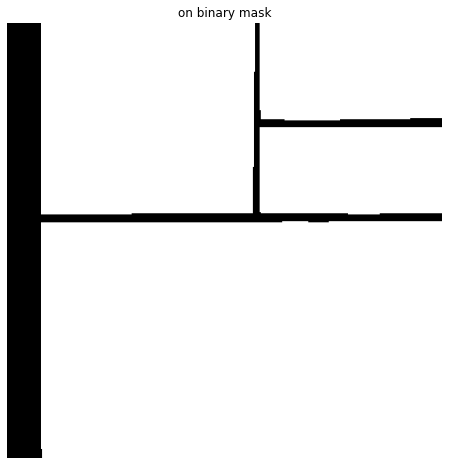

Image saved to post_process_vaga/pred_mask_raw_38.png


In [252]:
dir = 'pred_mask_raw_vaga/pred_mask_raw'
count = 1
# Iterate over all files in the directory
for file in os.listdir(dir):
    path = os.path.join(dir, file)  # Construct full path using os.path.join
    print(count,path)
    
    # Skip the specific file
#     if path == os.path.join(dir, 'pred_mask_raw_54-Copy1.png'):
#         continue  # Skip this iteration
        
    if '.ipynb_checkpoints' in path:
        continue
    
    # Process other files
    full_cock(path,'post_process_vaga')
    count +=1

In [253]:
import shutil
shutil.make_archive('post_process_mixed', 'zip', 'post_process_mixed')
shutil.make_archive('post_process_vaga', 'zip', 'post_process_vaga')

'/mnt/Data/Long-Data/chúa phù hộ người tên khải/fix the panel/post_process_vaga.zip'

In [244]:
from skimage.measure import label

def calculate_iou(pred_binary, gt_binary):
    """
    Compute IoU for two binary masks.
    
    Parameters:
    -----------
    pred_binary (numpy array): Binary mask for predicted object.
    gt_binary (numpy array): Binary mask for ground truth object.
    
    Returns:
    --------
    float: IoU value.
    """

    intersection = np.logical_and(pred_binary, gt_binary).sum()
    union = np.logical_or(pred_binary, gt_binary).sum()
    return intersection / union if union > 0 else 0



def calculate_mean_iou(predicted_mask, ground_truth_mask):
    """
    Calculate Mean IoU (mIoU) for binary masks with multiple objects.

    Parameters:
    -----------
    predicted_mask (numpy array): Binary mask from the model.
    ground_truth_mask (numpy array): Binary ground truth mask.

    Returns:
    --------
    float: Mean IoU value.
    list: IoU values for each ground truth object.
    """

    pred_labels = label(predicted_mask)
    gt_labels = label(ground_truth_mask)
    
    pred_objects = np.unique(pred_labels[pred_labels > 0])
    gt_objects = np.unique(gt_labels[gt_labels > 0])
    
    iou_values = []

    for gt_label in gt_objects:
        gt_binary = gt_labels == gt_label
        best_iou = 0
        
        for pred_label in pred_objects:
            pred_binary = pred_labels == pred_label
            iou = calculate_iou(pred_binary, gt_binary)
            best_iou = max(best_iou, iou)
        
        iou_values.append(best_iou)
    
    mean_iou = np.mean(iou_values) if iou_values else 0
    return mean_iou, iou_values


def calculate_dice(pred_binary, gt_binary):
    """ 
    Compute dice coefficient for two binary masks.
    
    Parameters:
    -----------
    pred_binary (numpy array): Binary mask for predicted panel.
    gt_binary (numpy array): Binary mask for ground truth panel.
    
    Returns:
    --------
    float: Dice coef value.
    """

    intersection = np.logical_and(pred_binary, gt_binary).sum()
    sum_cardinality = pred_binary.sum() + gt_binary.sum()
    return 2*intersection / sum_cardinality if sum_cardinality > 0 else 0



def calculate_mean_dice(predicted_mask, gt_mask):
    """ 
    Calculate mean dice coefficient panel-wise

    Parameters:
    -----------
    predicted_mask (numpy array): Binary mask from the model.
    gt_mask (numpy array): Binary ground truth mask.

    Returns:
    --------
    float: Mean dice coef value.
    """

    pred_labels = label(predicted_mask)
    gt_labels = label(gt_mask)
    
    pred_objects = np.unique(pred_labels[pred_labels > 0])
    gt_objects = np.unique(gt_labels[gt_labels > 0])
    
    dice_values = []

    for gt_label in gt_objects:
        gt_binary = gt_labels == gt_label
        best_dice = 0
        
        for pred_label in pred_objects:
            pred_binary = pred_labels == pred_label
            dice = calculate_dice(pred_binary, gt_binary)
            best_dice = max(best_dice, dice)
        
        dice_values.append(best_dice)
    
    mean_dice = np.mean(dice_values) if dice_values else 0
    return mean_dice, dice_values

In [294]:
from cv2 import imread
def calculate_accuracy(predicted_mask, gt_mask, threshold=None):
    pred_labels = label(predicted_mask)
    gt_labels = label(gt_mask)
    
    pred_objects = np.unique(pred_labels[pred_labels > 0])
    gt_objects = np.unique(gt_labels[gt_labels > 0])
    
    correct_predictions = 0
    
    for gt_label in gt_objects:
        gt_binary = gt_labels == gt_label
        best_dice = 0
        
        for pred_label in pred_objects:
            pred_binary = pred_labels == pred_label
            dice = calculate_dice(pred_binary, gt_binary)
            best_dice = max(best_dice, dice)
        
        if best_dice >= threshold:
            correct_predictions += 1
    
    accuracy = correct_predictions / len(gt_objects) if len(gt_objects) > 0 else 0
    return accuracy

def iterate_masks(true_mask_folder, pred_mask_folder, threshold=None):    
    true_mask_files = sorted([f for f in os.listdir(true_mask_folder) if f.startswith("true_mask_") and f.endswith(".png")])
    pred_mask_files = sorted([f for f in os.listdir(pred_mask_folder) if f.startswith("pred_mask_raw_") and f.endswith(".png")])

    total_pages = 0
    correct_pages = 0
    total_panel_accuracies = []

    for true_file in true_mask_files:
        true_file_number = true_file.split('_')[-1].replace('.png', '')
        
        for pred_file in pred_mask_files:
            pred_file_number = pred_file.split('_')[-1].replace('.png', '')
            
            if true_file_number == pred_file_number:
                true_mask_path = os.path.join(true_mask_folder, true_file)
                pred_mask_path = os.path.join(pred_mask_folder, pred_file)
                
                true_mask = imread(true_mask_path) > 0.5
                pred_mask = imread(pred_mask_path) > 0.5
                
                accuracy = calculate_accuracy(pred_mask, true_mask, threshold=threshold)
#                 print(f"Accuracy for {true_file} and {pred_file}: {accuracy}")
                
                total_panel_accuracies.append(accuracy)

                if accuracy == 1:
                    correct_pages += 1
                total_pages += 1
                break 
    
#     print(f'Number of panels: {total_panel_accuracies}')
#     print(f'Number of pages: {total_pages}')
    panel_accuracy = np.mean(total_panel_accuracies) if total_panel_accuracies else 0
    page_accuracy = correct_pages / total_pages if total_pages > 0 else 0

#     print(f"Panel Accuracy (Average): {panel_accuracy}\n")
#     print(f"Page Accuracy: {page_accuracy}")
#     print('---')
    return panel_accuracy, page_accuracy


true_mask_folder = r"true_mask"
pred_mask_folder = r"post_process_vaga"

iterate_masks(true_mask_folder, pred_mask_folder, threshold=0.75)

(0.9237225483800826, 0.8082191780821918)

In [339]:
current_dir = os.getcwd()

# List all items in the current directory
for item in os.listdir(current_dir):
    # Build the full path
    item_path = os.path.join(current_dir, item)
    # Check if the item is a directory and its name starts with 'textname'
    if os.path.isdir(item_path) and item.startswith("post_process_"):
        # Delete the directory
        shutil.rmtree(item_path)
        print(f"Deleted folder: {item}")

Deleted folder: post_process_mixed71
Deleted folder: post_process_vaga71


In [340]:
# max_dice = {'thres':0,'value':0}
# max_iou = {'thres':0,'value':0}
# page_acc= {'thres':0,'value':0}
# panel_acc= {'thres':0,'value':0}

# max_dice_mixed = {'thres':0,'value':0}
# max_iou_mixed = {'thres':0,'value':0}
# page_acc_mixed= {'thres':0,'value':0}
# panel_acc_mixed= {'thres':0,'value':0}

# max_dice_all = {'thres':0,'value':0}
# max_iou_all = {'thres':0,'value':0}
# page_acc_all= {'thres':0,'value':0}
# panel_acc_all= {'thres':0,'value':0}


##### full_cock r chia thành các folder
for hehehe in range(74,96):
    print(hehehe)
    
    dir = 'pred_mask_raw_vaga/pred_mask_raw'
    
    # Iterate over all files in the directory
    for file in os.listdir(dir):
        path = os.path.join(dir, file)  # Construct full path using os.path.join
#         print(count,path)

        # Skip the specific file
    #     if path == os.path.join(dir, 'pred_mask_raw_54-Copy1.png'):
    #         continue  # Skip this iteration

        if '.ipynb_checkpoints' in path:
            continue
        save_folder = f'post_process_vaga{hehehe}'
        # Process other files
        full_cock(path,save_folder,hehehe)
        
    
    dir = 'pred_mask_raw_mixed/pred_mask_raw'

    # Iterate over all files in the directory
    for file in os.listdir(dir):
        path = os.path.join(dir, file)  # Construct full path using os.path.join
#         print(count,path)

        # Skip the specific file
    #     if path == os.path.join(dir, 'pred_mask_raw_54-Copy1.png'):
    #         continue  # Skip this iteration

        if '.ipynb_checkpoints' in path:
            continue
        save_folder_mixed = f'post_process_mixed{hehehe}'
        # Process other files
        full_cock(path,save_folder_mixed,hehehe)
        
# ####### get all metrics    
# ####### vaga part    
#     folder_a = save_folder #pred
#     folder_b = "true_mask"  # ground truth
#     mean_dice_list = []
#     mean_iou_list = []
#     each_dice_list = []
#     each_iou_list = []
#     # List all files in folder A
#     files_in_a = os.listdir(folder_a)

#     # Iterate through each file in folder A
#     for file_name in files_in_a:

#         # Construct full paths for the files in both folders
#         file_path_a = os.path.join(folder_a, file_name)   
#         if '.ipynb_checkpoints' in file_path_a: 
#             continue
#         file_path_b = os.path.join(folder_b, f'true_mask_{file_name.split("_")[3]}')


#         # Check if a corresponding file exists in folder B
#         if os.path.isfile(file_path_b):
#             # Read the images using cv2.imread
#             image_a = cv2.imread(file_path_a)
#             image_b = cv2.imread(file_path_b)

#             # Optional: Verify the images were read correctly
#             if image_a is None:
#                 print(f"Error reading {file_path_a}")
#             if image_b is None:
#                 print(f"Error reading {file_path_b}")


#             mean_iou, each_iou = calculate_mean_iou(image_a,image_b)
#             mean_dice, each_dice = calculate_mean_dice(image_a,image_b)
# #             panel_acc,page_acc = iterate_masks(true_mask_folder, pred_mask_folder, threshold=0.75)
# #             
# # 
#             mean_dice_list.append(mean_dice)
#             mean_iou_list.append(mean_iou)
#             all_dice_mean = sum(mean_dice_list)/ len(mean_dice_list)
#             all_iou_mean = sum(mean_iou_list)/ len(mean_iou_list)
#             if max_dice['value'] < all_dice_mean:
#                 max_dice['thres'] = hehehe
#                 max_dice['value'] = all_dice_mean
                
#             if max_iou['value'] < all_iou_mean:
#                 max_iou['thres'] = hehehe
#                 max_iou['value'] = all_iou_mean
#         else:
#             print(f"File {file_name} does not exist in folder B.")        
                
# ###### mixed data part                
                
#     folder_a = save_folder_mixed #pred
#     folder_b = "true_mask_mixed/true_mask"  # ground truth
#     mean_dice_list = []
#     mean_iou_list = []
#     each_dice_list = []
#     each_iou_list = []
#     # List all files in folder A
#     files_in_a = os.listdir(folder_a)

#     # Iterate through each file in folder A
#     for file_name in files_in_a:

#         # Construct full paths for the files in both folders
#         file_path_a = os.path.join(folder_a, file_name)   
#         if '.ipynb_checkpoints' in file_path_a: 
#             continue
#         file_path_b = os.path.join(folder_b, f'true_mask_{file_name.split("_")[3]}')


#         # Check if a corresponding file exists in folder B
#         if os.path.isfile(file_path_b):
#             # Read the images using cv2.imread
#             image_a = cv2.imread(file_path_a)
#             image_b = cv2.imread(file_path_b)

#             # Optional: Verify the images were read correctly
#             if image_a is None:
#                 print(f"Error reading {file_path_a}")
#             if image_b is None:
#                 print(f"Error reading {file_path_b}")


#             mean_iou, each_iou = calculate_mean_iou(image_a,image_b)
#             mean_dice, each_dice = calculate_mean_dice(image_a,image_b)
#             mean_dice_list.append(mean_dice)
#             mean_iou_list.append(mean_iou)
#             all_dice_mean_mixed = sum(mean_dice_list)/ len(mean_dice_list)
#             all_iou_mean_mixed = sum(mean_iou_list)/ len(mean_iou_list)
#             if max_dice['value'] < all_dice_mean_mixed:
#                 max_dice['thres'] = hehehe
#                 max_dice['value'] = all_dice_mean_mixed
                
#             if max_iou['value'] < all_iou_mean_mixed:
#                 max_iou['thres'] = hehehe
#                 max_iou['value'] = all_iou_mean_mixed
            
# #             each_dice_list.append(each_dice)
# #             each_iou_list.append(each_iou)
            
#         else:
#             print(f"File {file_name} does not exist in folder B.")       
    
    
    
    
    
#     ####### overall metric
#     mean_dice_all = (all_dice_mean_mixed+ all_dice_mean)/2 
#     mean_iou_all = (all_iou_mean_mixed+ all_iou_mean)/2 
#     if max_dice_all['value'] < mean_dice_all:
#         max_dice_all['thres'] = hehehe
#         max_dice_all['value'] = mean_dice_all

#     if max_iou_all['value'] < mean_iou_all:
#         max_iou_all['thres'] = hehehe
#         max_iou_all['value'] = mean_iou_all
# #     panel_acc_all =
# #     page_acc_all = 
    
    

    

74
Image saved to post_process_vaga74/pred_mask_raw_20.png
Image saved to post_process_vaga74/pred_mask_raw_49.png
Image saved to post_process_vaga74/pred_mask_raw_50.png
Image saved to post_process_vaga74/pred_mask_raw_74.png
Image saved to post_process_vaga74/pred_mask_raw_64.png
Image saved to post_process_vaga74/pred_mask_raw_23.png
Image saved to post_process_vaga74/pred_mask_raw_15.png
Image saved to post_process_vaga74/pred_mask_raw_40.png
Image saved to post_process_vaga74/pred_mask_raw_7.png
Image saved to post_process_vaga74/pred_mask_raw_61.png
Image saved to post_process_vaga74/pred_mask_raw_33.png
Image saved to post_process_vaga74/pred_mask_raw_36.png
Image saved to post_process_vaga74/pred_mask_raw_73.png
Image saved to post_process_vaga74/pred_mask_raw_24.png
Image saved to post_process_vaga74/pred_mask_raw_5.png
Image saved to post_process_vaga74/pred_mask_raw_12.png
Image saved to post_process_vaga74/pred_mask_raw_42.png
Image saved to post_process_vaga74/pred_mask_ra

/tmp/ipykernel_772098/848697448.py:85: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 8))


Image saved to post_process_vaga74/pred_mask_raw_71.png
Image saved to post_process_vaga74/pred_mask_raw_41.png
Image saved to post_process_vaga74/pred_mask_raw_17.png
Image saved to post_process_vaga74/pred_mask_raw_25.png
Image saved to post_process_vaga74/pred_mask_raw_46.png
Image saved to post_process_vaga74/pred_mask_raw_45.png
Image saved to post_process_vaga74/pred_mask_raw_19.png
Image saved to post_process_vaga74/pred_mask_raw_30.png
Image saved to post_process_vaga74/pred_mask_raw_35.png
Image saved to post_process_vaga74/pred_mask_raw_8.png
Image saved to post_process_vaga74/pred_mask_raw_70.png
Image saved to post_process_vaga74/pred_mask_raw_6.png
Image saved to post_process_vaga74/pred_mask_raw_48.png
Image saved to post_process_vaga74/pred_mask_raw_16.png
Image saved to post_process_vaga74/pred_mask_raw_34.png
Image saved to post_process_vaga74/pred_mask_raw_59.png
Image saved to post_process_vaga74/pred_mask_raw_14.png
Image saved to post_process_vaga74/pred_mask_raw_4

Image saved to post_process_vaga79/pred_mask_raw_20.png
Image saved to post_process_vaga79/pred_mask_raw_49.png
Image saved to post_process_vaga79/pred_mask_raw_50.png
Image saved to post_process_vaga79/pred_mask_raw_74.png
Image saved to post_process_vaga79/pred_mask_raw_64.png
Image saved to post_process_vaga79/pred_mask_raw_23.png
Image saved to post_process_vaga79/pred_mask_raw_15.png
Image saved to post_process_vaga79/pred_mask_raw_40.png
Image saved to post_process_vaga79/pred_mask_raw_7.png
Image saved to post_process_vaga79/pred_mask_raw_61.png
Image saved to post_process_vaga79/pred_mask_raw_33.png
Image saved to post_process_vaga79/pred_mask_raw_36.png
Image saved to post_process_vaga79/pred_mask_raw_73.png
Image saved to post_process_vaga79/pred_mask_raw_24.png
Image saved to post_process_vaga79/pred_mask_raw_5.png
Image saved to post_process_vaga79/pred_mask_raw_12.png
Image saved to post_process_vaga79/pred_mask_raw_42.png
Image saved to post_process_vaga79/pred_mask_raw_4

Image saved to post_process_vaga80/pred_mask_raw_8.png
Image saved to post_process_vaga80/pred_mask_raw_70.png
Image saved to post_process_vaga80/pred_mask_raw_6.png
Image saved to post_process_vaga80/pred_mask_raw_48.png
Image saved to post_process_vaga80/pred_mask_raw_16.png
Image saved to post_process_vaga80/pred_mask_raw_34.png
Image saved to post_process_vaga80/pred_mask_raw_59.png
Image saved to post_process_vaga80/pred_mask_raw_14.png
Image saved to post_process_vaga80/pred_mask_raw_47.png
Image saved to post_process_vaga80/pred_mask_raw_29.png
Image saved to post_process_vaga80/pred_mask_raw_27.png
Image saved to post_process_vaga80/pred_mask_raw_37.png
Image saved to post_process_vaga80/pred_mask_raw_68.png
Image saved to post_process_vaga80/pred_mask_raw_1.png
Image saved to post_process_vaga80/pred_mask_raw_39.png
Image saved to post_process_vaga80/pred_mask_raw_31.png
Image saved to post_process_vaga80/pred_mask_raw_60.png
Image saved to post_process_vaga80/pred_mask_raw_9.

Image saved to post_process_vaga81/pred_mask_raw_56.png
Image saved to post_process_vaga81/pred_mask_raw_21.png
Image saved to post_process_vaga81/pred_mask_raw_52.png
Image saved to post_process_vaga81/pred_mask_raw_44.png
Image saved to post_process_vaga81/pred_mask_raw_55.png
Image saved to post_process_vaga81/pred_mask_raw_22.png
Image saved to post_process_vaga81/pred_mask_raw_18.png
Image saved to post_process_vaga81/pred_mask_raw_51.png
Image saved to post_process_vaga81/pred_mask_raw_65.png
Image saved to post_process_vaga81/pred_mask_raw_10.png
Image saved to post_process_vaga81/pred_mask_raw_53.png
Image saved to post_process_vaga81/pred_mask_raw_28.png
Image saved to post_process_vaga81/pred_mask_raw_66.png
Image saved to post_process_vaga81/pred_mask_raw_38.png
Image saved to post_process_mixed81/pred_mask_raw_20.png
Image saved to post_process_mixed81/pred_mask_raw_50.png
Image saved to post_process_mixed81/pred_mask_raw_23.png
Image saved to post_process_mixed81/pred_mask

Image saved to post_process_mixed82/pred_mask_raw_19.png
Image saved to post_process_mixed82/pred_mask_raw_30.png
Image saved to post_process_mixed82/pred_mask_raw_35.png
Image saved to post_process_mixed82/pred_mask_raw_8.png
Image saved to post_process_mixed82/pred_mask_raw_6.png
Image saved to post_process_mixed82/pred_mask_raw_48.png
Image saved to post_process_mixed82/pred_mask_raw_16.png
Image saved to post_process_mixed82/pred_mask_raw_34.png
Image saved to post_process_mixed82/pred_mask_raw_14.png
Image saved to post_process_mixed82/pred_mask_raw_47.png
Image saved to post_process_mixed82/pred_mask_raw_29.png
Image saved to post_process_mixed82/pred_mask_raw_27.png
Image saved to post_process_mixed82/pred_mask_raw_37.png
Image saved to post_process_mixed82/pred_mask_raw_1.png
Image saved to post_process_mixed82/pred_mask_raw_31.png
Image saved to post_process_mixed82/pred_mask_raw_9.png
Image saved to post_process_mixed82/pred_mask_raw_3.png
Image saved to post_process_mixed82/

Image saved to post_process_vaga84/pred_mask_raw_20.png
Image saved to post_process_vaga84/pred_mask_raw_49.png
Image saved to post_process_vaga84/pred_mask_raw_50.png
Image saved to post_process_vaga84/pred_mask_raw_74.png
Image saved to post_process_vaga84/pred_mask_raw_64.png
Image saved to post_process_vaga84/pred_mask_raw_23.png
Image saved to post_process_vaga84/pred_mask_raw_15.png
Image saved to post_process_vaga84/pred_mask_raw_40.png
Image saved to post_process_vaga84/pred_mask_raw_7.png
Image saved to post_process_vaga84/pred_mask_raw_61.png
Image saved to post_process_vaga84/pred_mask_raw_33.png
Image saved to post_process_vaga84/pred_mask_raw_36.png
Image saved to post_process_vaga84/pred_mask_raw_73.png
Image saved to post_process_vaga84/pred_mask_raw_24.png
Image saved to post_process_vaga84/pred_mask_raw_5.png
Image saved to post_process_vaga84/pred_mask_raw_12.png
Image saved to post_process_vaga84/pred_mask_raw_42.png
Image saved to post_process_vaga84/pred_mask_raw_4

Image saved to post_process_vaga85/pred_mask_raw_8.png
Image saved to post_process_vaga85/pred_mask_raw_70.png
Image saved to post_process_vaga85/pred_mask_raw_6.png
Image saved to post_process_vaga85/pred_mask_raw_48.png
Image saved to post_process_vaga85/pred_mask_raw_16.png
Image saved to post_process_vaga85/pred_mask_raw_34.png
Image saved to post_process_vaga85/pred_mask_raw_59.png
Image saved to post_process_vaga85/pred_mask_raw_14.png
Image saved to post_process_vaga85/pred_mask_raw_47.png
Image saved to post_process_vaga85/pred_mask_raw_29.png
Image saved to post_process_vaga85/pred_mask_raw_27.png
Image saved to post_process_vaga85/pred_mask_raw_37.png
Image saved to post_process_vaga85/pred_mask_raw_68.png
Image saved to post_process_vaga85/pred_mask_raw_1.png
Image saved to post_process_vaga85/pred_mask_raw_39.png
Image saved to post_process_vaga85/pred_mask_raw_31.png
Image saved to post_process_vaga85/pred_mask_raw_60.png
Image saved to post_process_vaga85/pred_mask_raw_9.

Image saved to post_process_vaga86/pred_mask_raw_56.png
Image saved to post_process_vaga86/pred_mask_raw_21.png
Image saved to post_process_vaga86/pred_mask_raw_52.png
Image saved to post_process_vaga86/pred_mask_raw_44.png
Image saved to post_process_vaga86/pred_mask_raw_55.png
Image saved to post_process_vaga86/pred_mask_raw_22.png
Image saved to post_process_vaga86/pred_mask_raw_18.png
Image saved to post_process_vaga86/pred_mask_raw_51.png
Image saved to post_process_vaga86/pred_mask_raw_65.png
Image saved to post_process_vaga86/pred_mask_raw_10.png
Image saved to post_process_vaga86/pred_mask_raw_53.png
Image saved to post_process_vaga86/pred_mask_raw_28.png
Image saved to post_process_vaga86/pred_mask_raw_66.png
Image saved to post_process_vaga86/pred_mask_raw_38.png
Image saved to post_process_mixed86/pred_mask_raw_20.png
Image saved to post_process_mixed86/pred_mask_raw_50.png
Image saved to post_process_mixed86/pred_mask_raw_23.png
Image saved to post_process_mixed86/pred_mask

Image saved to post_process_mixed87/pred_mask_raw_19.png
Image saved to post_process_mixed87/pred_mask_raw_30.png
Image saved to post_process_mixed87/pred_mask_raw_35.png
Image saved to post_process_mixed87/pred_mask_raw_8.png
Image saved to post_process_mixed87/pred_mask_raw_6.png
Image saved to post_process_mixed87/pred_mask_raw_48.png
Image saved to post_process_mixed87/pred_mask_raw_16.png
Image saved to post_process_mixed87/pred_mask_raw_34.png
Image saved to post_process_mixed87/pred_mask_raw_14.png
Image saved to post_process_mixed87/pred_mask_raw_47.png
Image saved to post_process_mixed87/pred_mask_raw_29.png
Image saved to post_process_mixed87/pred_mask_raw_27.png
Image saved to post_process_mixed87/pred_mask_raw_37.png
Image saved to post_process_mixed87/pred_mask_raw_1.png
Image saved to post_process_mixed87/pred_mask_raw_31.png
Image saved to post_process_mixed87/pred_mask_raw_9.png
Image saved to post_process_mixed87/pred_mask_raw_3.png
Image saved to post_process_mixed87/

Image saved to post_process_mixed94/pred_mask_raw_20.png
Image saved to post_process_mixed94/pred_mask_raw_50.png
Image saved to post_process_mixed94/pred_mask_raw_23.png
Image saved to post_process_mixed94/pred_mask_raw_15.png
Image saved to post_process_mixed94/pred_mask_raw_40.png
Image saved to post_process_mixed94/pred_mask_raw_7.png
Image saved to post_process_mixed94/pred_mask_raw_36.png
Image saved to post_process_mixed94/pred_mask_raw_5.png
Image saved to post_process_mixed94/pred_mask_raw_12.png
Image saved to post_process_mixed94/pred_mask_raw_42.png
Image saved to post_process_mixed94/pred_mask_raw_4.png
Image saved to post_process_mixed94/pred_mask_raw_41.png
Image saved to post_process_mixed94/pred_mask_raw_25.png
Image saved to post_process_mixed94/pred_mask_raw_46.png
Image saved to post_process_mixed94/pred_mask_raw_45.png
Image saved to post_process_mixed94/pred_mask_raw_19.png
Image saved to post_process_mixed94/pred_mask_raw_30.png
Image saved to post_process_mixed9

Image saved to post_process_mixed95/pred_mask_raw_31.png
Image saved to post_process_mixed95/pred_mask_raw_9.png
Image saved to post_process_mixed95/pred_mask_raw_3.png
Image saved to post_process_mixed95/pred_mask_raw_32.png
Image saved to post_process_mixed95/pred_mask_raw_11.png
Image saved to post_process_mixed95/pred_mask_raw_2.png
Image saved to post_process_mixed95/pred_mask_raw_43.png
Image saved to post_process_mixed95/pred_mask_raw_26.png
Image saved to post_process_mixed95/pred_mask_raw_13.png
Image saved to post_process_mixed95/pred_mask_raw_21.png
Image saved to post_process_mixed95/pred_mask_raw_44.png
Image saved to post_process_mixed95/pred_mask_raw_22.png
Image saved to post_process_mixed95/pred_mask_raw_10.png
Image saved to post_process_mixed95/pred_mask_raw_28.png
Image saved to post_process_mixed95/pred_mask_raw_38.png


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

In [309]:
current_dir = os.getcwd()

# List all folders in the current directory
folders = [f for f in os.listdir(current_dir) if os.path.isdir(os.path.join(current_dir, f))]
sorted(folders)

['.ipynb_checkpoints',
 'img',
 'logs',
 'models',
 'post_process_mixed',
 'post_process_mixed0.71',
 'post_process_mixed0.72',
 'post_process_mixed0.73',
 'post_process_mixed0.74',
 'post_process_mixed0.75',
 'post_process_mixed0.76',
 'post_process_mixed0.77',
 'post_process_mixed0.78',
 'post_process_mixed0.7899999999999999',
 'post_process_mixed0.7999999999999999',
 'post_process_mixed0.8099999999999999',
 'post_process_mixed0.82',
 'post_process_mixed0.83',
 'post_process_mixed0.84',
 'post_process_mixed0.85',
 'post_process_mixed0.86',
 'post_process_mixed0.87',
 'post_process_mixed0.88',
 'post_process_mixed0.8899999999999999',
 'post_process_mixed0.8999999999999999',
 'post_process_mixed0.9099999999999999',
 'post_process_mixed0.9199999999999999',
 'post_process_mixed0.9299999999999999',
 'post_process_mixed0.94',
 'post_process_mixed0.95',
 'post_process_mixed0.96',
 'post_process_mixed0.97',
 'post_process_mixed0.98',
 'post_process_mixed0.99',
 'post_process_vaga',
 'post_pr

In [314]:
list_of_all_mixed_thres = ['post_process_mixed0.71',
 'post_process_mixed0.72',
 'post_process_mixed0.73',
 'post_process_mixed0.74',
 'post_process_mixed0.75',
 'post_process_mixed0.76',
 'post_process_mixed0.77',
 'post_process_mixed0.78',
 'post_process_mixed0.7899999999999999',
 'post_process_mixed0.7999999999999999',
 'post_process_mixed0.8099999999999999',
 'post_process_mixed0.82',
 'post_process_mixed0.83',
 'post_process_mixed0.84',
 'post_process_mixed0.85',
 'post_process_mixed0.86',
 'post_process_mixed0.87',
 'post_process_mixed0.88',
 'post_process_mixed0.8899999999999999',
 'post_process_mixed0.8999999999999999',
 'post_process_mixed0.9099999999999999',
 'post_process_mixed0.9199999999999999',
 'post_process_mixed0.9299999999999999',
 'post_process_mixed0.94',
 'post_process_mixed0.95',
 'post_process_mixed0.96',
 'post_process_mixed0.97',
 'post_process_mixed0.98',
 'post_process_mixed0.99']

list_of_all_vaga_thres = ['post_process_vaga0.71',
 'post_process_vaga0.72',
 'post_process_vaga0.73',
 'post_process_vaga0.74',
 'post_process_vaga0.75',
 'post_process_vaga0.76',
 'post_process_vaga0.77',
 'post_process_vaga0.78',
 'post_process_vaga0.7899999999999999',
 'post_process_vaga0.79',
 'post_process_vaga0.7999999999999999',
 'post_process_vaga0.8',
 'post_process_vaga0.8099999999999999',
 'post_process_vaga0.81',
 'post_process_vaga0.82',
 'post_process_vaga0.8200000000000001',
 'post_process_vaga0.83',
 'post_process_vaga0.84',
 'post_process_vaga0.85',
 'post_process_vaga0.86',
 'post_process_vaga0.87',
 'post_process_vaga0.88',
 'post_process_vaga0.8899999999999999',
 'post_process_vaga0.89',
 'post_process_vaga0.8999999999999999',
 'post_process_vaga0.9',
 'post_process_vaga0.9099999999999999',
 'post_process_vaga0.9199999999999999',
 'post_process_vaga0.9299999999999999',
 'post_process_vaga0.94',
 'post_process_vaga0.95',
 'post_process_vaga0.96',
 'post_process_vaga0.97',
 'post_process_vaga0.98',
 'post_process_vaga0.99']

In [330]:
max_dice = {'thres':0,'value':0}
max_iou = {'thres':0,'value':0}
max_page_acc= {'thres':0,'value':0}
max_panel_acc= {'thres':0,'value':0}

max_dice_mixed = {'thres':0,'value':0}
max_iou_mixed = {'thres':0,'value':0}
max_page_acc_mixed= {'thres':0,'value':0}
max_panel_acc_mixed= {'thres':0,'value':0}

max_dice_all = {'thres':0,'value':0}
max_iou_all = {'thres':0,'value':0}
max_page_acc_all= {'thres':0,'value':0}
max_panel_acc_all= {'thres':0,'value':0}


for save_folder,save_folder_mixed,hehehe in zip(list_of_all_vaga_thres, list_of_all_mixed_thres,np.linspace(0.81,0.99,19)):
    print(hehehe)
    folder_a = save_folder #pred
    folder_b = "true_mask"  # ground truth
    mean_dice_list_vaga = []
    mean_iou_list_vaga = []
    panel_acc_vaga,page_acc_vaga = iterate_masks('true_mask', save_folder, threshold=0.75)
#     max_panel_acc[f'thres{hehehe}'] = hehehe
    max_panel_acc[f'value{hehehe}'] = panel_acc_vaga
#     max_page_acc[f'thres{hehehe}'] = hehehe
    max_page_acc[f'value{hehehe}'] = page_acc_vaga
    
    
    
#     each_dice_list = []
#     each_iou_list = []
    # List all files in folder A
    files_in_a = os.listdir(folder_a)

    # Iterate through each file in folder A
    for file_name in files_in_a:

        # Construct full paths for the files in both folders
        file_path_a = os.path.join(folder_a, file_name)   
        if '.ipynb_checkpoints' in file_path_a: 
            continue
        file_path_b = os.path.join(folder_b, f'true_mask_{file_name.split("_")[3]}')


        # Check if a corresponding file exists in folder B
        if os.path.isfile(file_path_b):
            # Read the images using cv2.imread
            image_a = cv2.imread(file_path_a)
            image_b = cv2.imread(file_path_b)

            # Optional: Verify the images were read correctly
            if image_a is None:
                print(f"Error reading {file_path_a}")
            if image_b is None:
                print(f"Error reading {file_path_b}")


            mean_iou_vaga, each_iou = calculate_mean_iou(image_a,image_b)
            mean_dice_vaga, each_dice = calculate_mean_dice(image_a,image_b)
#             panel_acc,page_acc = iterate_masks(true_mask_folder, pred_mask_folder, threshold=0.75)
#             
# 
            mean_dice_list_vaga.append(mean_dice_vaga)
            mean_iou_list_vaga.append(mean_iou_vaga)
#             panel_acc_vaga,page_acc_vaga = iterate_masks(true_mask_folder, pred_mask_folder, threshold=0.75)
        else:
            print(f"File {file_name} does not exist in folder B.")       
            
            
    all_dice_mean_vaga = sum(mean_dice_list_vaga)/ len(mean_dice_list_vaga)
    all_iou_mean_vaga = sum(mean_iou_list_vaga)/ len(mean_iou_list_vaga)



#     max_dice[f'thres{hehehe}'] = hehehe
    max_dice[f'value{hehehe}'] = all_dice_mean_vaga


#     max_iou[f'thres{hehehe}'] = hehehe
    max_iou[f'value{hehehe}'] = all_iou_mean_vaga
  
                #####
                #####
                #####
                #####
                ###
                #####
                #####
                #####
###### mixed data part                
                
    folder_a = save_folder_mixed #pred
    folder_b = "true_mask_mixed/true_mask"  # ground truth
    mean_dice_list_mixed = []
    mean_iou_list_mixed = []
#     each_dice_list = []
#     each_iou_list = []
    
    panel_acc_mixed,page_acc_mixed = iterate_masks('true_mask_mixed/true_mask', save_folder_mixed, threshold=0.75)
#     max_panel_acc_mixed[f'thres{hehehe}'] = hehehe
    max_panel_acc_mixed[f'value{hehehe}'] = panel_acc_mixed
#     max_page_acc_mixed[f'thres{hehehe}'] = hehehe
    max_page_acc_mixed[f'value{hehehe}'] = page_acc_mixed
    
    
    # List all files in folder A
    files_in_a = os.listdir(folder_a)

    # Iterate through each file in folder A
    for file_name in files_in_a:

        # Construct full paths for the files in both folders
        file_path_a = os.path.join(folder_a, file_name)   
        if '.ipynb_checkpoints' in file_path_a: 
            continue
        file_path_b = os.path.join(folder_b, f'true_mask_{file_name.split("_")[3]}')


        # Check if a corresponding file exists in folder B
        if os.path.isfile(file_path_b):
            # Read the images using cv2.imread
            image_a = cv2.imread(file_path_a)
            image_b = cv2.imread(file_path_b)

            # Optional: Verify the images were read correctly
            if image_a is None:
                print(f"Error reading {file_path_a}")
            if image_b is None:
                print(f"Error reading {file_path_b}")


            mean_iou_mixed, each_iou = calculate_mean_iou(image_a,image_b)
            mean_dice_mixed, each_dice = calculate_mean_dice(image_a,image_b)
            
            mean_dice_list_mixed.append(mean_dice_mixed)
            mean_iou_list_mixed.append(mean_iou_mixed)
        else:
            print(f"File {file_name} does not exist in folder B.")                
    all_dice_mean_mixed = sum(mean_dice_list_mixed)/ len(mean_dice_list_mixed)
    all_iou_mean_mixed = sum(mean_iou_list_mixed)/ len(mean_iou_list_mixed)


#     max_dice_mixed[f'thres{hehehe}'] = hehehe
    max_dice_mixed[f'value{hehehe}'] = all_dice_mean_mixed


#     max_iou_mixed[f'thres{hehehe}'] = hehehe
    max_iou_mixed[f'value{hehehe}'] = all_iou_mean_mixed
            
#             each_dice_list.append(each_dice)
#             each_iou_list.append(each_iou)
            
   

    
    
    
    
    ####### overall metric
    mean_dice_all = (all_dice_mean_mixed+ all_dice_mean_vaga)/2 
    mean_iou_all = (all_iou_mean_mixed+ all_iou_mean_vaga)/2 

#     max_dice_all[f'thres{hehehe}'] = hehehe
    max_dice_all[f'value{hehehe}'] = mean_dice_all


#     max_iou_all[f'thres{hehehe}'] = hehehe
    max_iou_all[f'value{hehehe}'] = mean_iou_all
    
    
    
    
    panel_acc_all = (panel_acc_vaga + panel_acc_mixed)/2
    page_acc_all = (page_acc_vaga + page_acc_mixed)/2
#     max_page_acc_all[f'thres{hehehe}'] = hehehe
    max_page_acc_all[f'value{hehehe}'] = page_acc_all
    
#     max_panel_acc_all[f'thres{hehehe}'] = hehehe
    max_panel_acc_all[f'value{hehehe}'] = panel_acc_all
    
#     page_acc_all = 
    

0.9
File pred_mask_raw_3.png does not exist in folder B.
0.91
File pred_mask_raw_3.png does not exist in folder B.
0.92
File pred_mask_raw_3.png does not exist in folder B.
0.93
File pred_mask_raw_3.png does not exist in folder B.
0.9400000000000001
File pred_mask_raw_3.png does not exist in folder B.
0.95


KeyboardInterrupt: 

In [324]:
mean_dice_vaga

0.9937626762726774

In [328]:
print("max_dice =", max_dice)
print("max_iou =", max_iou)
print("max_page_acc =", max_page_acc)
print("max_panel_acc =", max_panel_acc)

print("max_dice_mixed =", max_dice_mixed)
print("max_iou_mixed =", max_iou_mixed)
print("max_page_acc_mixed =", max_page_acc_mixed)
print("max_panel_acc_mixed =", max_panel_acc_mixed)

print("max_dice_all =", max_dice_all)
print("max_iou_all =", max_iou_all)
print("max_page_acc_all =", max_page_acc_all)
print("max_panel_acc_all =", max_panel_acc_all)

max_dice = {'thres': 0, 'value': 0, 'thres0.81': 0.81, 'value0.81': 0.9380225795898528, 'thres0.8200000000000001': 0.8200000000000001, 'value0.8200000000000001': 0.9382590898995211, 'thres0.8300000000000001': 0.8300000000000001, 'value0.8300000000000001': 0.9395364726118592, 'thres0.8400000000000001': 0.8400000000000001, 'value0.8400000000000001': 0.9421442511267422, 'thres0.8500000000000001': 0.8500000000000001, 'value0.8500000000000001': 0.9449816371436423, 'thres0.86': 0.86, 'value0.86': 0.9458848834746805, 'thres0.87': 0.87, 'value0.87': 0.9446493804683105, 'thres0.88': 0.88, 'value0.88': 0.9456255953577237, 'thres0.89': 0.89, 'value0.89': 0.9479385281052549}
max_iou = {'thres': 0, 'value': 0, 'thres0.81': 0.81, 'value0.81': 0.9097009692573857, 'thres0.8200000000000001': 0.8200000000000001, 'value0.8200000000000001': 0.9101148075077145, 'thres0.8300000000000001': 0.8300000000000001, 'value0.8300000000000001': 0.9120868268576368, 'thres0.8400000000000001': 0.8400000000000001, 'value

In [ ]:
đây là kết quả của thres 71 - 79, xin đừng xoá
đây là kết quả của thres 71 - 79, xin đừng xoá

đây là kết quả của thres 71 - 79, xin đừng xoá

đây là kết quả của thres 71 - 79, xin đừng xoá

đây là kết quả của thres 71 - 79, xin đừng xoá

đây là kết quả của thres 71 - 79, xin đừng xoá





max_dice = {'thres': 0, 'value': 0, 'thres0.71': 0.71, 'value0.71': 0.9380225795898528, 'thres0.72': 0.72, 'value0.72': 0.9382590898995211, 'thres0.73': 0.73, 'value0.73': 0.9395364726118592, 'thres0.74': 0.74, 'value0.74': 0.9421442511267422, 'thres0.75': 0.75, 'value0.75': 0.9449816371436423, 'thres0.76': 0.76, 'value0.76': 0.9458848834746805, 'thres0.77': 0.77, 'value0.77': 0.9446493804683105, 'thres0.78': 0.78, 'value0.78': 0.9456255953577237, 'thres0.7899999999999999': 0.7899999999999999, 'value0.7899999999999999': 0.9479385281052549}
max_iou = {'thres': 0, 'value': 0, 'thres0.71': 0.71, 'value0.71': 0.9097009692573857, 'thres0.72': 0.72, 'value0.72': 0.9101148075077145, 'thres0.73': 0.73, 'value0.73': 0.9120868268576368, 'thres0.74': 0.74, 'value0.74': 0.9159723289340884, 'thres0.75': 0.75, 'value0.75': 0.9199944399727974, 'thres0.76': 0.76, 'value0.76': 0.9214401144604673, 'thres0.77': 0.77, 'value0.77': 0.9196773274942069, 'thres0.78': 0.78, 'value0.78': 0.9208309179173563, 'thres0.7899999999999999': 0.7899999999999999, 'value0.7899999999999999': 0.9242660490801194}
max_page_acc = {'thres': 0, 'value': 0, 'thres0.71': 0.71, 'value0.71': 0.7123287671232876, 'thres0.72': 0.72, 'value0.72': 0.7123287671232876, 'thres0.73': 0.73, 'value0.73': 0.7123287671232876, 'thres0.74': 0.74, 'value0.74': 0.726027397260274, 'thres0.75': 0.75, 'value0.75': 0.7671232876712328, 'thres0.76': 0.76, 'value0.76': 0.7808219178082192, 'thres0.77': 0.77, 'value0.77': 0.7671232876712328, 'thres0.78': 0.78, 'value0.78': 0.7808219178082192, 'thres0.7899999999999999': 0.7899999999999999, 'value0.7899999999999999': 0.8082191780821918, 'thres0.7999999999999999': 0.7999999999999999, 'value0.7999999999999999': 0}
max_panel_acc = {'thres': 0, 'value': 0, 'thres0.71': 0.71, 'value0.71': 0.9072461404653185, 'thres0.72': 0.72, 'value0.72': 0.9072461404653185, 'thres0.73': 0.73, 'value0.73': 0.9087682104805392, 'thres0.74': 0.74, 'value0.74': 0.9115079365079365, 'thres0.75': 0.75, 'value0.75': 0.9189443357251577, 'thres0.76': 0.76, 'value0.76': 0.9206566644922809, 'thres0.77': 0.77, 'value0.77': 0.9167427701674277, 'thres0.78': 0.78, 'value0.78': 0.9190258751902588, 'thres0.7899999999999999': 0.7899999999999999, 'value0.7899999999999999': 0.9237225483800826, 'thres0.7999999999999999': 0.7999999999999999, 'value0.7999999999999999': 0}
max_dice_mixed = {'thres': 0, 'value': 0, 'thres0.71': 0.71, 'value0.71': 0.9499695777752387, 'thres0.72': 0.72, 'value0.72': 0.950909390161642, 'thres0.73': 0.73, 'value0.73': 0.9529929501790928, 'thres0.74': 0.74, 'value0.74': 0.9532999005563444, 'thres0.75': 0.75, 'value0.75': 0.9534327610249845, 'thres0.76': 0.76, 'value0.76': 0.954424850285151, 'thres0.77': 0.77, 'value0.77': 0.9544517847850534, 'thres0.78': 0.78, 'value0.78': 0.9544685471868143, 'thres0.7899999999999999': 0.7899999999999999, 'value0.7899999999999999': 0.9497382970487455}
max_iou_mixed = {'thres': 0, 'value': 0, 'thres0.71': 0.71, 'value0.71': 0.9218808210535905, 'thres0.72': 0.72, 'value0.72': 0.9235945657515602, 'thres0.73': 0.73, 'value0.73': 0.9268910702253158, 'thres0.74': 0.74, 'value0.74': 0.9273294921371995, 'thres0.75': 0.75, 'value0.75': 0.9275826653080617, 'thres0.76': 0.76, 'value0.76': 0.9291787296557076, 'thres0.77': 0.77, 'value0.77': 0.929252164385784, 'thres0.78': 0.78, 'value0.78': 0.9292833685576981, 'thres0.7899999999999999': 0.7899999999999999, 'value0.7899999999999999': 0.9238335937702848}
max_page_acc_mixed = {'thres': 0, 'value': 0, 'thres0.71': 0.71, 'value0.71': 0.8372093023255814, 'thres0.72': 0.72, 'value0.72': 0.8372093023255814, 'thres0.73': 0.73, 'value0.73': 0.8604651162790697, 'thres0.74': 0.74, 'value0.74': 0.8837209302325582, 'thres0.75': 0.75, 'value0.75': 0.8837209302325582, 'thres0.76': 0.76, 'value0.76': 0.8837209302325582, 'thres0.77': 0.77, 'value0.77': 0.8837209302325582, 'thres0.78': 0.78, 'value0.78': 0.8837209302325582, 'thres0.7899999999999999': 0.7899999999999999, 'value0.7899999999999999': 0.8837209302325582}
max_panel_acc_mixed = {'thres': 0, 'value': 0, 'thres0.71': 0.71, 'value0.71': 0.9439645625692137, 'thres0.72': 0.72, 'value0.72': 0.9439645625692137, 'thres0.73': 0.73, 'value0.73': 0.9472868217054263, 'thres0.74': 0.74, 'value0.74': 0.9511627906976744, 'thres0.75': 0.75, 'value0.75': 0.9511627906976744, 'thres0.76': 0.76, 'value0.76': 0.9511627906976744, 'thres0.77': 0.77, 'value0.77': 0.9511627906976744, 'thres0.78': 0.78, 'value0.78': 0.9511627906976744, 'thres0.7899999999999999': 0.7899999999999999, 'value0.7899999999999999': 0.9453488372093023}
max_dice_all = {'thres': 0, 'value': 0, 'thres0.71': 0.71, 'value0.71': 0.9439960786825458, 'thres0.72': 0.72, 'value0.72': 0.9445842400305815, 'thres0.73': 0.73, 'value0.73': 0.9462647113954761, 'thres0.74': 0.74, 'value0.74': 0.9477220758415432, 'thres0.75': 0.75, 'value0.75': 0.9492071990843134, 'thres0.76': 0.76, 'value0.76': 0.9501548668799158, 'thres0.77': 0.77, 'value0.77': 0.9495505826266819, 'thres0.78': 0.78, 'value0.78': 0.9500470712722691, 'thres0.7899999999999999': 0.7899999999999999, 'value0.7899999999999999': 0.9488384125770002}
max_iou_all = {'thres': 0, 'value': 0, 'thres0.71': 0.71, 'value0.71': 0.9157908951554881, 'thres0.72': 0.72, 'value0.72': 0.9168546866296373, 'thres0.73': 0.73, 'value0.73': 0.9194889485414763, 'thres0.74': 0.74, 'value0.74': 0.921650910535644, 'thres0.75': 0.75, 'value0.75': 0.9237885526404295, 'thres0.76': 0.76, 'value0.76': 0.9253094220580874, 'thres0.77': 0.77, 'value0.77': 0.9244647459399955, 'thres0.78': 0.78, 'value0.78': 0.9250571432375272, 'thres0.7899999999999999': 0.7899999999999999, 'value0.7899999999999999': 0.9240498214252022}
max_page_acc_all = {'thres': 0, 'value': 0, 'thres0.71': 0.71, 'value0.71': 0.7747690347244345, 'thres0.72': 0.72, 'value0.72': 0.7747690347244345, 'thres0.73': 0.73, 'value0.73': 0.7863969417011787, 'thres0.74': 0.74, 'value0.74': 0.8048741637464161, 'thres0.75': 0.75, 'value0.75': 0.8254221089518955, 'thres0.76': 0.76, 'value0.76': 0.8322714240203887, 'thres0.77': 0.77, 'value0.77': 0.8254221089518955, 'thres0.78': 0.78, 'value0.78': 0.8322714240203887, 'thres0.7899999999999999': 0.7899999999999999, 'value0.7899999999999999': 0.8459700541573749}
max_panel_acc_all = {'thres': 0, 'value': 0, 'thres0.71': 0.71, 'value0.71': 0.9256053515172661, 'thres0.72': 0.72, 'value0.72': 0.9256053515172661, 'thres0.73': 0.73, 'value0.73': 0.9280275160929827, 'thres0.74': 0.74, 'value0.74': 0.9313353636028054, 'thres0.75': 0.75, 'value0.75': 0.9350535632114161, 'thres0.76': 0.76, 'value0.76': 0.9359097275949777, 'thres0.77': 0.77, 'value0.77': 0.933952780432551, 'thres0.78': 0.78, 'value0.78': 0.9350943329439666, 'thres0.7899999999999999': 0.7899999999999999, 'value0.7899999999999999': 0.9345356927946924}

In [329]:
# đây là kết quả của thres 80 - 89, xin đừng xoá
# đây là kết quả của thres 80 - 89, xin đừng xoá
# đây là kết quả của thres 80 - 89, xin đừng xoá
# đây là kết quả của thres 80 - 89, xin đừng xoá
# đây là kết quả của thres 80 - 89, xin đừng xoá
# đây là kết quả của thres 80 - 89, xin đừng xoá
# đây là kết quả của thres 80 - 89, xin đừng xoá
# đây là kết quả của thres 80 - 89, xin đừng xoá



# max_dice = {'thres': 0, 'value': 0, 'thres0.81': 0.81, 'value0.81': 0.9380225795898528, 'thres0.8200000000000001': 0.8200000000000001, 'value0.8200000000000001': 0.9382590898995211, 'thres0.8300000000000001': 0.8300000000000001, 'value0.8300000000000001': 0.9395364726118592, 'thres0.8400000000000001': 0.8400000000000001, 'value0.8400000000000001': 0.9421442511267422, 'thres0.8500000000000001': 0.8500000000000001, 'value0.8500000000000001': 0.9449816371436423, 'thres0.86': 0.86, 'value0.86': 0.9458848834746805, 'thres0.87': 0.87, 'value0.87': 0.9446493804683105, 'thres0.88': 0.88, 'value0.88': 0.9456255953577237, 'thres0.89': 0.89, 'value0.89': 0.9479385281052549}
# max_iou = {'thres': 0, 'value': 0, 'thres0.81': 0.81, 'value0.81': 0.9097009692573857, 'thres0.8200000000000001': 0.8200000000000001, 'value0.8200000000000001': 0.9101148075077145, 'thres0.8300000000000001': 0.8300000000000001, 'value0.8300000000000001': 0.9120868268576368, 'thres0.8400000000000001': 0.8400000000000001, 'value0.8400000000000001': 0.9159723289340884, 'thres0.8500000000000001': 0.8500000000000001, 'value0.8500000000000001': 0.9199944399727974, 'thres0.86': 0.86, 'value0.86': 0.9214401144604673, 'thres0.87': 0.87, 'value0.87': 0.9196773274942069, 'thres0.88': 0.88, 'value0.88': 0.9208309179173563, 'thres0.89': 0.89, 'value0.89': 0.9242660490801194}
# max_page_acc = {'thres': 0, 'value': 0, 'thres0.81': 0.81, 'value0.81': 0.7123287671232876, 'thres0.8200000000000001': 0.8200000000000001, 'value0.8200000000000001': 0.7123287671232876, 'thres0.8300000000000001': 0.8300000000000001, 'value0.8300000000000001': 0.7123287671232876, 'thres0.8400000000000001': 0.8400000000000001, 'value0.8400000000000001': 0.726027397260274, 'thres0.8500000000000001': 0.8500000000000001, 'value0.8500000000000001': 0.7671232876712328, 'thres0.86': 0.86, 'value0.86': 0.7808219178082192, 'thres0.87': 0.87, 'value0.87': 0.7671232876712328, 'thres0.88': 0.88, 'value0.88': 0.7808219178082192, 'thres0.89': 0.89, 'value0.89': 0.8082191780821918, 'thres0.9': 0.9, 'value0.9': 0}
# max_panel_acc = {'thres': 0, 'value': 0, 'thres0.81': 0.81, 'value0.81': 0.9072461404653185, 'thres0.8200000000000001': 0.8200000000000001, 'value0.8200000000000001': 0.9072461404653185, 'thres0.8300000000000001': 0.8300000000000001, 'value0.8300000000000001': 0.9087682104805392, 'thres0.8400000000000001': 0.8400000000000001, 'value0.8400000000000001': 0.9115079365079365, 'thres0.8500000000000001': 0.8500000000000001, 'value0.8500000000000001': 0.9189443357251577, 'thres0.86': 0.86, 'value0.86': 0.9206566644922809, 'thres0.87': 0.87, 'value0.87': 0.9167427701674277, 'thres0.88': 0.88, 'value0.88': 0.9190258751902588, 'thres0.89': 0.89, 'value0.89': 0.9237225483800826, 'thres0.9': 0.9, 'value0.9': 0}
# max_dice_mixed = {'thres': 0, 'value': 0, 'thres0.81': 0.81, 'value0.81': 0.9499695777752387, 'thres0.8200000000000001': 0.8200000000000001, 'value0.8200000000000001': 0.950909390161642, 'thres0.8300000000000001': 0.8300000000000001, 'value0.8300000000000001': 0.9529929501790928, 'thres0.8400000000000001': 0.8400000000000001, 'value0.8400000000000001': 0.9532999005563444, 'thres0.8500000000000001': 0.8500000000000001, 'value0.8500000000000001': 0.9534327610249845, 'thres0.86': 0.86, 'value0.86': 0.954424850285151, 'thres0.87': 0.87, 'value0.87': 0.9544517847850534, 'thres0.88': 0.88, 'value0.88': 0.9544685471868143, 'thres0.89': 0.89, 'value0.89': 0.9497382970487455}
# max_iou_mixed = {'thres': 0, 'value': 0, 'thres0.81': 0.81, 'value0.81': 0.9218808210535905, 'thres0.8200000000000001': 0.8200000000000001, 'value0.8200000000000001': 0.9235945657515602, 'thres0.8300000000000001': 0.8300000000000001, 'value0.8300000000000001': 0.9268910702253158, 'thres0.8400000000000001': 0.8400000000000001, 'value0.8400000000000001': 0.9273294921371995, 'thres0.8500000000000001': 0.8500000000000001, 'value0.8500000000000001': 0.9275826653080617, 'thres0.86': 0.86, 'value0.86': 0.9291787296557076, 'thres0.87': 0.87, 'value0.87': 0.929252164385784, 'thres0.88': 0.88, 'value0.88': 0.9292833685576981, 'thres0.89': 0.89, 'value0.89': 0.9238335937702848}
# max_page_acc_mixed = {'thres': 0, 'value': 0, 'thres0.81': 0.81, 'value0.81': 0.8372093023255814, 'thres0.8200000000000001': 0.8200000000000001, 'value0.8200000000000001': 0.8372093023255814, 'thres0.8300000000000001': 0.8300000000000001, 'value0.8300000000000001': 0.8604651162790697, 'thres0.8400000000000001': 0.8400000000000001, 'value0.8400000000000001': 0.8837209302325582, 'thres0.8500000000000001': 0.8500000000000001, 'value0.8500000000000001': 0.8837209302325582, 'thres0.86': 0.86, 'value0.86': 0.8837209302325582, 'thres0.87': 0.87, 'value0.87': 0.8837209302325582, 'thres0.88': 0.88, 'value0.88': 0.8837209302325582, 'thres0.89': 0.89, 'value0.89': 0.8837209302325582}
# max_panel_acc_mixed = {'thres': 0, 'value': 0, 'thres0.81': 0.81, 'value0.81': 0.9439645625692137, 'thres0.8200000000000001': 0.8200000000000001, 'value0.8200000000000001': 0.9439645625692137, 'thres0.8300000000000001': 0.8300000000000001, 'value0.8300000000000001': 0.9472868217054263, 'thres0.8400000000000001': 0.8400000000000001, 'value0.8400000000000001': 0.9511627906976744, 'thres0.8500000000000001': 0.8500000000000001, 'value0.8500000000000001': 0.9511627906976744, 'thres0.86': 0.86, 'value0.86': 0.9511627906976744, 'thres0.87': 0.87, 'value0.87': 0.9511627906976744, 'thres0.88': 0.88, 'value0.88': 0.9511627906976744, 'thres0.89': 0.89, 'value0.89': 0.9453488372093023}
# max_dice_all = {'thres': 0, 'value': 0, 'thres0.81': 0.81, 'value0.81': 0.9439960786825458, 'thres0.8200000000000001': 0.8200000000000001, 'value0.8200000000000001': 0.9445842400305815, 'thres0.8300000000000001': 0.8300000000000001, 'value0.8300000000000001': 0.9462647113954761, 'thres0.8400000000000001': 0.8400000000000001, 'value0.8400000000000001': 0.9477220758415432, 'thres0.8500000000000001': 0.8500000000000001, 'value0.8500000000000001': 0.9492071990843134, 'thres0.86': 0.86, 'value0.86': 0.9501548668799158, 'thres0.87': 0.87, 'value0.87': 0.9495505826266819, 'thres0.88': 0.88, 'value0.88': 0.9500470712722691, 'thres0.89': 0.89, 'value0.89': 0.9488384125770002}
# max_iou_all = {'thres': 0, 'value': 0, 'thres0.81': 0.81, 'value0.81': 0.9157908951554881, 'thres0.8200000000000001': 0.8200000000000001, 'value0.8200000000000001': 0.9168546866296373, 'thres0.8300000000000001': 0.8300000000000001, 'value0.8300000000000001': 0.9194889485414763, 'thres0.8400000000000001': 0.8400000000000001, 'value0.8400000000000001': 0.921650910535644, 'thres0.8500000000000001': 0.8500000000000001, 'value0.8500000000000001': 0.9237885526404295, 'thres0.86': 0.86, 'value0.86': 0.9253094220580874, 'thres0.87': 0.87, 'value0.87': 0.9244647459399955, 'thres0.88': 0.88, 'value0.88': 0.9250571432375272, 'thres0.89': 0.89, 'value0.89': 0.9240498214252022}
# max_page_acc_all = {'thres': 0, 'value': 0, 'thres0.81': 0.81, 'value0.81': 0.7747690347244345, 'thres0.8200000000000001': 0.8200000000000001, 'value0.8200000000000001': 0.7747690347244345, 'thres0.8300000000000001': 0.8300000000000001, 'value0.8300000000000001': 0.7863969417011787, 'thres0.8400000000000001': 0.8400000000000001, 'value0.8400000000000001': 0.8048741637464161, 'thres0.8500000000000001': 0.8500000000000001, 'value0.8500000000000001': 0.8254221089518955, 'thres0.86': 0.86, 'value0.86': 0.8322714240203887, 'thres0.87': 0.87, 'value0.87': 0.8254221089518955, 'thres0.88': 0.88, 'value0.88': 0.8322714240203887, 'thres0.89': 0.89, 'value0.89': 0.8459700541573749}
# max_panel_acc_all = {'thres': 0, 'value': 0, 'thres0.81': 0.81, 'value0.81': 0.9256053515172661, 'thres0.8200000000000001': 0.8200000000000001, 'value0.8200000000000001': 0.9256053515172661, 'thres0.8300000000000001': 0.8300000000000001, 'value0.8300000000000001': 0.9280275160929827, 'thres0.8400000000000001': 0.8400000000000001, 'value0.8400000000000001': 0.9313353636028054, 'thres0.8500000000000001': 0.8500000000000001, 'value0.8500000000000001': 0.9350535632114161, 'thres0.86': 0.86, 'value0.86': 0.9359097275949777, 'thres0.87': 0.87, 'value0.87': 0.933952780432551, 'thres0.88': 0.88, 'value0.88': 0.9350943329439666, 'thres0.89': 0.89, 'value0.89': 0.9345356927946924}

In [302]:
max_dice

{'thres': 0.99, 'value': 0.9922156057641558}

In [303]:
max_iou

{'thres': 0.99, 'value': 0.9845876068526602}

In [306]:
max_iou_all

{'thres': 0.76, 'value': 0.9253094220580874}

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         2.,  0.,  0.,  1.,  1.,  2.,  1.,  3.,  1.,  2.,  3.,  2.,  6.,
        44.]),
 array([0.47099003, 0.4842001 , 0.49741016, 0.51062023, 0.5238303 ,
        0.53704037, 0.55025044, 0.5634605 , 0.57667057, 0.58988064,
        0.60309071, 0.61630077, 0.62951084, 0.64272091, 0.65593098,
        0.66914105, 0.68235111, 0.69556118, 0.70877125, 0.72198132,
        0.73519138, 0.74840145, 0.76161152, 0.77482159, 0.78803165,
        0.80124172, 0.81445179, 0.82766186, 0.84087193, 0.85408199,
        0.86729206, 0.88050213, 0.8937122 , 0.90692226, 0.92013233,
        0.9333424 , 0.94655247, 0.95976254, 0.9729726 , 0.98618267,
        0.99939274]),
 <BarContainer object of 40 artists>)

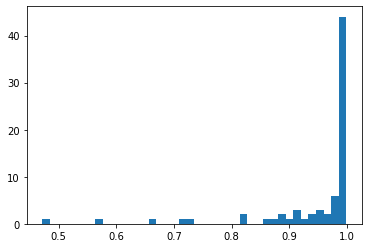

In [270]:
plt.hist(mean_dice_list,bins = 40)